# Tronox de janvier 2014 à juillet 2020

In [19]:
# %%writefile ./_Snippets/finance_import_block.py 
# Uncomment lorsque qu'une nouvelle ligne s'ajoute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings('ignore')

# Print automatiquement toutes les variables de la cellule (pas juste la dernière)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"last_expr" pour rétablir par défaut

%config InlineBackend.figure_format ='retina'

# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat

Overwriting ./_Snippets/finance_import_block.py


In [23]:
TROX = pd.read_csv('_Input/TROX_0114-0720.csv', parse_dates= True)
TROX.index = pd.to_datetime(TROX.Date)
TROX = TROX.drop(columns= ['Date'])
TROX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1640 entries, 2014-01-02 to 2020-07-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1640 non-null   float64
 1   High       1640 non-null   float64
 2   Low        1640 non-null   float64
 3   Close      1640 non-null   float64
 4   Adj Close  1640 non-null   float64
 5   Volume     1640 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 89.7 KB


In [14]:
TROX.describe()

Open         High          Low        Close    Adj Close  \
count  1640.000000  1640.000000  1640.000000  1640.000000  1640.000000   
mean     14.594165    14.909854    14.269671    14.581835    12.909032   
std       7.075265     7.131270     7.022395     7.074393     5.714530   
min       2.870000     3.270000     2.790000     3.000000     2.619431   
25%       8.360000     8.597500     8.097500     8.360000     7.953075   
50%      13.125000    13.400000    12.845000    13.080000    12.353173   
75%      20.490000    20.990000    20.155000    20.542500    17.771516   
max      30.740000    31.049999    30.600000    30.700001    26.080473   

             Volume  
count  1.640000e+03  
mean   1.207774e+06  
std    9.770096e+05  
min    1.301000e+05  
25%    6.409250e+05  
50%    9.961500e+05  
75%    1.491275e+06  
max    1.443050e+07

### Tronox de 2014 à 2020

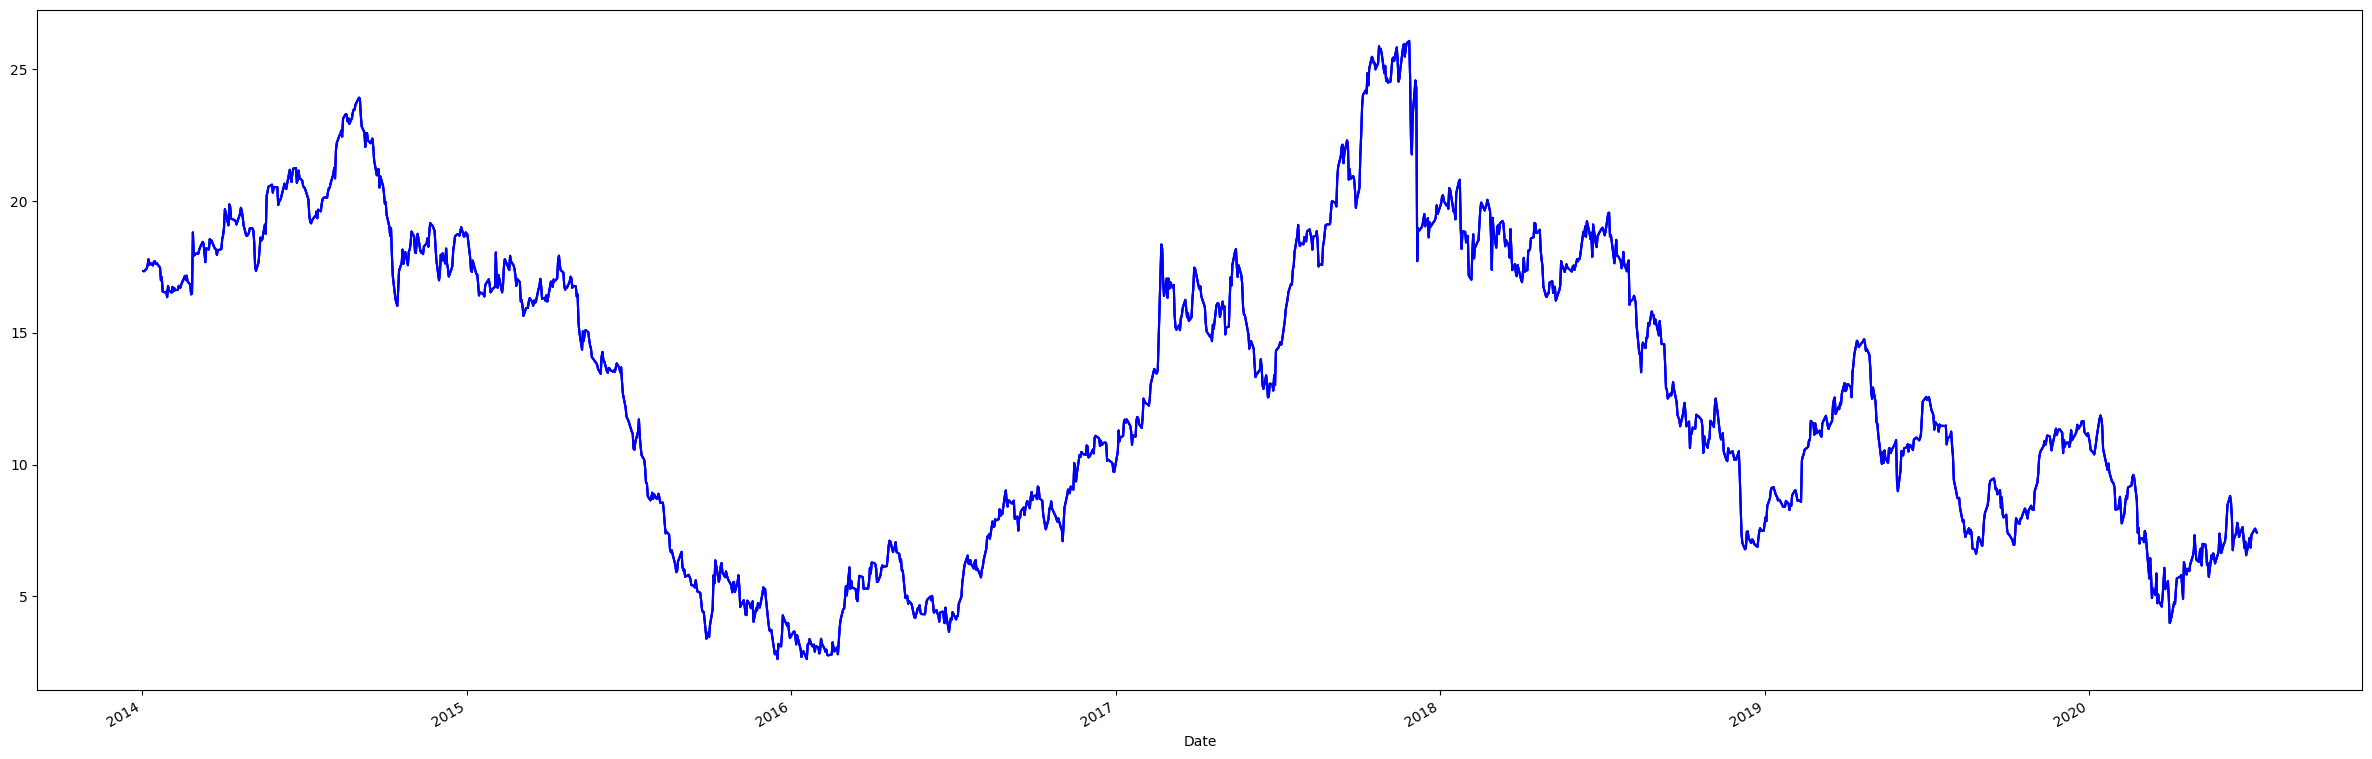

In [17]:
_ = TROX['Adj Close'].plot(color= 'blue', figsize= [30, 10])
plt.show()

## Recherche de la transformation significative et optimale

### Tronox 2016 - Différenciation des valeurs

In [18]:
TROX_diff = TROX['Adj Close'].diff()
TROX_diff.dropna(inplace= True)

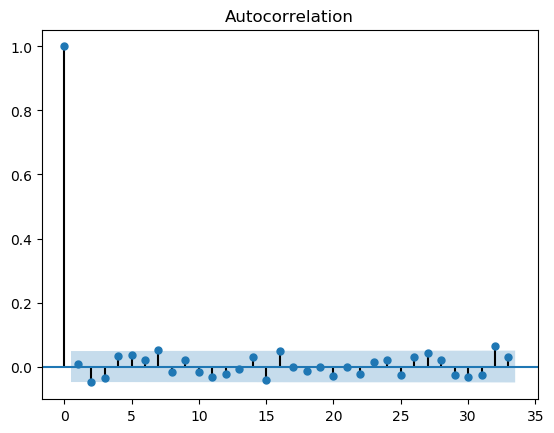

In [23]:
plot_acf(TROX_diff) # _ = est un truc pour éviter d'imprimer 2x le même plot
plt.show()

In [24]:
TROX_2016 = TROX.loc['2016']

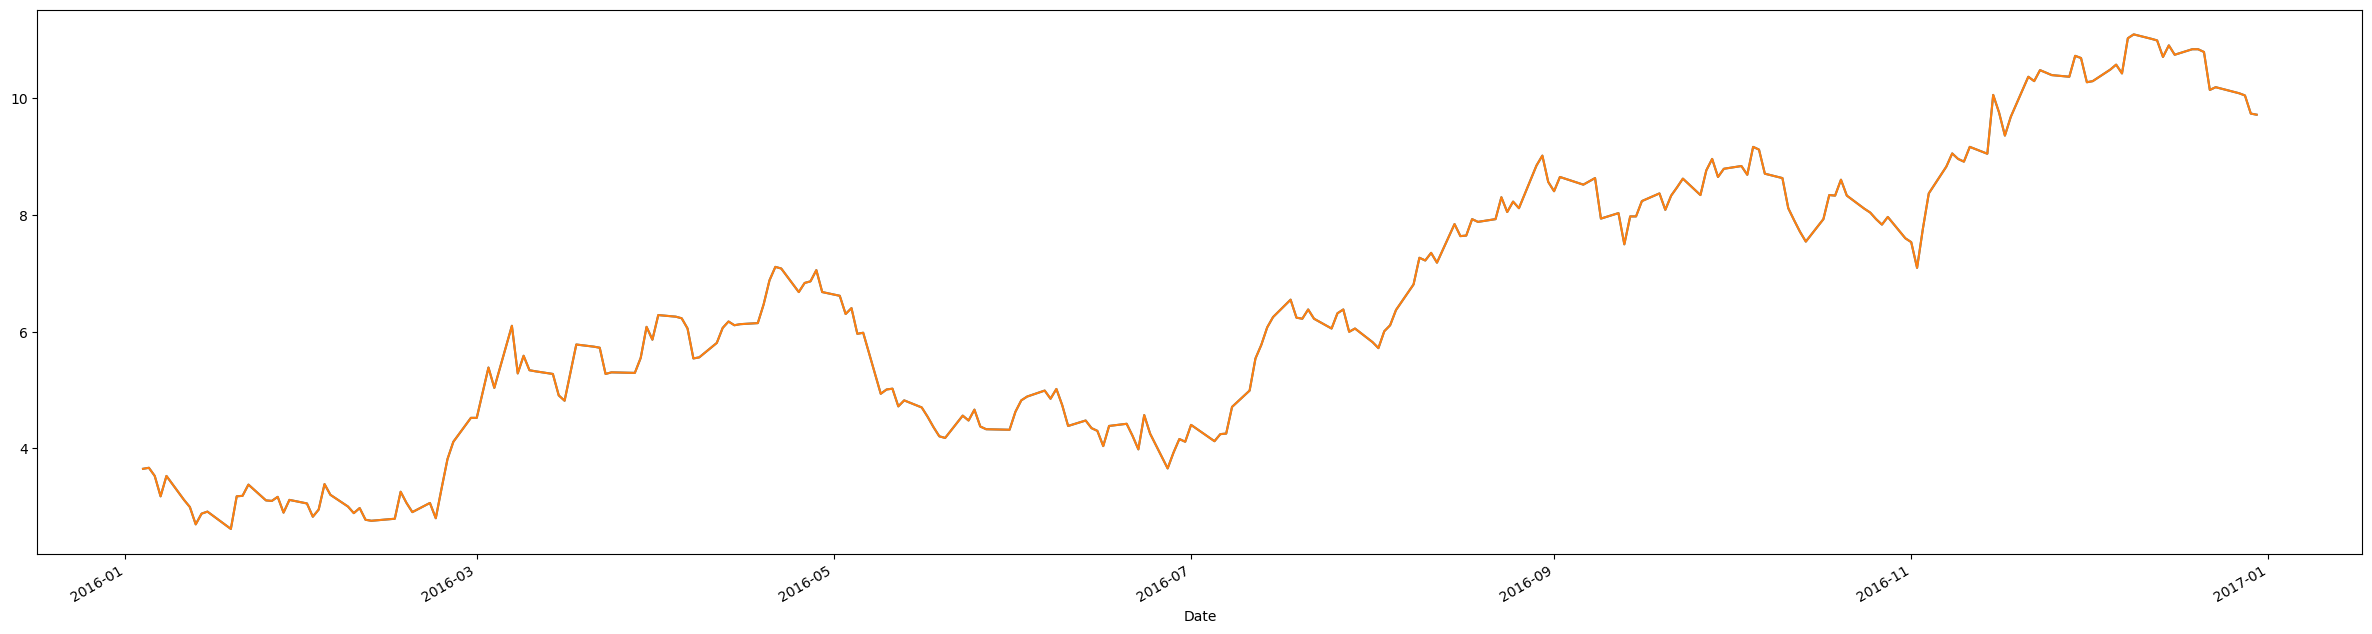

In [26]:
TROX_2016['Adj Close'].plot(figsize= [30, 8])
plt.show()

### Valeurs différenciées sur interval de 1 jours ("First difference")

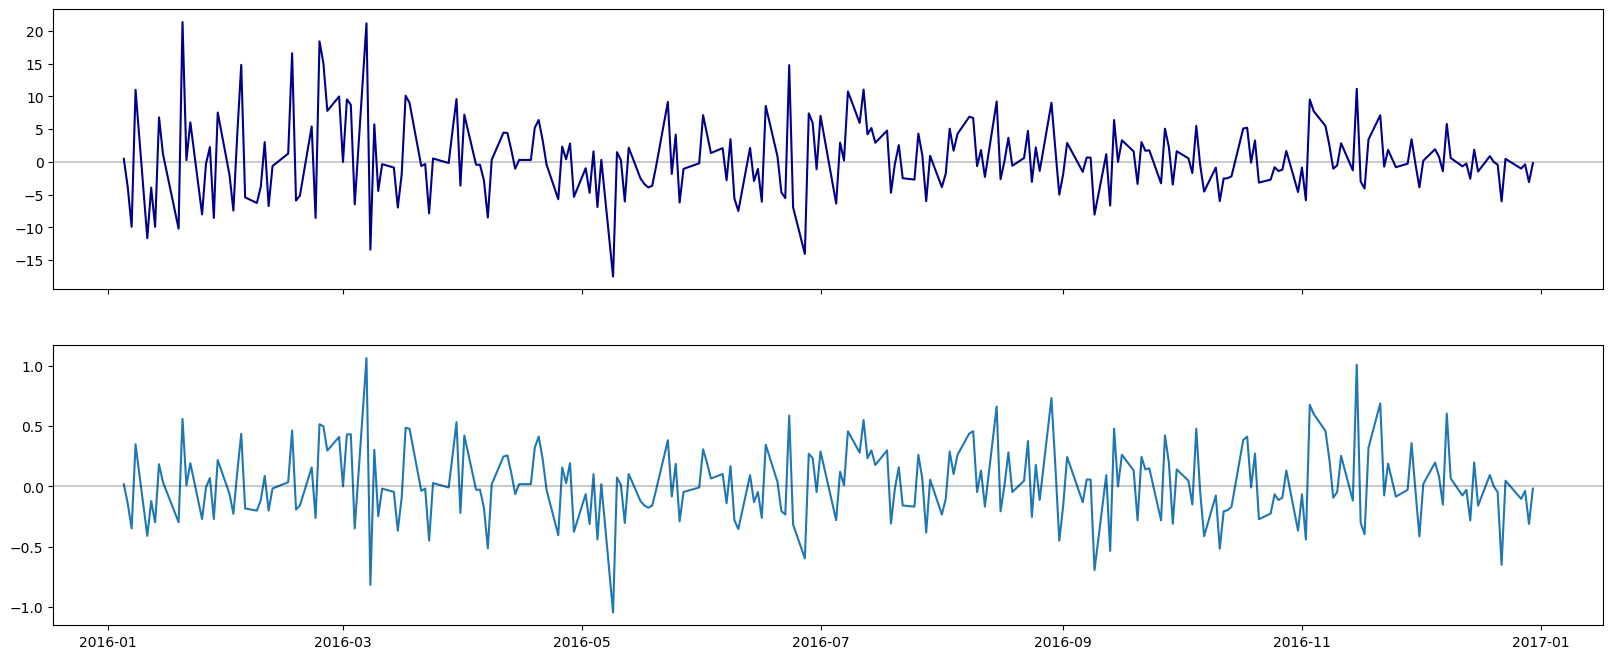

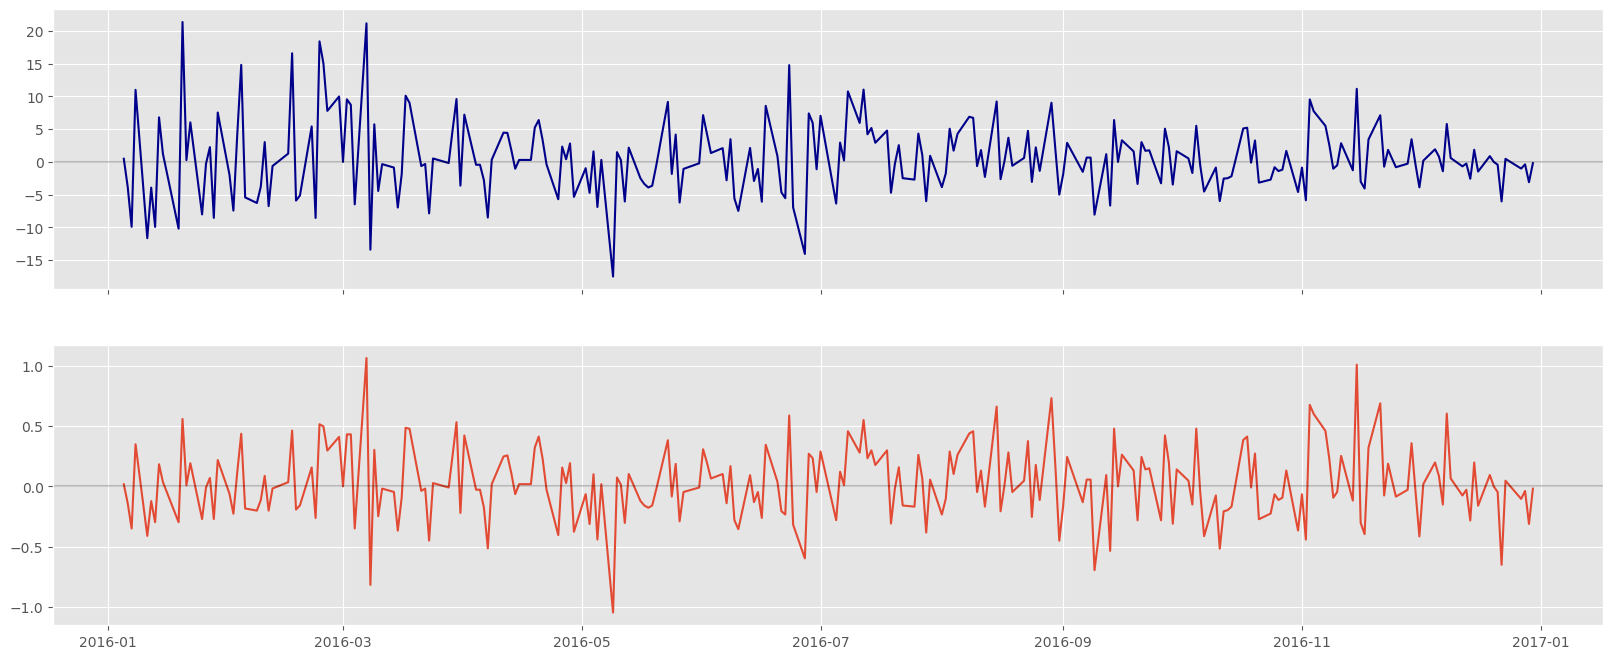

In [57]:
TROX_2016_diff = TROX_2016['Adj Close'].diff()
TROX_2016_rtn = TROX_2016['Adj Close'].pct_change()*100
TROX_2016_diff.dropna(inplace= True)
TROX_2016_rtn.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

ax[0].plot(TROX_2016_rtn.index, TROX_2016_rtn, color= 'darkblue')
ax[1].plot(TROX_2016_diff.index, TROX_2016_diff)
ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
plt.show()

#### Est-ce un random walk?

In [31]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(TROX_2016_rtn)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("Le adf p-value est de: {:.15f}".format(adf[1]))

Le adf p-value est de: 0.000000000000000


L'hypothèse nul peut être rejetée. 
Le court de Boing n'est `PAS`un random walk.

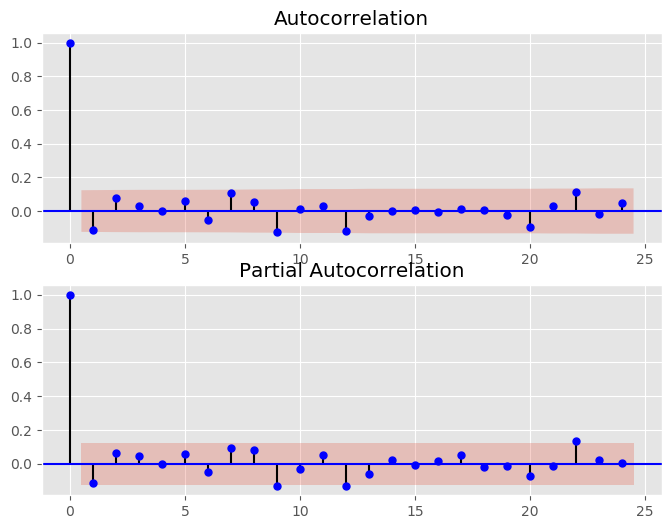

In [58]:
plot_corr_function(TROX_2016_rtn)
plt.show()

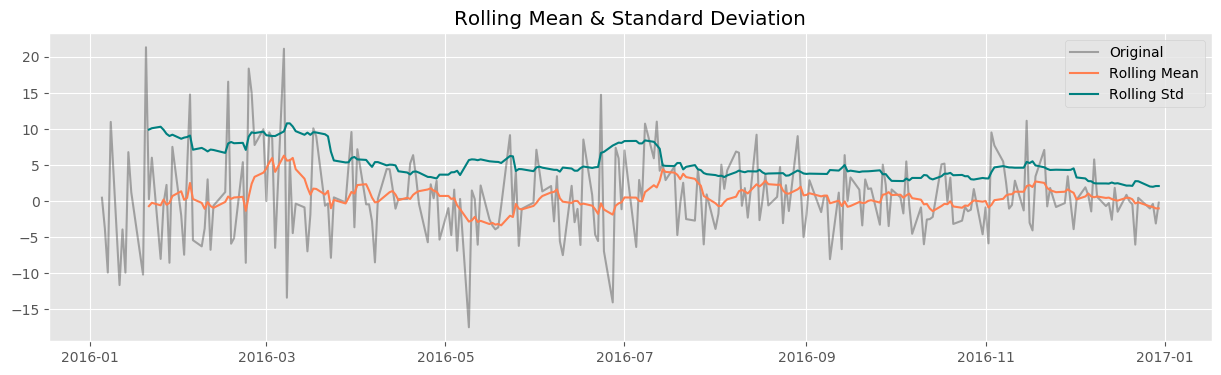

Mean MinMax Delta: 9.666665252498653
Std MinMax Delta: 8.79342757028939
ADF Statistic: -17.627531271124695
p-value: 3.812313775675885e-30
Critical Values:
	1%: -3.456780859712
	5%: -2.8731715065600003
	10%: -2.572968544


In [34]:
get_stationarity(TROX_2016_rtn)

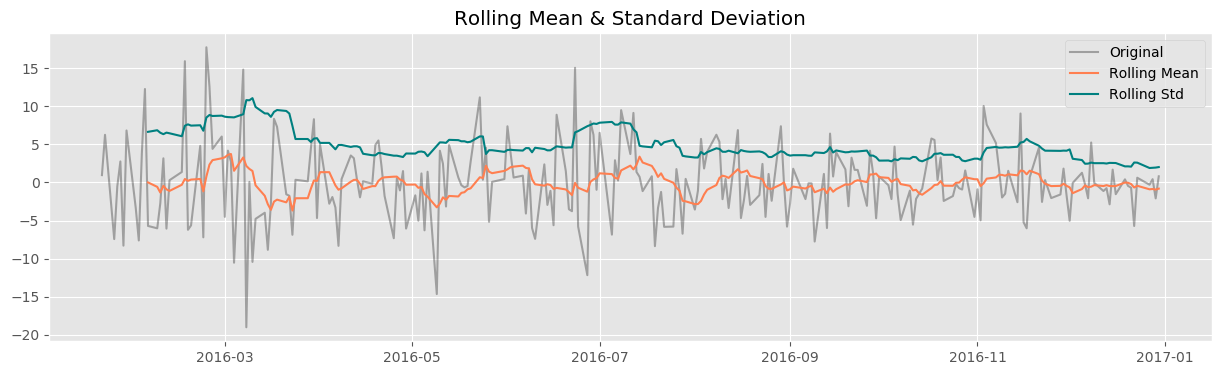

Mean MinMax Delta: 7.420962081689154
Std MinMax Delta: 9.172366057772358
ADF Statistic: -6.445248498051421
p-value: 1.57174675652863e-08
Critical Values:
	1%: -3.4593607492757554
	5%: -2.8743015807562924
	10%: -2.5735714042782396


In [44]:
# Transform to stationary x - rolling mean
TROX_2016_rtn_minus_mean = tfrm_to_MinusMean(TROX_2016_rtn)
# Assess transformed dataset performances
get_stationarity(TROX_2016_rtn_minus_mean)

L'échantillon 2016 différencier % de 1 - le rolling avg est hautement stationnaire.

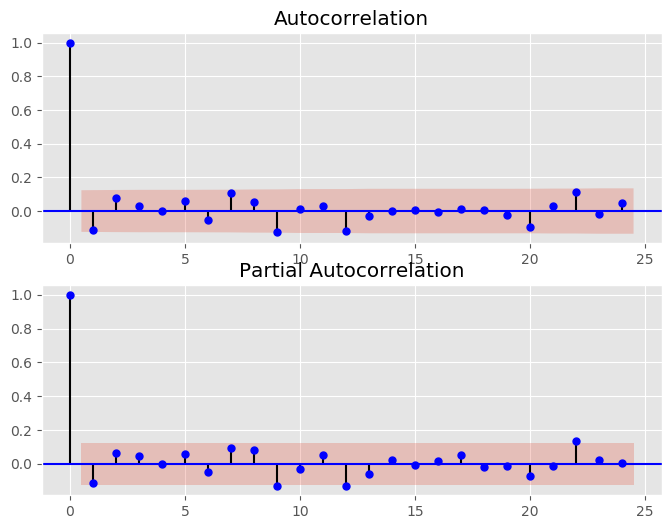

In [48]:
plot_corr_function(TROX_2016_rtn)
plt.show()

L'échantillon 2016 différencier % de 1 + stdev (- le rolling avg )
n'a aucune auto-corellation significative. L'ordre de AR optimal n'est donc pas important (Partial Autocorrolation).

### Valeurs différenciées sur interval de 4 jours

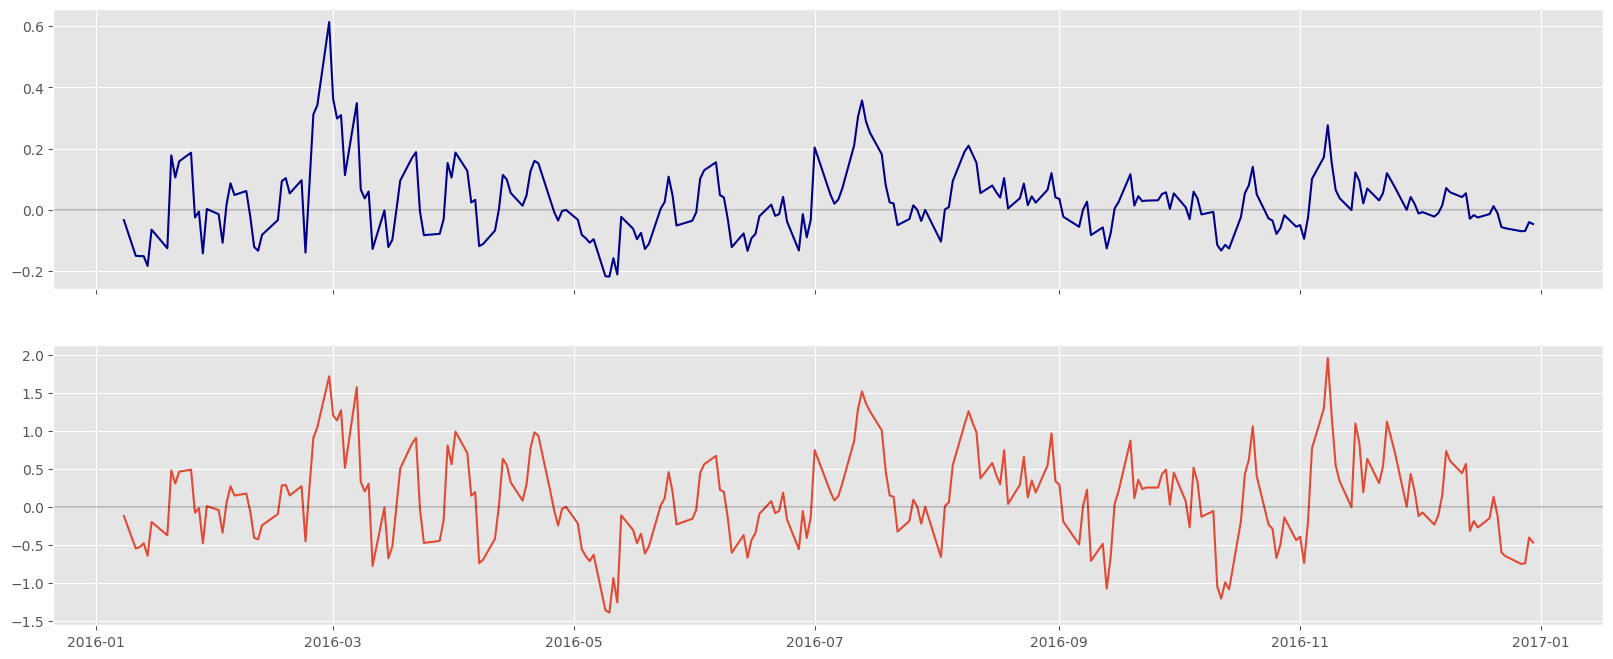

In [59]:
TROX_2016_diff4 = TROX_2016['Adj Close'].diff(4)
TROX_2016_rtn4 = TROX_2016['Adj Close'].pct_change(4)
TROX_2016_diff4.dropna(inplace= True)
TROX_2016_rtn4.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

ax[0].plot(TROX_2016_rtn4.index, TROX_2016_rtn4, color= 'darkblue')
ax[1].plot(TROX_2016_diff4.index, TROX_2016_diff4)
ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
plt.show()


#### Est-ce un random walk?

In [52]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(TROX_2016_rtn4)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("le adf p-value est de: {:.5f}".format(adf[1]))

le adf p-value est de: 0.00425


L'hypothèse nul peut être rejetée. 
Le court de Boing diff 4 n'est `PAS`un random walk.

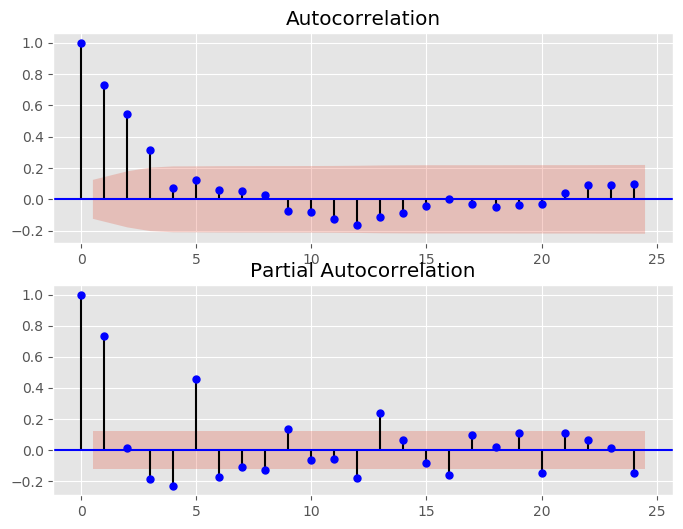

In [60]:
plot_corr_function(TROX_2016_rtn4)
plt.show()

### Valeurs différenciées sur interval de 5 jours

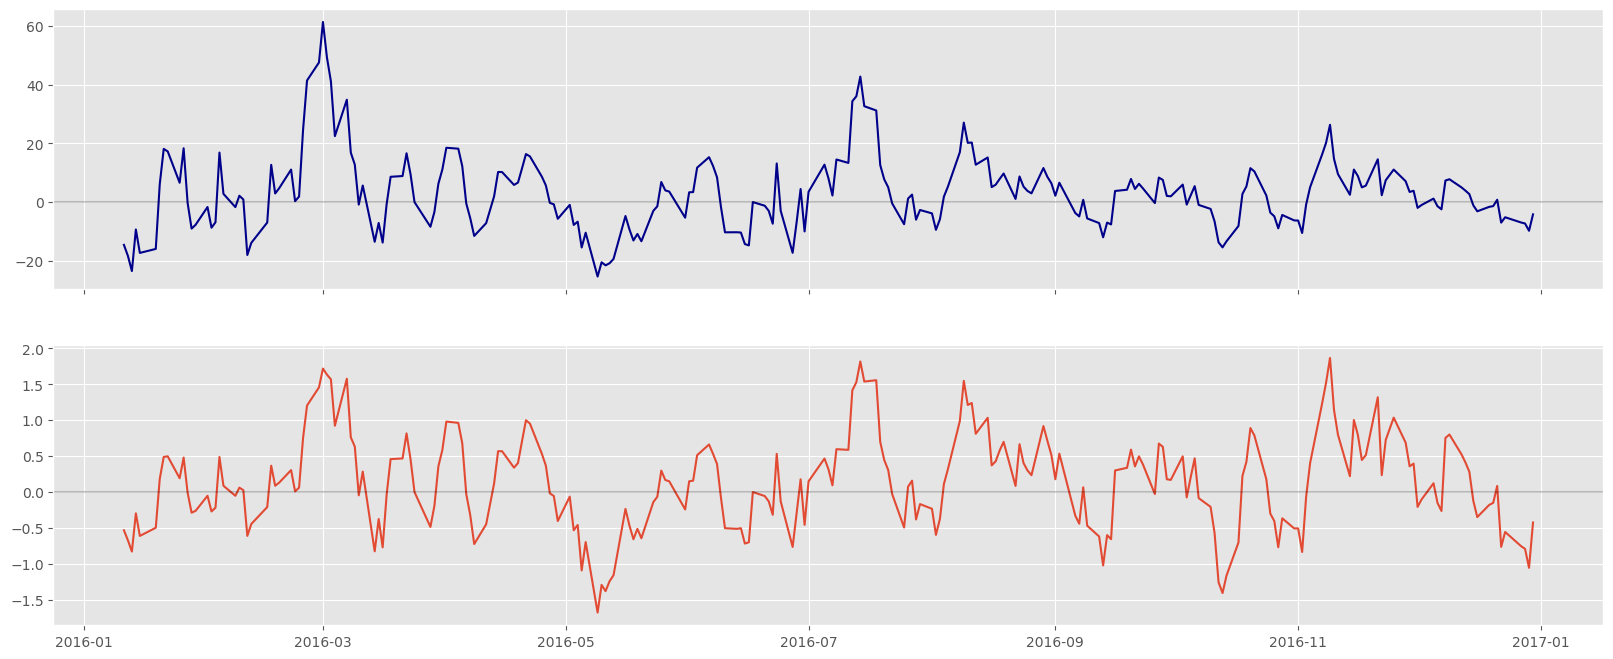

In [64]:
TROX_2016_diff5 = TROX_2016['Adj Close'].diff(5)
TROX_2016_diff5.dropna(inplace= True)
# Tranform to stationary returns with seasonal of 5
TROX_2016_rtn5 = TROX_2016['Adj Close'].pct_change(5)*100
TROX_2016_rtn5.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

ax[0].plot(TROX_2016_rtn5.index, TROX_2016_rtn5, color= 'darkblue')
ax[1].plot(TROX_2016_diff5.index, TROX_2016_diff5)
ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
plt.show()

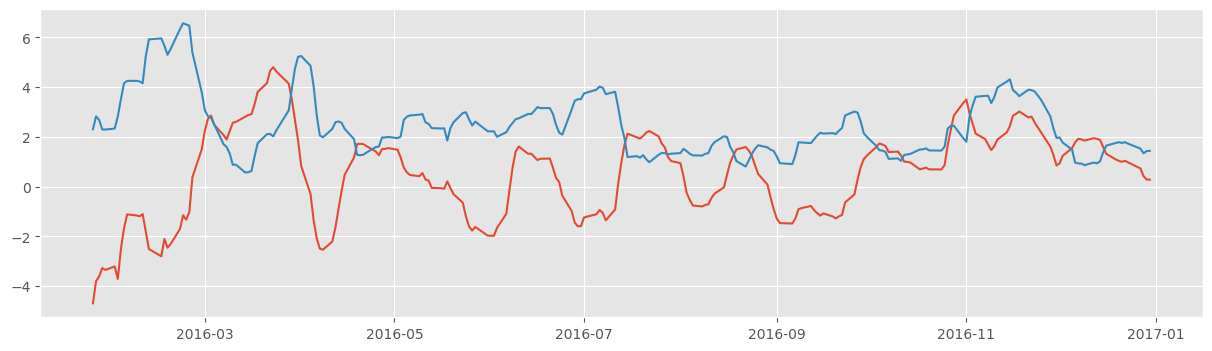

In [487]:
# See get_stationarity function below for more complete output.
TROX_2016_rtn5_ravg = TROX_2016_rtn5.rolling(10).mean()
TROX_2016_rtn5_rstd = TROX_2016_rtn5.rolling(10).std()
fig= plt.figure(figsize= (15, 4))
_ = plt.plot(TROX_2016_rtn5_ravg)
_ = plt.plot(TROX_2016_rtn5_rstd)

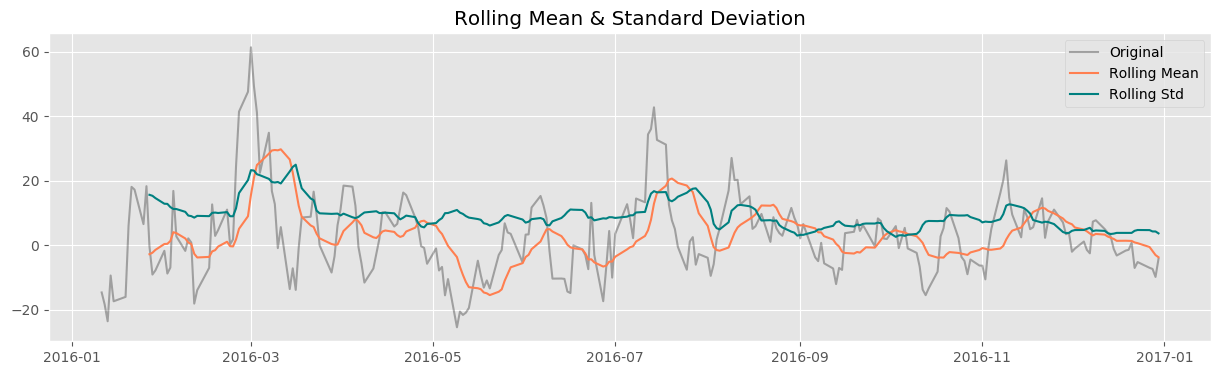

Mean MinMax Delta: 45.17411751845478
Std MinMax Delta: 22.35905403387769
ADF Statistic: -3.730524788448959
p-value: 0.003703716802799086
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


In [65]:
get_stationarity(TROX_2016_rtn5)

### rtn5 stdev (minus rolling mean) transformation

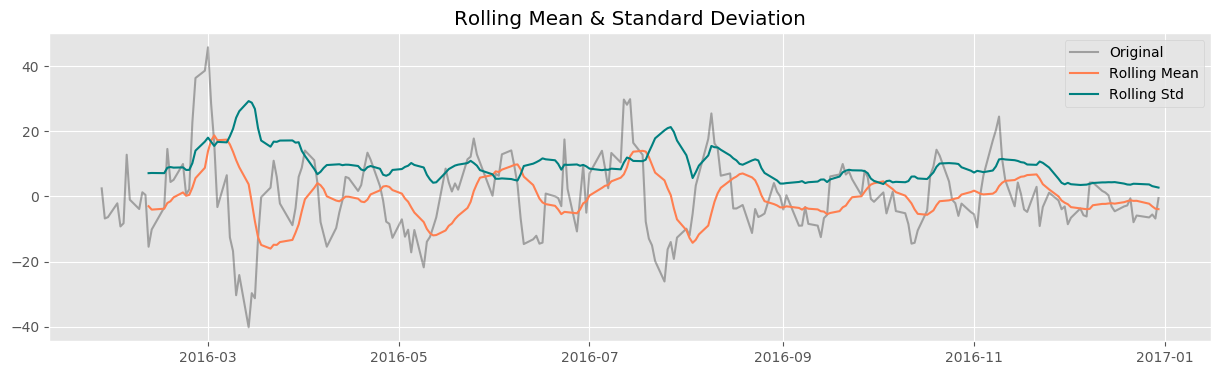

Mean MinMax Delta: 34.72470358645604
Std MinMax Delta: 26.52465348909484
ADF Statistic: -4.969031124403169
p-value: 2.5547883160083986e-05
Critical Values:
	1%: -3.4597521044060353
	5%: -2.874472927517147
	10%: -2.5736628197530864


In [135]:
# Transform to stationary x - rolling mean deviation
TROX_2016_rtn5_stdev, df_ravg_t = tfrm_to_MinusMean(TROX_2016_rtn5)
# Assess transformed dataset performances
get_stationarity(TROX_2016_rtn5_stdev)

#### Est-ce un random walk?

In [67]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(TROX_2016_rtn5)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("Le adf p-value est de: {:.5f}".format(adf[1]))

Le adf p-value est de: 0.00370


L'hypothèse nul peut être rejetée. 
Le court de Boing diff 5 n'est `PAS`un random walk.

In [68]:
plot_corr_function(TROX_2016_rtn5_stdev)

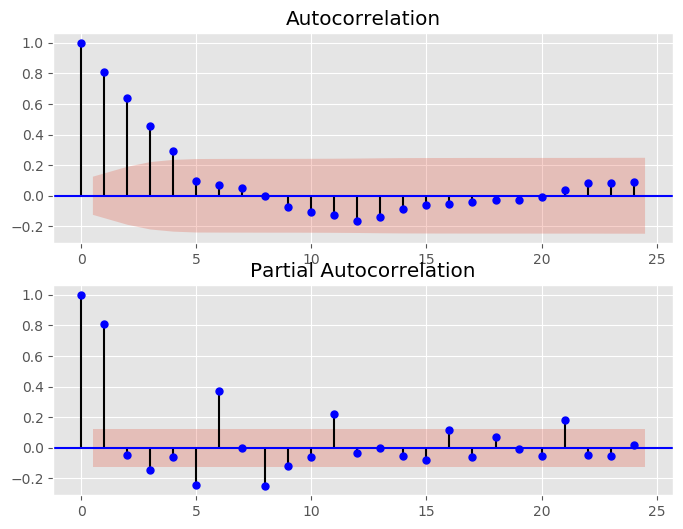

In [70]:
plot_corr_function(TROX_2016_rtn5)
plt.show()

### rtn5 avec Exponential decay

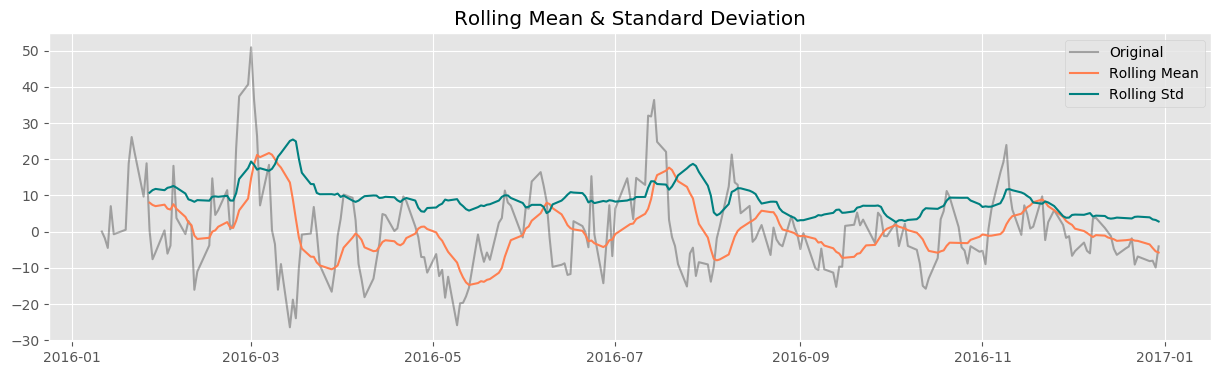

Mean MinMax Delta: 36.44832289118839
Std MinMax Delta: 22.806975537678348
ADF Statistic: -4.245910580950336
p-value: 0.000550416032322218
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


In [71]:
rolling_mean_exp_decay = TROX_2016_rtn5.ewm(halflife=12, min_periods=0, adjust=True).mean()
TROX_2016_rtn5_exp_decay = TROX_2016_rtn5 - rolling_mean_exp_decay
TROX_2016_rtn5_exp_decay.dropna(inplace=True)
get_stationarity(TROX_2016_rtn5_exp_decay)

Non proTROXnt

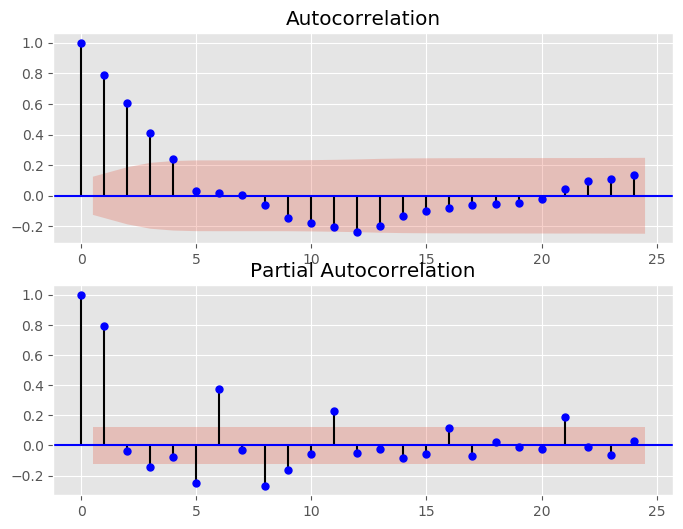

In [73]:
plot_corr_function(TROX_2016_rtn5_exp_decay)
plt.show()

### Log + exponential decay

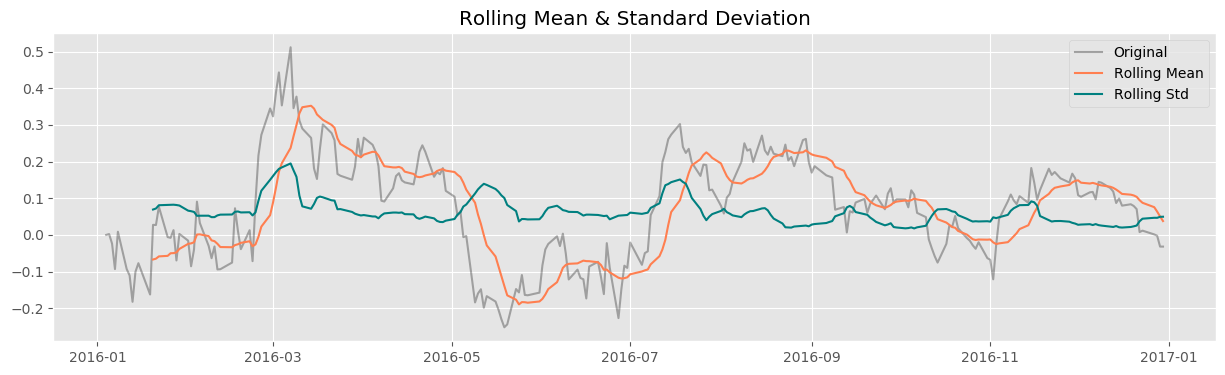

Mean MinMax Delta: 0.541482464626184
Std MinMax Delta: 0.1771760215887366
ADF Statistic: -2.981411008520517
p-value: 0.03666722366880788
Critical Values:
	1%: -3.4566744514553016
	5%: -2.8731248767783426
	10%: -2.5729436702592023


In [72]:
TROX_2016_rtn_log = np.log(TROX_2016['Adj Close'])
rolling_mean_exp_decay = TROX_2016_rtn_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
TROX_2016_rtn_log_exp_decay = TROX_2016_rtn_log - rolling_mean_exp_decay
#TROX_2016_diff_log_exp_decay.dropna(inplace=True)
get_stationarity(TROX_2016_rtn_log_exp_decay)

Non proTROXnt

## Recherche des paramètres ARMA optimales

### Akaike Information Criterion comme loss function à minimiser
Trouver le paramètre optimal en minimisant le loss function (ici le AIC)

In [557]:
#TROX_2016_rtn5.index = pd.DatetimeIndex(TROX_2016_rtn5.index).to_period('W') # Nécessaire pour forcaster

print('TROX_2016 différence de % de 5')

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(TROX_2016_rtn5, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

mod_ar2 = ARMA(TROX_2016_rtn5, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

mod_ar6 = ARMA(TROX_2016_rtn5, order=(6, 0))
res_ar6 = mod_ar6.fit()
print("The AIC for an AR(6) is: ", res_ar6.aic)

mod_arma11 = ARMA(TROX_2016_rtn5, order=(1, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

mod_arma61 = ARMA(TROX_2016_rtn5, order=(6, 1))
res_arma61 = mod_arma61.fit()
print("The AIC for an ARMA(6,1) is: ", res_arma61.aic)

mod_arma62 = ARMA(TROX_2016_rtn5, order=(6, 2))
res_arma62 = mod_arma62.fit()
print("The AIC for an ARMA(6,2) is: ", res_arma62.aic)

mod_arma63 = ARMA(TROX_2016_rtn5, order=(6, 3))
res_arma63 = mod_arma63.fit()
print("The AIC for an ARMA(6,3) is: ", res_arma63.aic)
print(res_arma63.arparams)

mod_arma33 = ARMA(TROX_2016_rtn5, order=(3, 3))
res_arma33 = mod_arma33.fit()
print("The AIC for an ARMA(3,3) is: ", res_arma33.aic)

BA_2016 différence de % de 5
The AIC for an AR(1) is:  1069.3890998977547
The AIC for an AR(2) is:  1061.86111028426
The AIC for an AR(6) is:  1007.8767502930812
The AIC for an ARMA(1,1) is:  1064.3505631109426
The AIC for an ARMA(6,1) is:  1009.1441115683888
The AIC for an ARMA(6,2) is:  997.8824857385599
The AIC for an ARMA(6,3) is:  990.3006337163781
[ 8.79103121e-01 -5.27461331e-01  8.60115727e-04  3.24973673e-01
 -4.92348957e-01  2.86821109e-01]
The AIC for an ARMA(3,3) is:  1014.7325256395362


In [79]:
print('TROX_2016 différence de % de 5 et stdev', '\n')

_= AIC(TROX_2016_rtn5_stdev, order=(1, 0))
_= AIC(TROX_2016_rtn5_stdev, order=(2, 0))
_= AIC(TROX_2016_rtn5_stdev, order=(2, 3))
_= AIC(TROX_2016_rtn5_stdev, order=(6, 0))
_= AIC(TROX_2016_rtn5_stdev, order=(1, 1))
_= AIC(TROX_2016_rtn5_stdev, order=(6, 1))
_= AIC(TROX_2016_rtn5_stdev, order=(6, 2))
_= AIC(TROX_2016_rtn5_stdev, order=(6, 3))
_= AIC(TROX_2016_rtn5_stdev, order=(3, 3))
#_= AIC(TROX_2016_rtn5_stdev, order=(11, 3))

TROX_2016 différence de % de 5 et meanDev 

The AIC for an ARMA(1, 0) is:  1599 
The AIC for an ARMA(2, 0) is:  1599 
The AIC for an ARMA(2, 3) is:  1558 
The AIC for an ARMA(6, 0) is:  1553 
The AIC for an ARMA(1, 1) is:  1600 
The AIC for an ARMA(6, 1) is:  1552 
The AIC for an ARMA(6, 2) is:  1551 
The AIC for an ARMA(6, 3) is:  1528 
The AIC for an ARMA(3, 3) is:  1566 


In [84]:
_ = AIC(TROX_2016_rtn5_stdev, order=(5, 5))

The AIC for an ARMA(5, 5) is:  1482 


In [81]:
_ = AIC(TROX_2016_rtn5_stdev, order=(4, 5))

The AIC for an ARMA(4, 5) is:  1483 


In [138]:
_ = AIC(TROX_2016_rtn5_stdev, order=(6, 3))

The AIC for an ARMA(6, 3) is:  1528 


In [140]:
_ = AIC(TROX_2016_rtn5_stdev, order=(6, 5))

The AIC for an ARMA(6, 5) is:  1484 


In [141]:
_ = AIC(TROX_2016_rtn5_stdev, order=(6, 6))

The AIC for an ARMA(6, 6) is:  1485 


In [142]:
_ = AIC(TROX_2016_rtn5_stdev, order=(5, 6))

The AIC for an ARMA(5, 6) is:  1482 


In [149]:
_ = AIC(TROX_2016_rtn5_stdev, order=(3,0,6))

The AIC for an ARMA(3, 0, 6) is:  1482 


In [153]:
_ = AIC(TROX_2016_rtn5_stdev, order=(1,0,6))

The AIC for an ARMA(1, 0, 6) is:  1482 


In [159]:
_ = AIC(TROX_2016_rtn5_stdev, order=(6,0,4))

The AIC for an ARMA(6, 0, 4) is:  1525 


In [160]:
_ = AIC(TROX_2016_rtn5_stdev, order=(1,0,4))

The AIC for an ARMA(1, 0, 4) is:  1489 


In [162]:
_ = AIC(TROX_2016_rtn5_stdev, order=(5,0,4))

The AIC for an ARMA(5, 0, 4) is:  1497 


In [75]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = aic_optimize(TROX_2016_rtn5_stdev, ar_max_range= 5, ma_max_range= 9)

The AIC for an ARMA(0, 0) is:  1839 
The AIC for an ARMA(0, 1) is:  1707 
The AIC for an ARMA(0, 2) is:  1625 
The AIC for an ARMA(0, 3) is:  1627 
The AIC for an ARMA(0, 4) is:  1487 
The AIC for an ARMA(0, 5) is:  1489 
The AIC for an ARMA(0, 6) is:  1491 
The AIC for an ARMA(0, 7) is:  1492 
The AIC for an ARMA(0, 8) is:  1494 
The AIC for an ARMA(1, 0) is:  1599 
The AIC for an ARMA(1, 1) is:  1600 
The AIC for an ARMA(1, 2) is:  1597 
The AIC for an ARMA(1, 3) is:  1574 
The AIC for an ARMA(1, 4) is:  1489 
The AIC for an ARMA(1, 5) is:  1480 
The AIC for an ARMA(1, 6) is:  1482 
The AIC for an ARMA(1, 7) is:  1482 
The AIC for an ARMA(1, 8) is:  1483 
The AIC for an ARMA(2, 0) is:  1599 
The AIC for an ARMA(2, 1) is:  1574 
The AIC for an ARMA(2, 2) is:  1576 
The AIC for an ARMA(2, 3) is:  1558 
The AIC for an ARMA(2, 4) is:  1491 
The AIC for an ARMA(2, 5) is:  1482 
The AIC for an ARMA(2, 6) is:  1479 
The AIC for an ARMA(2, 7) is:  1479 
The AIC for an ARMA(2, 8) is:  1481 
T

LinAlgError: SVD did not converge

In [76]:
plt.figure(figsize= (8, 5))
_= plt.plot(aic_16_5_var[0:11], color='indigo', label='ARMA(0, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[11:22], color='salmon', label='ARMA(1, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[22:33], color='black', label='ARMA(2, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[33:44], color='gold', label='ARMA(3, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[44:55], color='olive', label='ARMA(4, x)', alpha= 0.5)
_= plt.legend(loc='best')
_= plt.title('AIC de modèles ARMA sur une série de paramètres ')

NameError: name 'aic_16_5_var' is not defined

In [77]:
print("L'AIC optimal est: {:5.0f}".format(min(aic_16_5_var)))

NameError: name 'aic_16_5_var' is not defined

ARMA(3,6)

## One-step prediction sur un rolling window de valeurs historiques

### Mise au point du rolling window

In [507]:
r = rolling_window(np.array(TROX_2016_rtn5_stdev), 100)
r.shape

(137, 100)

In [592]:
print('{:.3f}, {:.3f}, {:.3f}, {:.3f}'.format(r[0][0], r[1][0], r[2][0], r[3][0]))

-0.396, -0.458, 0.074, 1.215


In [509]:
TROX_2016_rtn5_stdev.head()

Date
2016-01-27   -0.395910
2016-01-28   -0.457966
2016-01-29    0.073807
2016-02-01    1.215154
2016-02-02   -4.559695
Name: Adj Close, dtype: float64

In [510]:
TROX_2016_rtn5_stdev.shape

(236,)

In [511]:
# print(r[0][0:10])
print(TROX_2016_rtn5_stdev.iloc[101:116])

Date
2016-06-21   -0.399940
2016-06-22    0.125174
2016-06-23    2.231846
2016-06-24   -2.894954
2016-06-27   -6.882093
2016-06-28   -4.383446
2016-06-29   -2.032384
2016-06-30   -1.021066
2016-07-01    3.853257
2016-07-05    4.304216
2016-07-06    3.011811
2016-07-07    0.845250
2016-07-08    0.923926
2016-07-11    2.518628
2016-07-12    3.748161
Name: Adj Close, dtype: float64


In [593]:
mod_arma_t = ARIMA(r[0], order= (1,0,5)) # Trainé un modèle sur la fenêtre #0
res_arma_t = mod_arma_t.fit()
pred_arma_t = res_arma_t.predict(end= len(r[0]) + 1)
print('{:.3f}'.format(pred_arma_t[101]))

-0.206


In [594]:
mod_arma_t = ARIMA(r[15], order= (1,0,5)) # Trainé un modèle sur la fenêtre #15
res_arma_t = mod_arma_t.fit()

# Predict  days after training
pred_arma_t = res_arma_t.predict(end= len(r[15]) + 1)
print('{:.3f}'.format(pred_arma_t[100]))

2.769


In [525]:
len(pred_arma_t)
pred_arma_t[101]

2.8725838555802983

## One-step forecast

### Mise au point d'un DataFrame pour comparer les valeur prédites vs les valeurs historiques

In [532]:
# Créer un df à partir de l'entré #100 pour compenser le rolling window.
TROX_2016_rtn5_stdev_pred = pd.DataFrame(TROX_2016_rtn5_stdev.iloc[100::])

# Créer une liste de np.arrays de valeurs n=100 d'une fenêtre roulante
r = rolling_window(np.array(TROX_2016_rtn5_stdev), 100)

# Init d'une liste de prédictions
pred_col = []

for i in r:
    mod_arma_t = ARIMA(i, order= (1,0,5))
    res_arma_t = mod_arma_t.fit()
    
    # Prédire 1 jour au-delà du dataset
    pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
    # Ajouter la prédiction à la liste
    pred_col.append(pred_arma_t[100]) 
    
TROX_2016_rtn5_stdev_pred['Prediction'] = pred_col[0:-1]
TROX_2016_rtn5_stdev_pred['Erreur'] = TROX_2016_rtn5_stdev_pred['Adj Close'] - TROX_2016_rtn5_stdev_pred['Prediction']

In [541]:
TROX_2016_rtn5_stdev_pred

Adj Close  Prediction  Delta_REELvsPRED
Date                                               
2016-06-20   1.186224   -0.194232          1.380456
2016-06-21  -0.399940    0.769234         -1.169174
2016-06-22   0.125174    0.465439         -0.340266
2016-06-23   2.231846    0.986427          1.245419
2016-06-24  -2.894954    1.655745         -4.550699
...               ...         ...               ...
2016-12-23   0.930929    0.769600          0.161328
2016-12-27  -0.284424    0.324260         -0.608684
2016-12-28  -1.054649    0.492951         -1.547599
2016-12-29  -1.637316   -1.113810         -0.523506
2016-12-30  -1.295008   -1.019936         -0.275073

[136 rows x 3 columns]

### Exploration graphique des premiers résultats

Moyenne du delta Réel vs Prédiction: -0.008 
Écart type du delta Réel vs Prédiction: 1.159
Écart type des données: 2.293


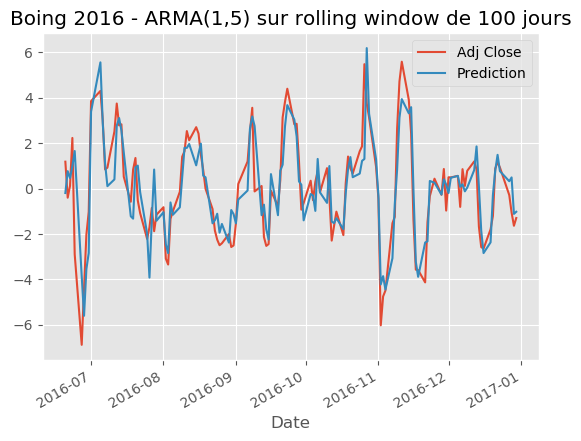

In [658]:
print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(TROX_2016_rtn5_stdev_pred['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}".format(TROX_2016_rtn5_stdev_pred['Erreur'].std()))
print("Écart type des données: {:.3f}".format(TROX_2016_rtn5_stdev_pred['Adj Close'].std()))
_= TROX_2016_rtn5_stdev_pred[['Adj Close', 'Prediction']].plot()
_= plt.title('Boing 2016 - ARMA(1,5) sur rolling window de 100 jours')

In [835]:
forecast_accuracy(TROX_2016_rtn5_stdev_pred['Erreur'], TROX_2016_rtn5_stdev_pred['Adj Close'])

{'mape': 1.996155160431836,
 'me': -0.015205425546572037,
 'mae': 1.5746438182235172,
 'mpe': 0.34990758876067857,
 'rmse': 2.031808284247016,
 'corr': 0.4595612788272259,
 'minmax': 1.749972941204741}

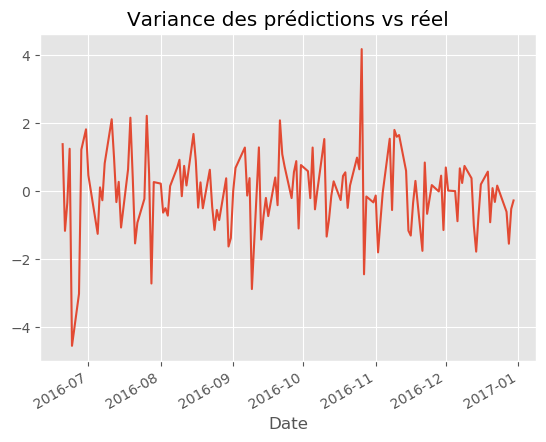

In [659]:
_ = TROX_2016_rtn5_stdev_pred['Erreur'].plot()
_= plt.title('stdev des prédictions vs réel')

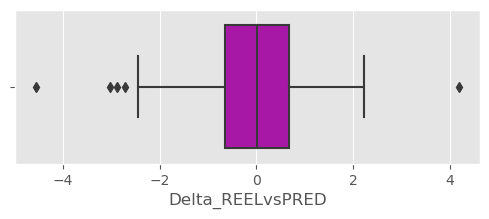

In [538]:
fig= plt.figure(figsize= (6, 2))
_ = sns.boxplot(x= 'Erreur', palette=["m", "g"],
            data= TROX_2016_rtn5_stdev_pred)

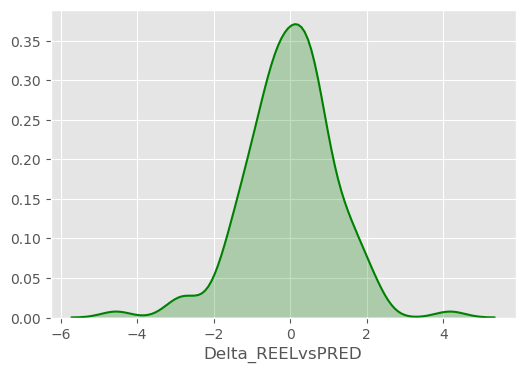

In [539]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(TROX_2016_rtn5_stdev_pred['Erreur'], hist=False, color="g", kde_kws={"shade": True})

In [531]:
TROX_2016_rtn5_stdev_pred_rw150 = pd.DataFrame(TROX_2016_rtn5_stdev.iloc[150::])

# Créer une liste de np.arrays de valeurs n=150 d'une fenêtre roulante
r = rolling_window(np.array(TROX_2016_rtn5_stdev), 150)

# Init d'une liste de prédictions
pred_col = []

for i in r:
    mod_arma_t = ARIMA(i, order= (1,0,5))
    res_arma_t = mod_arma_t.fit()
    
    # Prédire 1 jour au-delà du dataset
    pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
    # Ajouter la prédiction à la liste
    pred_col.append(pred_arma_t[150]) 
    
TROX_2016_rtn5_stdev_pred_rw150['Prediction'] = pred_col[0:-1]
TROX_2016_rtn5_stdev_pred_rw150['Erreur'] = TROX_2016_rtn5_stdev_pred_rw150['Adj Close'] - TROX_2016_rtn5_stdev_pred_rw150['Prediction']


Moyenne du delta Réel vs Prédiction: 0.032 
Écart type du delta Réel vs Prédiction: 1.109
Écart type des données: 2.284


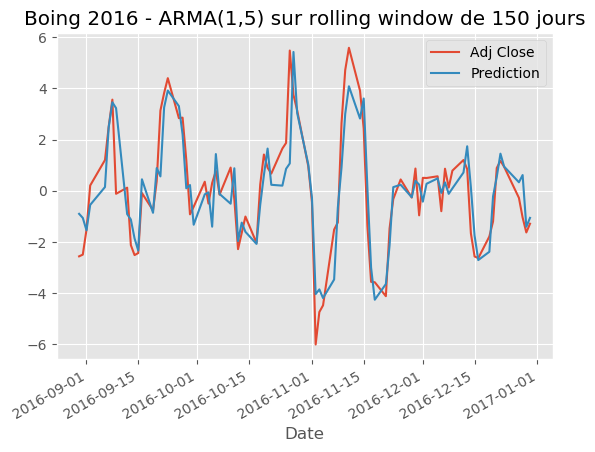

In [660]:
print("Mean Error (Moyenne du delta Réel vs Prédiction): {:.3f} ".format(TROX_2016_rtn5_stdev_pred_rw150['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}".format(TROX_2016_rtn5_stdev_pred_rw150['Erreur'].std()))
print("Écart type des données: {:.3f}".format(TROX_2016_rtn5_stdev_pred_rw150['Adj Close'].std()))
_= TROX_2016_rtn5_stdev_pred_rw150[['Adj Close', 'Prediction']].plot()
_= plt.title('Boing 2016 - ARMA(1,5) sur rolling window de 150 jours')

In [540]:
TROX_2016_rtn5_stdev_pred_rw150[TROX_2016_rtn5_stdev.iloc[:] == np.nan].any()

Adj Close           False
Prediction          False
Delta_REELvsPRED    False
dtype: bool

## Recherche du rolling window optimal

### Rolling window de 25 à 175 par incréments de 25

In [87]:
range1= list(np.arange(25, 176, 25))
ls_mean1= []
ls_std1= []

for i in range1:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(TROX_2016_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= i)
    ls_mean1.append(test_df_roll['Erreur'].mean())
    ls_std1.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('TROX_2016_rtn5_stdev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___TROX_2016_pct5_meanDev sur un Rolling window de: 25___
Moyenne du delta Réel vs Prédiction: -0.227 
Écart type du delta Réel vs Prédiction: 6.789
Écart type des données: 10.976
___TROX_2016_pct5_meanDev sur un Rolling window de: 50___
Moyenne du delta Réel vs Prédiction: -0.131 
Écart type du delta Réel vs Prédiction: 5.357
Écart type des données: 10.053
___TROX_2016_pct5_meanDev sur un Rolling window de: 75___
Moyenne du delta Réel vs Prédiction: 0.032 
Écart type du delta Réel vs Prédiction: 5.617
Écart type des données: 9.985
___TROX_2016_pct5_meanDev sur un Rolling window de: 100___
Moyenne du delta Réel vs Prédiction: 0.384 
Écart type du delta Réel vs Prédiction: 5.032
Écart type des données: 9.967
___TROX_2016_pct5_meanDev sur un Rolling window de: 125___
Moyenne du delta Réel vs Prédiction: -0.060 
Écart type du delta Réel vs Prédiction: 4.275
Écart type des données: 8.334
___TROX_2016_pct5_meanDev sur un Rolling window de: 150___
Moyenne du delta Réel vs Prédiction: -0.402 

In [627]:
ls_mean1= [-0.052, -0.033, -0.048, -0.008, 0.023, 0.032, 0.034]
ls_std1= [1.355, 1.266, 1.2, 1.159, 1.019, 1.109, 1.138]

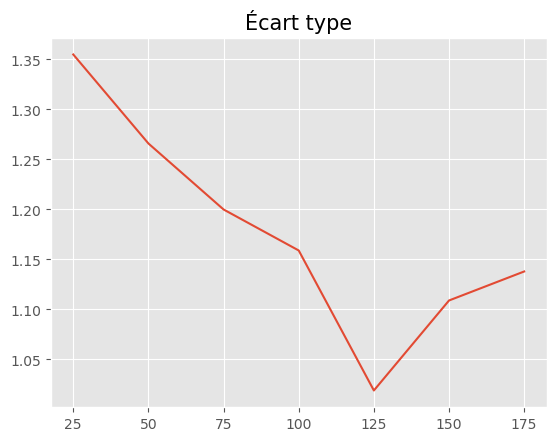

In [631]:
_= plt.plot(range, ls_std1)
_= plt.xticks(range1)
_= plt.title('Écart type: Rollwin 25-175, x25', fontsize= 15)

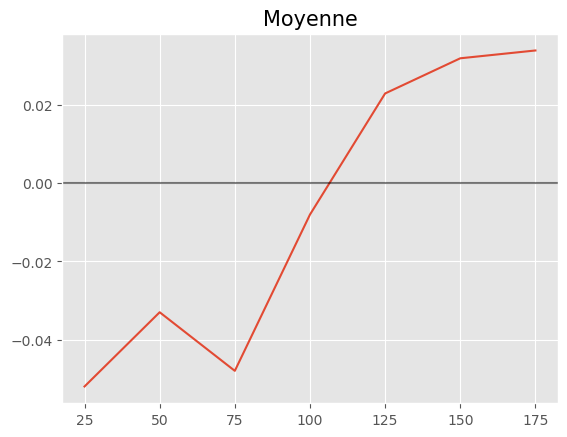

In [634]:

_= plt.plot(range, ls_mean1)
_= plt.xticks(range1)
_= plt.axhline(y= 0, linestyle='-', color='k', alpha= 0.5)
_= plt.title('Moyenne', fontsize= 15)

### Rolling window de 75 à 125 par incréments de 5

In [88]:
range= list(np.arange(75, 126, 5))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(TROX_2016_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('TROX_2016_rtn5_stdev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___TROX_2016_pct5_meanDev sur un Rolling window de: 75___
Moyenne du delta Réel vs Prédiction: 0.032 
Écart type du delta Réel vs Prédiction: 5.617
Écart type des données: 9.985
___TROX_2016_pct5_meanDev sur un Rolling window de: 80___
Moyenne du delta Réel vs Prédiction: 0.157 
Écart type du delta Réel vs Prédiction: 5.440
Écart type des données: 10.099
___TROX_2016_pct5_meanDev sur un Rolling window de: 85___
Moyenne du delta Réel vs Prédiction: 0.137 
Écart type du delta Réel vs Prédiction: 5.427
Écart type des données: 10.019
___TROX_2016_pct5_meanDev sur un Rolling window de: 90___
Moyenne du delta Réel vs Prédiction: 0.178 
Écart type du delta Réel vs Prédiction: 5.280
Écart type des données: 10.062
___TROX_2016_pct5_meanDev sur un Rolling window de: 95___
Moyenne du delta Réel vs Prédiction: 0.207 
Écart type du delta Réel vs Prédiction: 5.270
Écart type des données: 10.043
___TROX_2016_pct5_meanDev sur un Rolling window de: 100___
Moyenne du delta Réel vs Prédiction: 0.384 
Éca

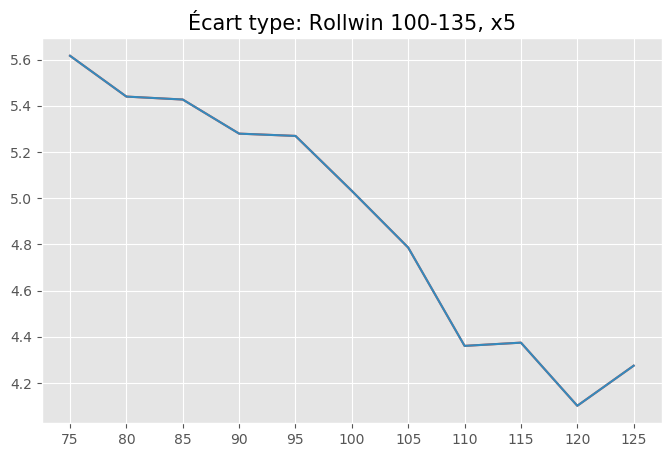

In [90]:
plt.plot(range, ls_std)
plt.xticks(range)
plt.title('Écart type: Rollwin 100-135, x5', fontsize= 15)
plt.show()

### Rollin window de 107 à 113 par incréments de 1

In [640]:
range= list(np.arange(107, 113, 1))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(TROX_2016_rtn5_stdev, ARIMA_order= (1, 0, 5), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('TROX_2016_rtn5_stdev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___BA_2016_pct5_variance sur un Rolling window de: 110___
Moyenne du delta Réel vs Prédiction: 0.030 
Écart type du delta Réel vs Prédiction: 1.029
Écart type des données: 2.204
___BA_2016_pct5_variance sur un Rolling window de: 112___
Moyenne du delta Réel vs Prédiction: 0.063 
Écart type du delta Réel vs Prédiction: 1.004
Écart type des données: 2.173
___BA_2016_pct5_variance sur un Rolling window de: 114___
Moyenne du delta Réel vs Prédiction: 0.050 
Écart type du delta Réel vs Prédiction: 1.010
Écart type des données: 2.188
___BA_2016_pct5_variance sur un Rolling window de: 116___
Moyenne du delta Réel vs Prédiction: 0.035 
Écart type du delta Réel vs Prédiction: 0.990
Écart type des données: 2.167
___BA_2016_pct5_variance sur un Rolling window de: 118___
Moyenne du delta Réel vs Prédiction: 0.034 
Écart type du delta Réel vs Prédiction: 0.990
Écart type des données: 2.153
___BA_2016_pct5_variance sur un Rolling window de: 120___
Moyenne du delta Réel vs Prédiction: 0.011 
Écart ty

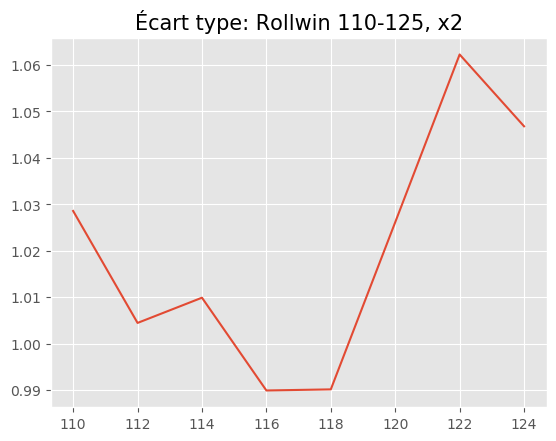

In [806]:
_= plt.plot(range, ls_std)
_= plt.xticks(range)
_= plt.title('Écart type: Rollwin 110-125, x2', fontsize= 15)

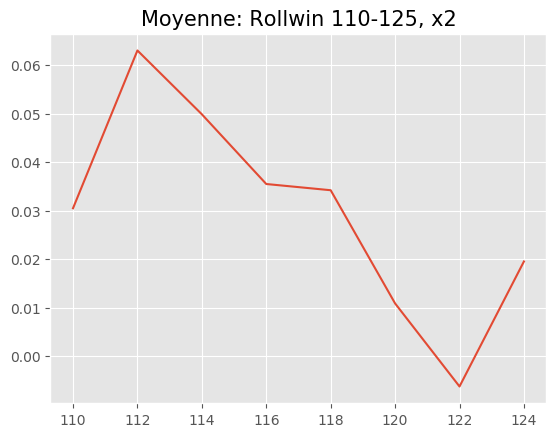

In [642]:
_= plt.plot(range, ls_mean)
_= plt.xticks(range)
_= plt.title('Moyenne: Rollwin 110-125, x2', fontsize= 15)

In [747]:
TROX_2016_rtn5_stdev = TROX_2016_rtn5 - df_ravg_t
TROX_2016_rtn5_stdev.dropna(inplace= True)
#TROX_2016_rtn5_stdev.head()

In [91]:
df_ravg_t

NameError: name 'df_ravg_t' is not defined

In [278]:
df_roll_temp= rolwin_ARIMA(TROX_2016_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= 110)

In [279]:
df_ravg_t = TROX_2016_rtn5.rolling(12).mean()
#TROX_2016_rtn5_stdev['RollAvg12']= df_ravg_t.loc['2016-07-15': :]
TROX_2016_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_t.loc['2016-07-15': :], TROX_2016_rtn5.loc['2016-07-15': :]], axis= 1)
TROX_2016_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']
# Selon système d'équation résolut sur papier
TROX_2016_rtn5_stdev['Pred_rtn5'] = TROX_2016_rtn5_stdev['rtn5'] - TROX_2016_rtn5_stdev['Erreur']
#TROX_2016_rtn5_stdev['∆_rtn5vsPred_rtn5'] = TROX_2016_rtn5_stdev['rtn5'] - TROX_2016_rtn5_stdev['Pred_rtn5']

In [280]:
TROX_2016_rtn5_stdev.dropna(inplace= True)
TROX_2016_rtn5_stdev.head(15)

pct5_var   Pred_var    Erreur  RollAvg12_pct5       pct5  \
Date                                                                    
2016-07-15  16.443146  18.541228 -2.098082       16.230090  32.673235   
2016-07-18  12.754422  11.934102  0.820320       18.460534  31.214956   
2016-07-19  -7.719775  -4.689602 -3.030173       20.346057  12.626282   
2016-07-20 -12.945401  -9.560408 -3.384993       20.699862   7.754462   
2016-07-21 -14.990230 -18.194487  3.204257       20.059361   5.069130   
2016-07-22 -19.796774 -14.992288 -4.804486       19.349048  -0.447725   
2016-07-25 -26.082897 -20.649631 -5.433266       18.533049  -7.549848   
2016-07-26 -16.227498 -21.819102  5.591604       17.423329   1.195831   
2016-07-27 -13.974735 -15.430995  1.456260       16.523433   2.548698   
2016-07-28 -19.152322 -15.721256 -3.431066       13.158164  -5.994158   
2016-07-29 -12.628274 -10.361053 -2.267220        9.929615  -2.698659   
2016-08-01  -9.897095  -6.387107 -3.509988        6.045010  -3.852085   
2016-08-02 -11.987938 -13.929818  1.941880        2.534450  -9.453488   
2016-08-03  -5.293829  -8.111572  2.817744       -0.554126  -5.847955   
2016-08-04   3.317063   1.284781  2.032282       -1.450794   1.866269   

            Pred_pct5  
Date                   
2016-07-15  34.771317  
2016-07-18  30.394636  
2016-07-19  15.656454  
2016-07-20  11.139454  
2016-07-21   1.864874  
2016-07-22   4.356761  
2016-07-25  -2.116582  
2016-07-26  -4.395773  
2016-07-27   1.092438  
2016-07-28  -2.563092  
2016-07-29  -0.431438  
2016-08-01  -0.342097  
2016-08-02 -11.395368  
2016-08-03  -8.665699  
2016-08-04  -0.166013

In [ ]:
TROX_2016_rtn5_stdev.to_csv('Tronox_2016')

Moyenne du delta Réel vs Prédiction: -0.283% 
Écart type du delta Réel vs Prédiction: 4.029%
____________________________
Retour moyen réel: 3.004% 
Retour moyen prédit: 3.286% 
Écart type des retours réels: 8.953%
Écart type des retours prédits: 8.894% 


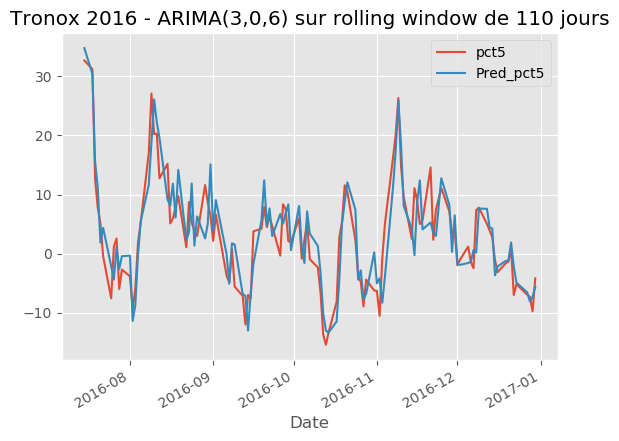

In [281]:
print("Moyenne du delta Réel vs Prédiction: {:.3f}% ".format(TROX_2016_rtn5_stdev['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}%".format(TROX_2016_rtn5_stdev['Erreur'].std()))
print('____________________________')
print("Retour moyen réel: {:.3f}% ".format(TROX_2016_rtn5_stdev['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(TROX_2016_rtn5_stdev['Pred_rtn5'].mean()))
print("Écart type des retours réels: {:.3f}%".format(TROX_2016_rtn5_stdev['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(TROX_2016_rtn5_stdev['Pred_rtn5'].std()))
TROX_2016_rtn5_stdev[['rtn5', 'Pred_rtn5']].plot()
plt.title('Tronox 2016 - ARIMA(3,0,6) sur rolling window de 110 jours')
plt.show()

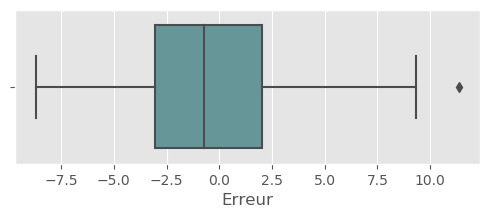

In [106]:
fig= plt.figure(figsize= (6, 2))
sns.boxplot(x= 'Erreur', palette=["cadetblue", "g"],
            data= TROX_2016_rtn5_stdev)
plt.show()

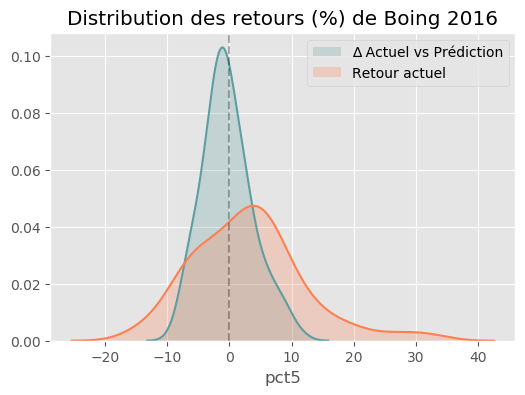

In [107]:
fig= plt.figure(figsize= (6, 4))
sns.distplot(TROX_2016_rtn5_stdev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
sns.distplot(TROX_2016_rtn5_stdev['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
plt.title('Distribution des retours (%) de Boing 2016')
plt.show()

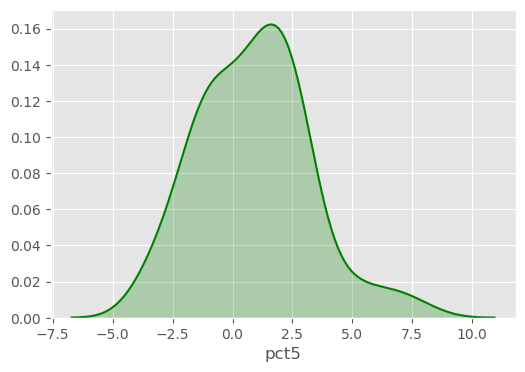

In [782]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(TROX_2016_rtn5_stdev['rtn5'], hist=False, color="g", kde_kws={"shade": True})

In [108]:
TROX_2016_rtn5_stdev['Erreur_Dir'] = ((TROX_2016_rtn5_stdev['rtn5'] < 0) & (TROX_2016_rtn5_stdev['Pred_rtn5'] > 0)) | ((TROX_2016_rtn5_stdev['rtn5'] > 0) & (TROX_2016_rtn5_stdev['Pred_rtn5'] < 0))


In [109]:
TROX_2016_rtn5_stdev.head()

pct5_var   Pred_var    Erreur  RollAvg12_pct5       pct5  \
Date                                                                    
2016-07-15  16.443146  18.541228 -2.098082       16.230090  32.673235   
2016-07-18  12.754422  11.934102  0.820320       18.460534  31.214956   
2016-07-19  -7.719775  -4.689602 -3.030173       20.346057  12.626282   
2016-07-20 -12.945401  -9.560408 -3.384993       20.699862   7.754462   
2016-07-21 -14.990230 -18.194487  3.204257       20.059361   5.069130   

            Pred_pct5  Erreur_Dir  
Date                               
2016-07-15  34.771317       False  
2016-07-18  30.394636       False  
2016-07-19  15.656454       False  
2016-07-20  11.139454       False  
2016-07-21   1.864874       False

In [110]:
TROX_2016_rtn5_stdev['Erreur_Dir'].value_counts(normalize= True)

False    0.864407
True     0.135593
Name: Erreur_Dir, dtype: float64

In [837]:
forecast_accuracy(TROX_2016_rtn5_stdev['Pred_rtn5'], TROX_2016_rtn5_stdev['rtn5'])

{'mape': 1.1706479315037432,
 'me': -0.03420810266274205,
 'mae': 0.7535509894540533,
 'mpe': -0.26136988106430864,
 'rmse': 0.9865811692281357,
 'corr': 0.9051119120393168,
 'minmax': 0.07517506356320258}

In [277]:
TROX_2016_rtn5_stdev.head()

Date
2016-01-27    2.467893
2016-01-28   -6.761134
2016-01-29   -6.353792
2016-02-01   -2.106355
2016-02-02   -9.204049
Name: Adj Close, dtype: float64

## Tronox 2016 nutshell

In [20]:
TROX_2016 = TROX.loc['2016']

# Tranform to stationary returns with seasonal of 5
TROX_2016_rtn5 = TROX_2016['Adj Close'].pct_change(5)*100
TROX_2016_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
TROX_2016_rtn5_stdev, df_ravg_temp = af.tfrm_to_MinusMean(TROX_2016_rtn5)

# Get temporary df of rolling averages
#df_ravg_temp = TROX_2016_rtn5.rolling(12).mean()
df_roll_temp= af.rollwin_ARIMA(TROX_2016_rtn5_stdev, ARIMA_order= (1, 0, 5), window_size= 118)

# Stiching all together
TROX_2016_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_temp.loc['2016-07-15': :], TROX_2016_rtn5.loc['2016-07-15': :]], axis= 1)
TROX_2016_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']

# Selon système d'équation résolut sur papier
TROX_2016_rtn5_stdev['Pred_rtn5'] = TROX_2016_rtn5_stdev['rtn5'] - TROX_2016_rtn5_stdev['Erreur']

In [21]:
TROX_2016_rtn5_stdev.head()

rtn5_var   Pred_var    Erreur  RollAvg12_rtn5       rtn5  \
Date                                                                    
2016-07-15  16.443146  17.723529 -1.280383       16.230090  32.673235   
2016-07-18  12.754422  12.656291  0.098131       18.460534  31.214956   
2016-07-19  -7.719775  -5.032416 -2.687359       20.346057  12.626282   
2016-07-20 -12.945401  -9.656094 -3.289307       20.699862   7.754462   
2016-07-21 -14.990230 -15.523844  0.533614       20.059361   5.069130   

            Pred_rtn5  
Date                   
2016-07-15  33.953618  
2016-07-18  31.116825  
2016-07-19  15.313641  
2016-07-20  11.043768  
2016-07-21   4.535517

In [22]:
TROX_2016_rtn5_stdev.shape

(118, 6)

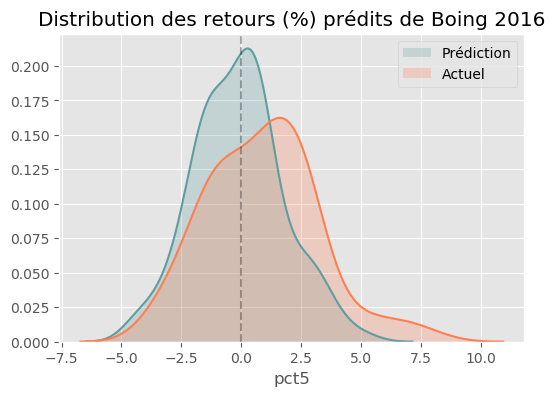

In [860]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(TROX_2016_rtn5_stdev['Pred_var'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(TROX_2016_rtn5_stdev['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('Prédiction', 'Actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) prédits de Boing 2016')

## Test du modèle sur Tronox 2017

In [3]:
TROX_2017 = TROX['2017']
TROX_2017_rtn5 = TROX_2017['Adj Close'].pct_change(5)*100
TROX_2017_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
TROX_2017_rtn5_stdev, df_ravg_temp = af.tfrm_to_MinusMean(TROX_2017_rtn5)

# Get temporary df of rolling averages
df_roll_temp= af.rollwin_ARIMA(TROX_2017_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= 110)

In [113]:
# Stiching all together
TROX_2017_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_t.loc['2017-07-17': :], TROX_2017_rtn5.loc['2017-07-17': :]], axis= 1)
TROX_2017_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']
# Selon système d'équation résolut sur papier
TROX_2017_rtn5_stdev['Pred_rtn5'] = TROX_2017_rtn5_stdev['rtn5'] - TROX_2017_rtn5_stdev['Erreur']

In [114]:
TROX_2017_rtn5_stdev

pct5_var  Pred_var    Erreur  RollAvg12_pct5      pct5  Pred_pct5
Date                                                                          
2017-07-05  12.550521  8.385331  4.165190             NaN       NaN        NaN
2017-07-06   5.902964  4.472194  1.430770             NaN       NaN        NaN
2017-07-07   8.780946  8.052087  0.728859             NaN       NaN        NaN
2017-07-10   2.217352 -2.484931  4.702283             NaN       NaN        NaN
2017-07-11   3.090093  1.017650  2.072443             NaN       NaN        NaN
...               ...       ...       ...             ...       ...        ...
2017-12-22   5.750978  5.095371  0.655607             NaN  0.199790  -0.455817
2017-12-26   4.120501  3.375634  0.744866             NaN -0.393111  -1.137977
2017-12-27   6.822608  4.904484  1.918124             NaN  4.239005   2.320881
2017-12-28   3.782622 -1.340823  5.123445             NaN  3.369660  -1.753785
2017-12-29   0.968238  3.822211 -2.853974             NaN  2.549993   5.403967

[125 rows x 6 columns]

Moyenne de l'erreur: 0.230% 
Écart type de l'erreur: 4.515%
____________________________
Retour moyen actuel: 1.092% 
Retour moyen prédit: 1.007% 
Écart type des retours actuels: 7.265%
Écart type des retours prédits: 7.370% 


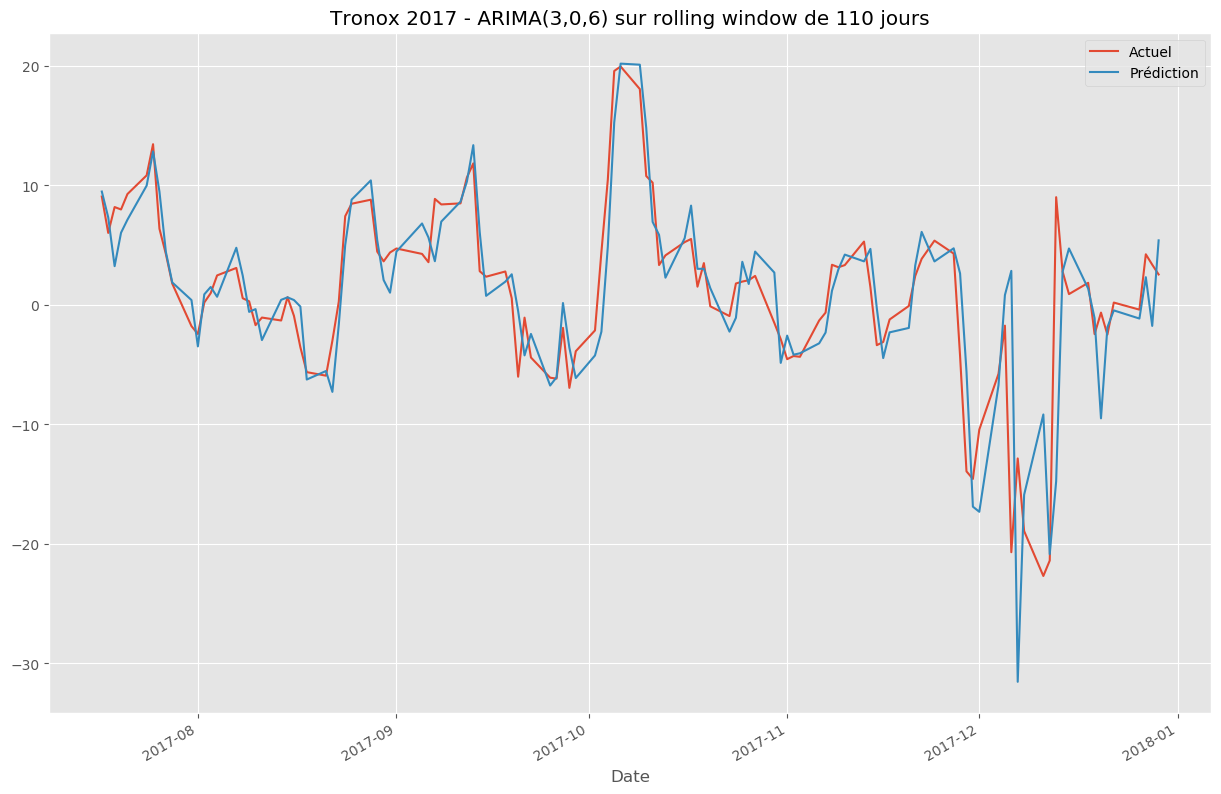

In [117]:
print("Moyenne de l'erreur: {:.3f}% ".format(TROX_2017_rtn5_stdev['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(TROX_2017_rtn5_stdev['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(TROX_2017_rtn5_stdev['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(TROX_2017_rtn5_stdev['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(TROX_2017_rtn5_stdev['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(TROX_2017_rtn5_stdev['Pred_rtn5'].std()))
TROX_2017_rtn5_stdev[['rtn5', 'Pred_rtn5']].plot(figsize= [15, 10])
plt.legend(('Actuel', 'Prédiction'))
plt.title('Tronox 2017 - ARIMA(3,0,6) sur rolling window de 110 jours')
plt.show()

In [118]:
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
TROX_2017_rtn5_stdev['Erreur_Dir'] = ((TROX_2017_rtn5_stdev['rtn5'] < 0) & (TROX_2017_rtn5_stdev['Pred_rtn5'] > 0)) | ((TROX_2017_rtn5_stdev['rtn5'] > 0) & (TROX_2017_rtn5_stdev['Pred_rtn5'] < 0))

In [119]:
# Quel est le ratio de prédictions dans la bonne direction (False)
TROX_2017_rtn5_stdev['Erreur_Dir'].value_counts(normalize= True)

False    0.872
True     0.128
Name: Erreur_Dir, dtype: float64

In [286]:
#TROX_2017_rtn5_stdev_toXport = TROX_2017_rtn5_stdev.drop(columns= 'RollAvg12_rtn5')
TROX_2017_rtn5_stdev_toXport.to_csv('TROX_2017_ARIMA(3,0,6)110.csv')

In [285]:
pwd

'/Users/jonathanbeaulieu/Documents/PROG/FinBoys'

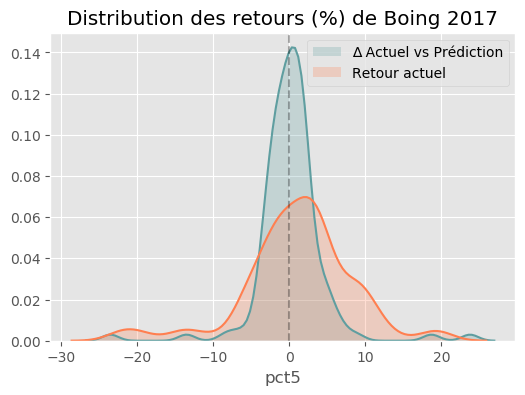

In [120]:
fig= plt.figure(figsize= (6, 4))
sns.distplot(TROX_2017_rtn5_stdev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
sns.distplot(TROX_2017_rtn5_stdev['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
plt.title('Distribution des retours (%) de Boing 2017')
plt.show()

## Test du modèle sur Tronox 2018

In [24]:
TROX_2018 = TROX['2018']
TROX_2018_rtn5 = TROX_2018['Adj Close'].pct_change(5)*100
TROX_2018_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean
TROX_2018_rtn5_stdev, df_ravg_temp = af.tfrm_to_MinusMean(TROX_2018_rtn5)

df_roll_temp= af.rollwin_ARIMA(TROX_2018_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= 110)

In [26]:
TROX_2018_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_temp.loc['2018-07-17': :], TROX_2018_rtn5.loc['2018-07-17': :]], axis= 1)
TROX_2018_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']
# Selon système d'équation résolut sur papier
TROX_2018_rtn5_stdev['Pred_rtn5'] = TROX_2018_rtn5_stdev['rtn5'] - TROX_2018_rtn5_stdev['Erreur']
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
TROX_2018_rtn5_stdev['Erreur_Dir'] = ((TROX_2018_rtn5_stdev['rtn5'] < 0) & (TROX_2018_rtn5_stdev['Pred_rtn5'] > 0)) | ((TROX_2018_rtn5_stdev['rtn5'] > 0) & (TROX_2018_rtn5_stdev['Pred_rtn5'] < 0))

Moyenne du delta Réel vs Prédiction: -0.062% 
Écart type du delta Réel vs Prédiction: 3.933%
____________________________
Retour moyen réel: -3.482% 
Retour moyen prédit: -3.508% 
Écart type des retours réels: 8.710%
Écart type des retours prédits: 8.111% 


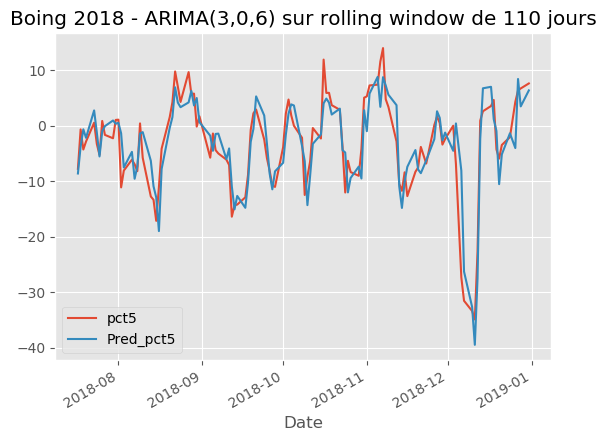

In [125]:
print("Moyenne du delta Réel vs Prédiction: {:.3f}% ".format(TROX_2018_rtn5_stdev['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}%".format(TROX_2018_rtn5_stdev['Erreur'].std()))
print('____________________________')
print("Retour moyen réel: {:.3f}% ".format(TROX_2018_rtn5_stdev['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(TROX_2018_rtn5_stdev['Pred_rtn5'].mean()))
print("Écart type des retours réels: {:.3f}%".format(TROX_2018_rtn5_stdev['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(TROX_2018_rtn5_stdev['Pred_rtn5'].std()))
TROX_2018_rtn5_stdev[['rtn5', 'Pred_rtn5']].plot()
plt.title('Boing 2018 - ARIMA(3,0,6) sur rolling window de 110 jours')
plt.show()

In [126]:
# Quel est le ratio de prédictions dans la bonne direction (False)
TROX_2018_rtn5_stdev['Erreur_Dir'].value_counts(normalize= True)

False    0.888
True     0.112
Name: Erreur_Dir, dtype: float64

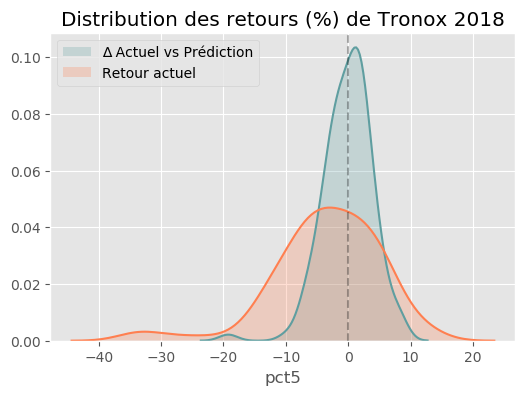

In [128]:
fig= plt.figure(figsize= (6, 4))
sns.distplot(TROX_2018_rtn5_stdev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
sns.distplot(TROX_2018_rtn5_stdev['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
plt.title('Distribution des retours (%) de Tronox 2018')
plt.show()

## Sharpe ratio
mesure du risque - 
return / écart type -
rendement sur

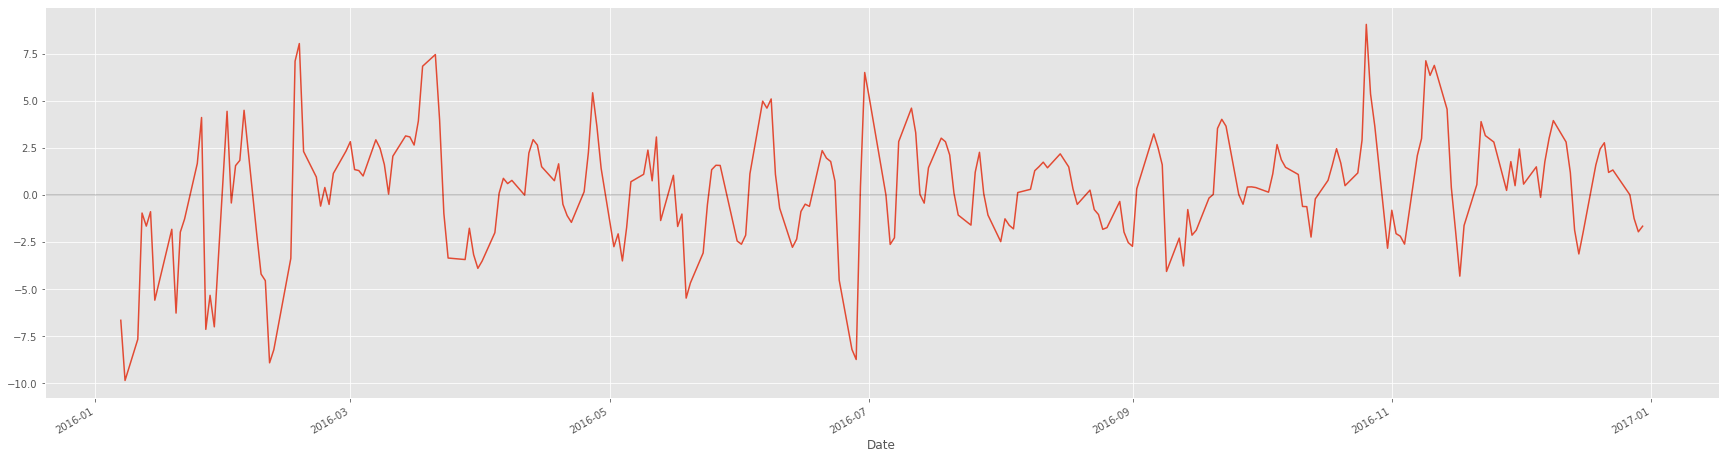

In [16]:
TROX_2016_diff3 = TROX_2016['Adj Close'].diff(3)
TROX_2016_diff3.dropna(inplace= True)
_ = TROX_2016_diff3.plot(figsize= [30, 8])
_ = plt.axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

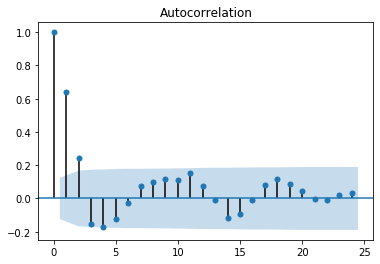

In [61]:
_ = plot_acf(TROX_2016_diff3) # _ = est un truc pour éviter d'imprimer 2x le même plot

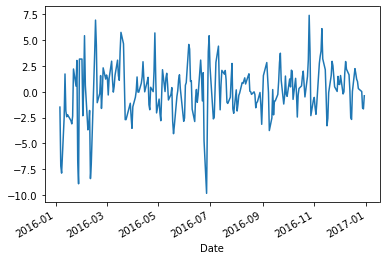

In [24]:
TROX_2016_diff2 = TROX_2016['Adj Close'].diff(2)
TROX_2016_diff2.plot()

In [871]:
TROX_2017b = TROX['2017']
TROX_2017_rtn5b = TROX_2017b['Adj Close'].pct_change(5)*100
TROX_2017_rtn5b.dropna(inplace= True)



In [872]:
TROX_2017_rtn5b

Date
2017-01-10    1.337829
2017-01-11    0.491712
2017-01-12   -0.264657
2017-01-13   -0.169730
2017-01-17   -0.410553
                ...   
2017-12-22    0.394648
2017-12-26   -0.263415
2017-12-27   -0.548380
2017-12-28   -0.520299
2017-12-29   -0.040670
Name: Adj Close, Length: 246, dtype: float64

In [ ]:
# Transform to stationary x - rolling mean deviation
TROX_2017_rtn5_stdevB, df_ravg_tempB = tfrm_to_MinusMean(TROX_2017_rtn5b)

In [883]:
TROX_2017_rtn5b['test'] = np.nan

In [884]:
TROX_2017_rtn5b

Date
2017-01-10 00:00:00      1.33783
2017-01-11 00:00:00     0.491712
2017-01-12 00:00:00    -0.264657
2017-01-13 00:00:00     -0.16973
2017-01-17 00:00:00    -0.410553
                         ...    
2017-12-26 00:00:00    -0.263415
2017-12-27 00:00:00     -0.54838
2017-12-28 00:00:00    -0.520299
2017-12-29 00:00:00   -0.0406702
test                         NaN
Name: Adj Close, Length: 247, dtype: object

## PMDarima test

In [129]:
import pmdarima as pm

In [155]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(TROX_2016['Adj Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=7, m=5,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,5) [intercept=True]; AIC=131.627, BIC=149.174, Time=0.644 seconds
Fit ARIMA(0,0,0)x(0,1,0,5) [intercept=True]; AIC=501.129, BIC=508.148, Time=0.062 seconds
Fit ARIMA(1,0,0)x(1,1,0,5) [intercept=True]; AIC=201.568, BIC=215.605, Time=0.211 seconds
Fit ARIMA(0,0,1)x(0,1,1,5) [intercept=True]; AIC=367.236, BIC=381.274, Time=0.174 seconds
Fit ARIMA(0,0,0)x(0,1,0,5) [intercept=False]; AIC=508.545, BIC=512.054, Time=0.016 seconds
Fit ARIMA(1,0,1)x(0,1,0,5) [intercept=True]; AIC=252.942, BIC=266.980, Time=0.147 seconds
Fit ARIMA(1,0,1)x(1,1,1,5) [intercept=True]; AIC=134.053, BIC=155.109, Time=0.890 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(1,0,1)x(0,1,2,5) [intercept=True]; AIC=132.676, BIC=153.732, Time=0.970 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 2, 5); setting score to in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  252
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 5)   Log Likelihood                 -61.327
Date:                             Fri, 10 Jul 2020   AIC                            130.653
Time:                                     23:28:04   BIC                            144.691
Sample:                                          0   HQIC                           136.305
                                             - 252                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0047      0.003      1.579      0.114      -0.001       0.010
ar.L1          0.9652      0.020     48.541      0.000       0.926       1.004
ma.S.L5       -0.9892      0.134     -7.395      0.000      -1.251      -0.727
sigma2         0.0900      0.011      8.148      0.000       0.068       0.112
===================================================================================
Ljung-Box (Q):                       28.12   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.92   Prob(JB):                         0.04
Heteroskedasticity (H):               1.06   Skew:                             0.23
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

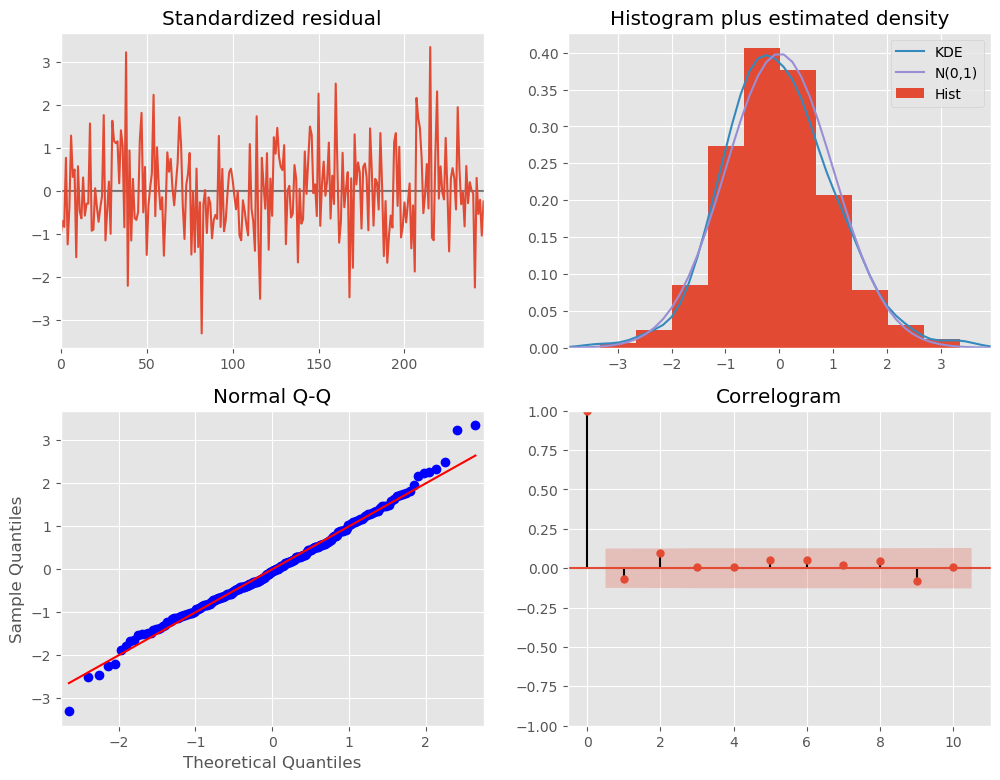

In [158]:
smodel.plot_diagnostics(figsize=(12,9))
plt.show()

In [164]:
# Seasonal - fit stepwise auto-ARIMA
model = pm.auto_arima(TROX_2016_rtn5, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=7, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1706.500, BIC=1720.537, Time=0.189 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1968.229, BIC=1975.248, Time=0.020 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1704.740, BIC=1715.268, Time=0.050 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1826.506, BIC=1837.034, Time=0.085 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1978.378, BIC=1981.888, Time=0.013 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=1706.420, BIC=1720.458, Time=0.068 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=1703.725, BIC=1721.272, Time=0.204 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=1699.660, BIC=1720.716, Time=0.210 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=1703.805, BIC=1721.352, Time=0.132 seconds
Fit ARIMA(4,0,1)x(0,0,0,0) [intercept=True]; AIC=1701.647, BIC=1726.213, Time=0.319 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  247
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -795.545
Date:                Sat, 11 Jul 2020   AIC                           1605.090
Time:                        10:09:12   BIC                           1629.655
Sample:                             0   HQIC                          1614.980
                                - 247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4265      2.072      1.171      0.242      -1.634       6.487
ar.L1         -0.0741      0.058     -1.288      0.198      -0.187       0.039
ma.L1          1.0188      0.395      2.581      0.010       0.245       1.792
ma.L2          1.0335      0.244      4.231      0.000       0.555       1.512
ma.L3          1.0170      0.362      2.808      0.005       0.307       1.727
ma.L4          0.9971      0.463      2.152      0.031       0.089       1.905
sigma2        34.3797     15.633      2.199      0.028       3.740      65.020
===================================================================================
Ljung-Box (Q):                       28.81   Jarque-Bera (JB):                32.56
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

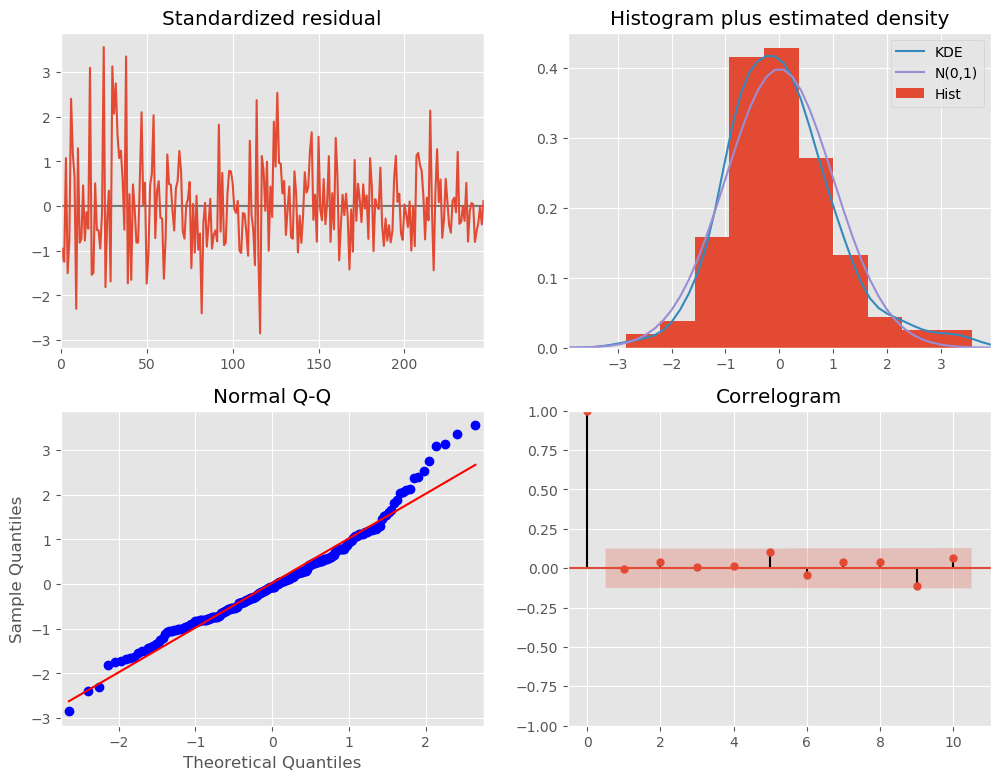

In [165]:
model.plot_diagnostics(figsize=(12,9))
plt.show()

In [62]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

# Return entry [0,1]
    return corr_mat[0,1]

In [257]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [208]:
TROX_2016_b = TROX_2016.copy()

In [209]:
TROX_2016_b['ac_rtn'] = TROX_2016_b['Adj Close'].pct_change()
TROX_2016_b['vol_rtn'] = TROX_2016_b['Volume'].pct_change()

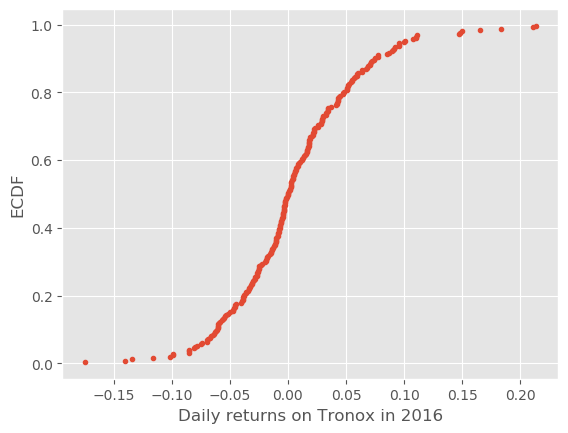

In [259]:
# Compute ECDF
x_ac_rtn, y_ac_rtn = ecdf(TROX_2016_b['ac_rtn'])

plt.plot(x_ac_rtn, y_ac_rtn, marker='.', linestyle='none')
_ = plt.xlabel('Daily returns on Tronox in 2016')
_ = plt.ylabel('ECDF')
plt.show()

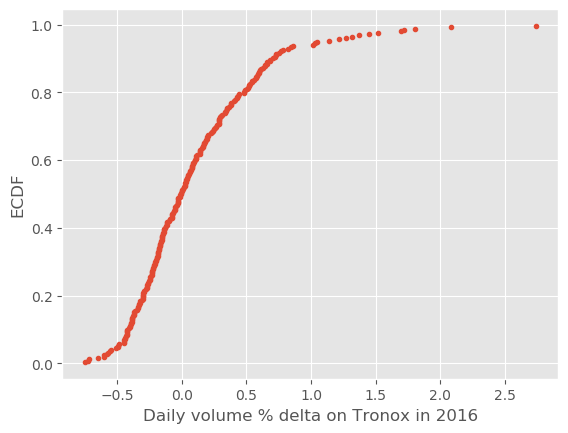

In [264]:
# Compute ECDF
x_ac_rtn, y_ac_rtn = ecdf(TROX_2016_b['vol_rtn'])

plt.plot(x_ac_rtn, y_ac_rtn, marker='.', linestyle='none')
_ = plt.xlabel('Daily volume % delta on Tronox in 2016')
_ = plt.ylabel('ECDF')
plt.show()

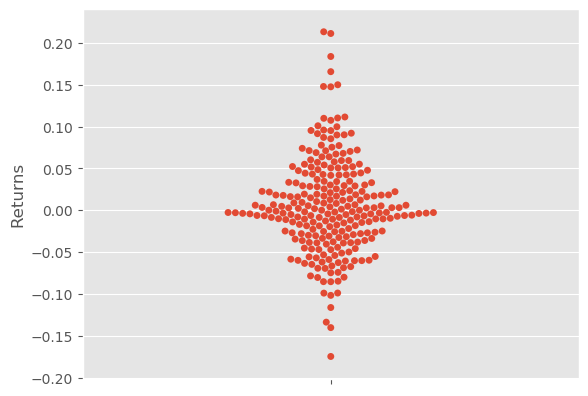

In [261]:
# Create bee swarm plot with Seaborn's default settings
sns.swarmplot(data= TROX_2016_b, y='ac_rtn')
plt.ylabel('Returns')
plt.show()

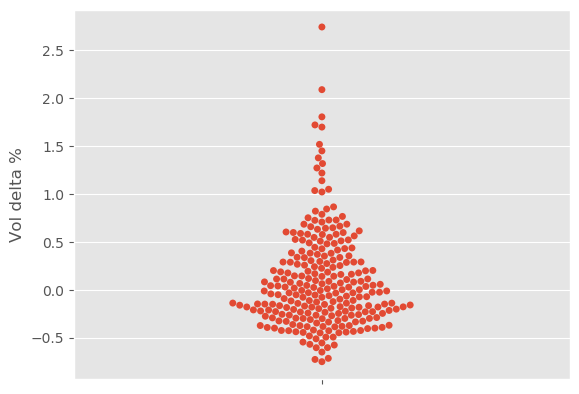

In [263]:
# Create bee swarm plot with Seaborn's default settings
sns.swarmplot(data= TROX_2016_b, y='vol_rtn')
plt.ylabel('Vol delta %')
plt.show()

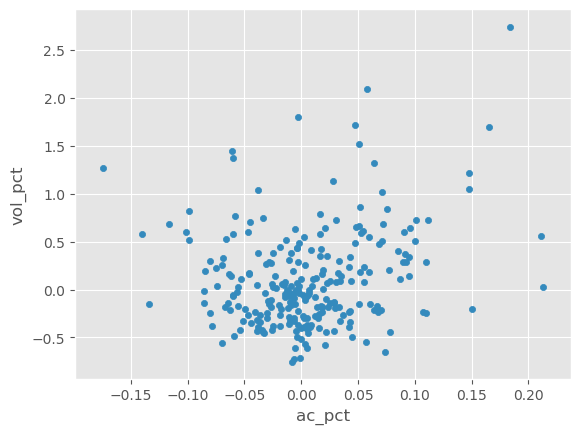

In [212]:
TROX_2016_b.plot.scatter(x= 'ac_rtn', y= 'vol_rtn')
plt.show()

In [251]:
TROX_2016_b_NOna = TROX_2016_b.dropna()

# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_b_NOna['ac_rtn'], TROX_2016_b_NOna['vol_rtn'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.28


In [250]:
m, b = np.polyfit(TROX_2016_b_NOna['ac_rtn'], TROX_2016_b_NOna['vol_rtn'] , 1)
print('Pente: {:0.2f}'.format(m))
print('Intercept: {:0.2f}'.format(b))

Pente: 2.70
Intercept: 0.08


In [213]:
TROX_2016_b['vol_rtn_shift'] = TROX_2016_b['vol_rtn'].shift()

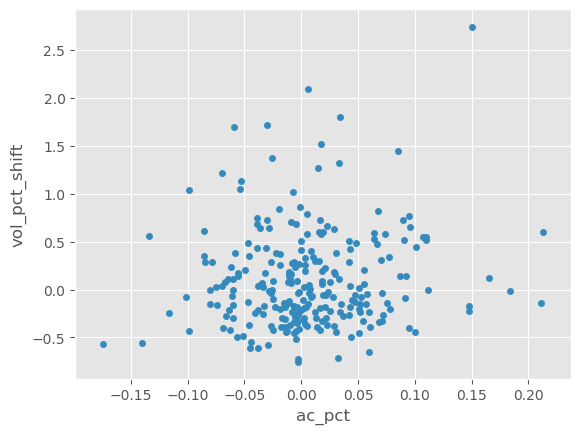

In [214]:
TROX_2016_b.plot.scatter(x= 'ac_rtn', y= 'vol_rtn_shift')
plt.show()

In [252]:
TROX_2016_b_NOna = TROX_2016_b.dropna()

# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_b_NOna['ac_rtn'], TROX_2016_b_NOna['vol_rtn_shift'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.07


In [249]:
m, b = np.polyfit(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn_shift'] , 1)
print('Pente: {:0.2f}'.format(m))
print('Intercept: {:0.2f}'.format(b))

Pente: 0.14
Intercept: 0.10


In [216]:
TROX_2016_b['ac_rtn5'] = TROX_2016_b['Adj Close'].pct_change(periods= 5)
TROX_2016_b['vol_rtn5'] = TROX_2016_b['Volume'].pct_change(periods= 5)

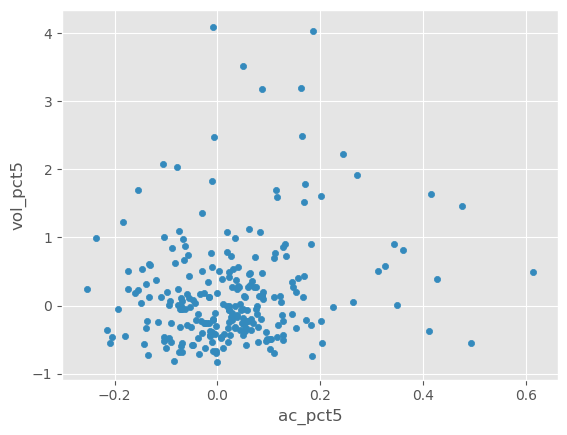

In [219]:
TROX_2016_b.plot.scatter(x= 'ac_rtn5', y= 'vol_rtn5')
plt.show()

In [245]:
TROX_2016_b_NOna = TROX_2016_b.dropna()

# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.22


In [248]:
m, b = np.polyfit(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5'] , 1)
print('Pente: {:0.2f}'.format(m))
print('Intercept: {:0.2f}'.format(b))

Pente: 1.41
Intercept: 0.15


In [220]:
TROX_2016_b['vol_rtn5_shift'] = TROX_2016_b['vol_rtn5'].shift()

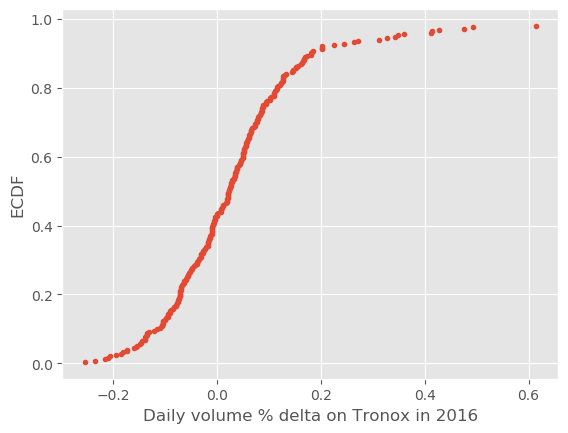

In [268]:
# Compute ECDF
x_ac_rtn, y_ac_rtn = ecdf(TROX_2016_b['ac_rtn5'])

plt.plot(x_ac_rtn, y_ac_rtn, marker='.', linestyle='none')
_ = plt.xlabel('Daily returns 5 day seasonal adj on Tronox in 2016')
_ = plt.ylabel('ECDF')
plt.show()

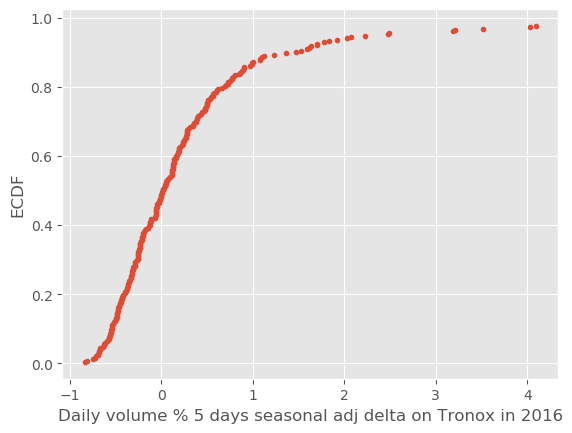

In [269]:
# Compute ECDF
x_ac_rtn, y_ac_rtn = ecdf(TROX_2016_b['vol_rtn5_shift'])

plt.plot(x_ac_rtn, y_ac_rtn, marker='.', linestyle='none')
_ = plt.xlabel('Daily volume % 5 days seasonal adj delta on Tronox in 2016')
_ = plt.ylabel('ECDF')
plt.show()

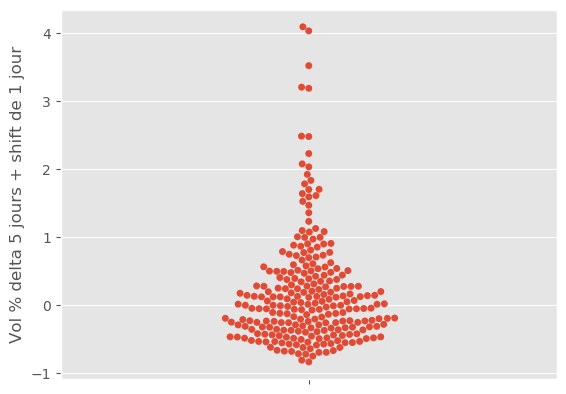

In [267]:
# Create bee swarm plot with Seaborn's default settings
sns.swarmplot(data= TROX_2016_b, y='vol_rtn5_shift')
plt.ylabel('Vol % delta 5 jours + shift de 1 jour')
plt.show()

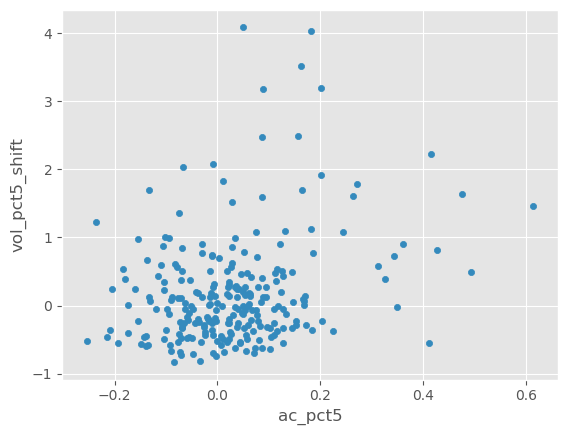

In [222]:
TROX_2016_b.plot.scatter(x= 'ac_rtn5', y= 'vol_rtn5_shift')
plt.show()

In [253]:
TROX_2016_b_NOna = TROX_2016_b.dropna()

# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5_shift'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.32


In [242]:
m, b = np.polyfit(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5_shift'] , 1)
print('La pente est de {:0.2f}'.format(m))
print('Intercept est à {:0.2f}'.format(b))

La pente est de 2.05
Intercept est à 0.12


In [227]:
#TROX_2016['vol_rtn5_stdev'], _ = tfrm_to_MinusMean(TROX_2016['vol_rtn5'], window_size= 12)

df_ravg = TROX_2016_b['vol_rtn5'].rolling(12).mean()
TROX_2016_b['vol_rtn5_stdev'] = TROX_2016_b['vol_rtn5'] - df_ravg

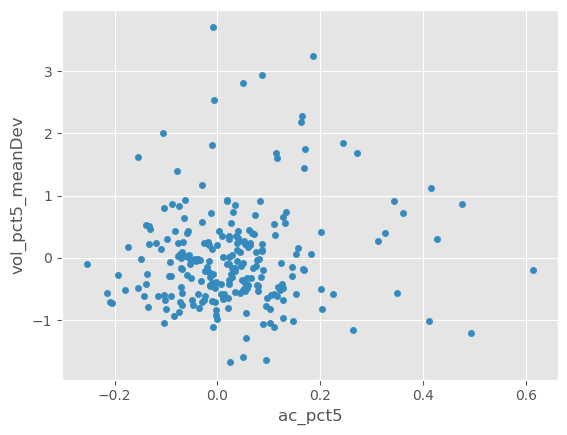

In [230]:
TROX_2016_b.plot.scatter(x= 'ac_rtn5', y= 'vol_rtn5_stdev')
plt.show()

In [254]:
TROX_2016_b_NOna = TROX_2016_b.dropna()

# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5_stdev'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.10


In [255]:
m, b = np.polyfit(TROX_2016_b_NOna['ac_rtn5'], TROX_2016_b_NOna['vol_rtn5_stdev'] , 1)
print('La pente est de {:0.2f}'.format(m))
print('Intercept est à {:0.2f}'.format(b))

La pente est de 0.64
Intercept est à -0.02


In [290]:
TROX_2016_b.head()

Open  High   Low  Close  Adj Close   Volume    ac_pct   vol_pct  \
Date                                                                          
2016-01-04  3.86  4.21  3.75   4.18   3.649740  1109800       NaN       NaN   
2016-01-05  4.18  4.29  4.00   4.20   3.667202   437100  0.004784 -0.606145   
2016-01-06  4.08  4.09  3.92   4.04   3.527500   889000 -0.038095  1.033860   
2016-01-07  3.91  3.92  3.62   3.64   3.178243  1350400 -0.099010  0.519010   
2016-01-08  3.71  4.04  3.66   4.04   3.527500  1014800  0.109890 -0.248519   

            vol_pct_shift  ac_pct5  vol_pct5  vol_pct5_shift  vol_pct5_meanDev  
Date                                                                            
2016-01-04            NaN      NaN       NaN             NaN               NaN  
2016-01-05            NaN      NaN       NaN             NaN               NaN  
2016-01-06      -0.606145      NaN       NaN             NaN               NaN  
2016-01-07       1.033860      NaN       NaN             NaN               NaN  
2016-01-08       0.519010      NaN       NaN             NaN               NaN

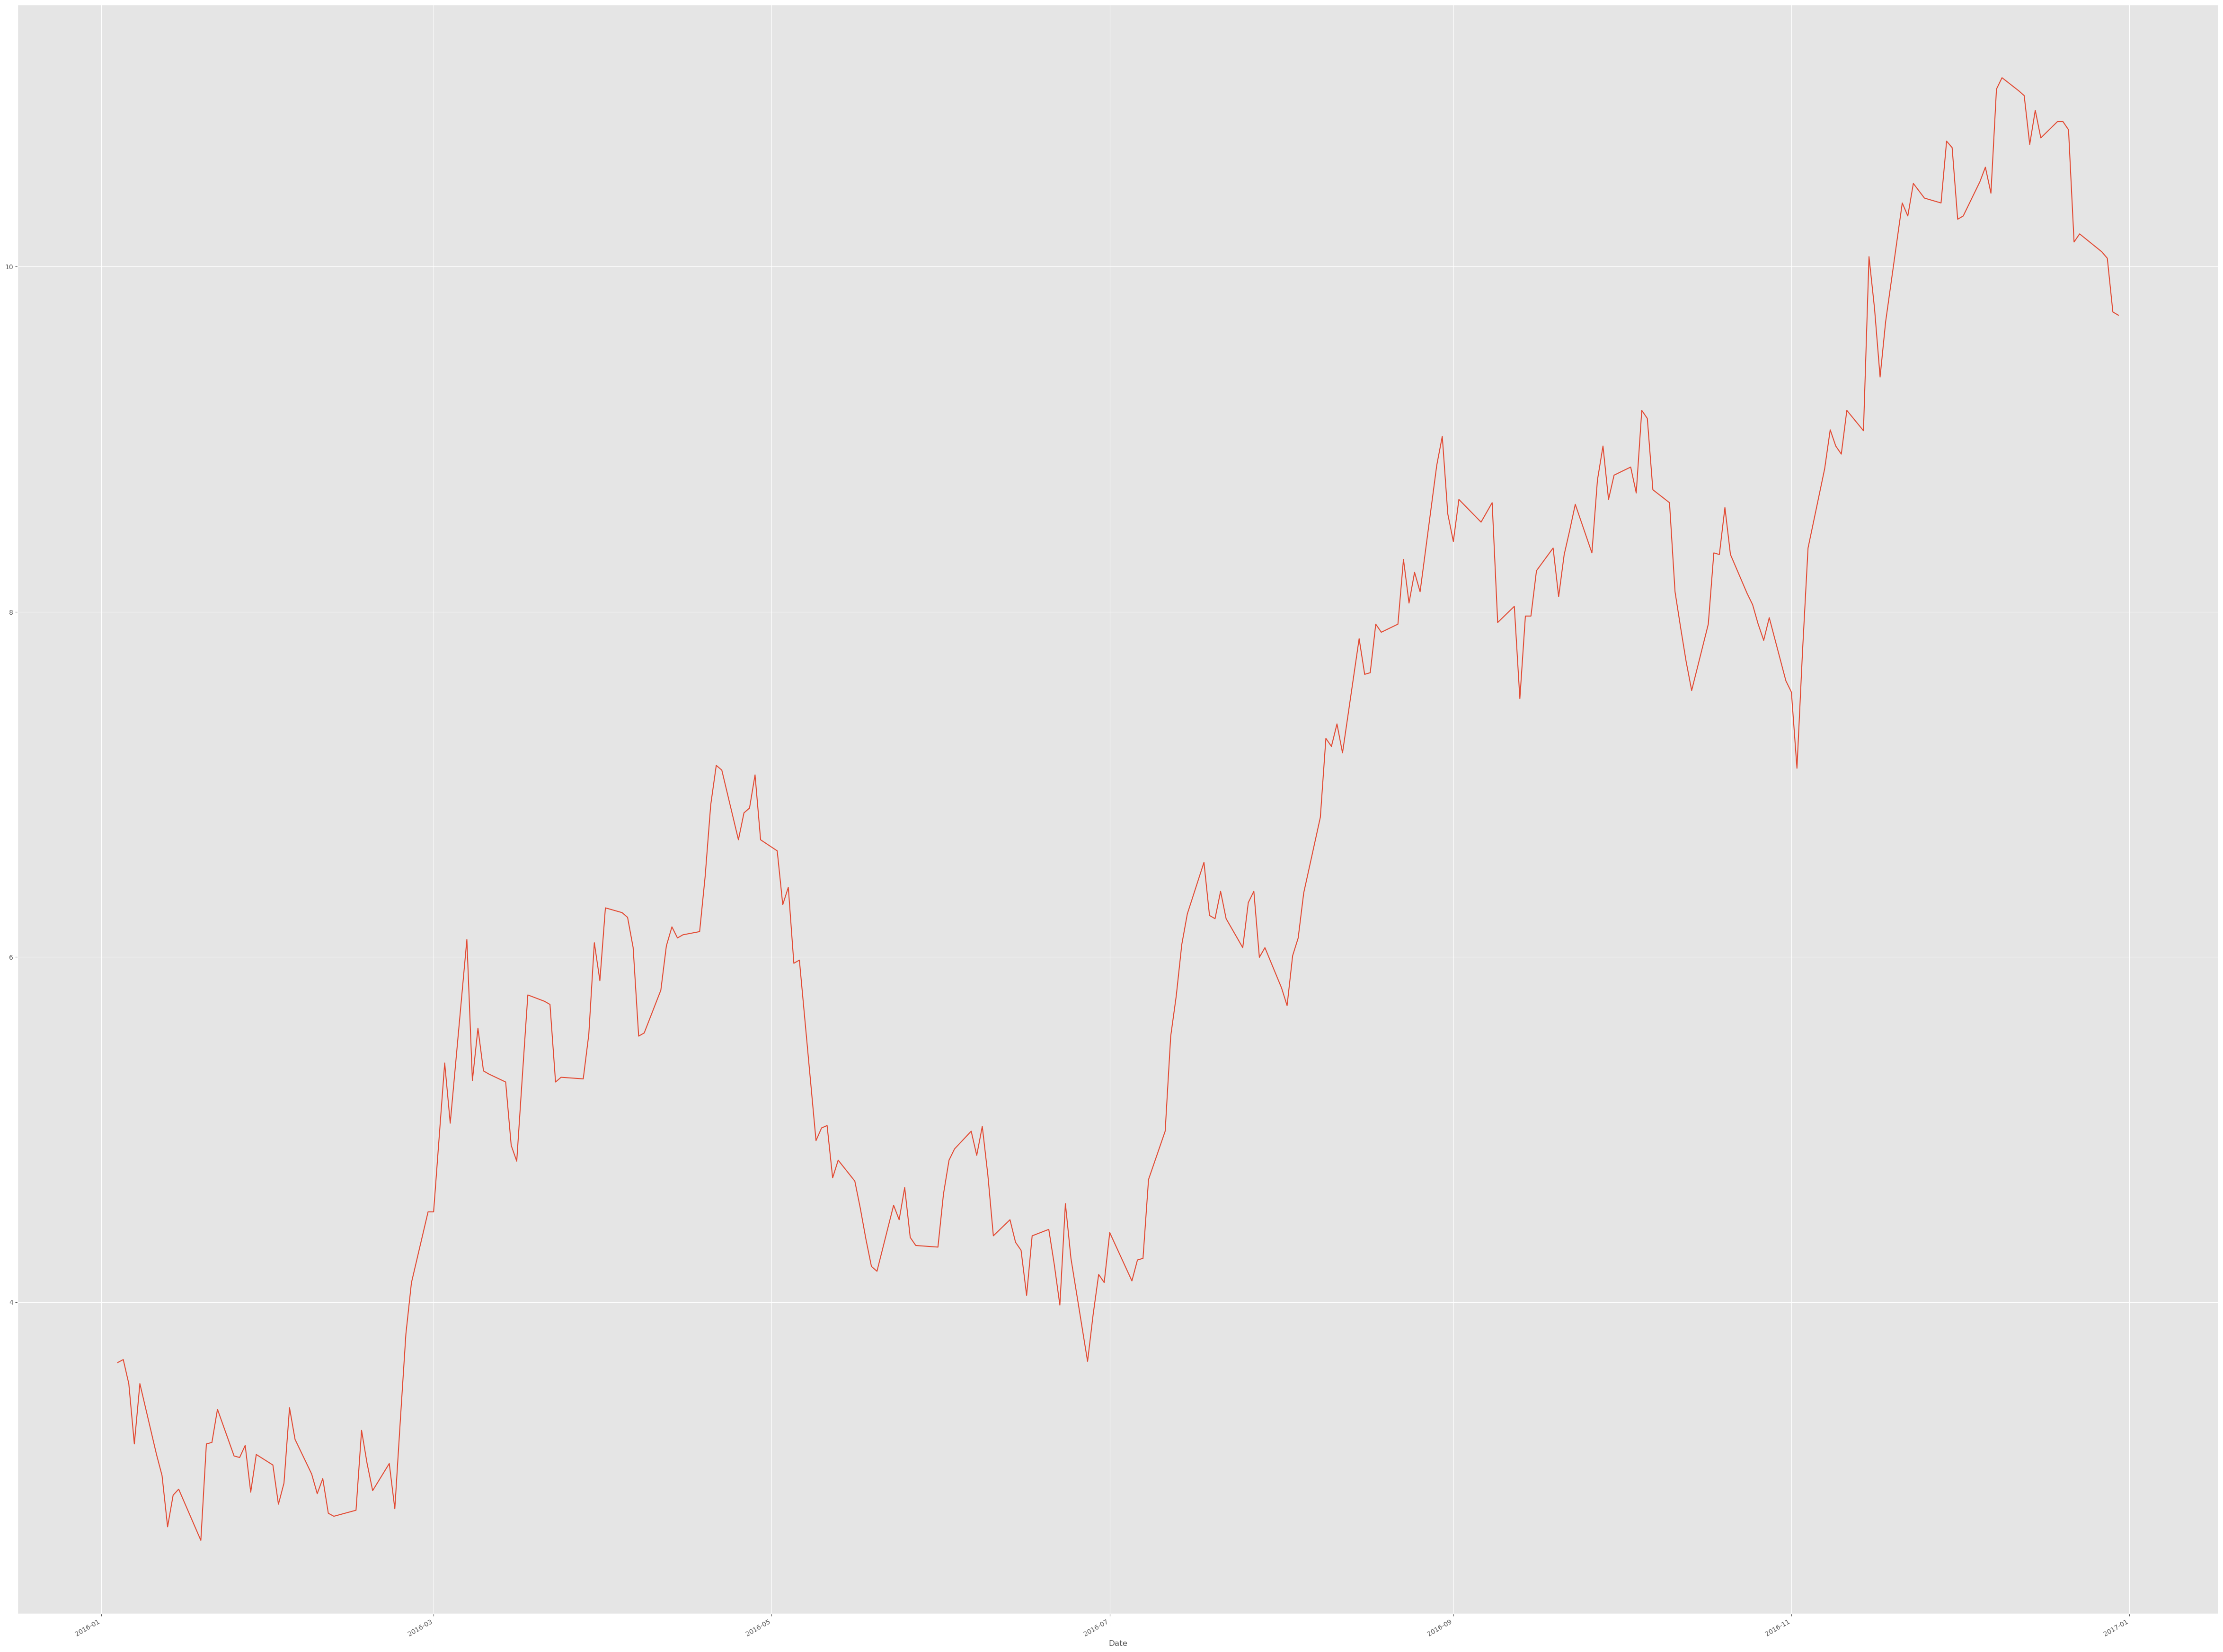

In [169]:
TROX_2016['Adj Close'].plot(figsize= [60, 50])
plt.show()

In [204]:
#plt.rcParams.update({'axes.titlesize': 'large'})

fig = plt.figure()
fig.add_axes()

ax1= fig.add_subplot(211)

plt.title('2018 Q2', fontsize= 100)
#plt.grid(b= True, axis= 'both')

TROX_2016.plot(y= 'Adj Close',
               figsize= [60, 50],
               fontsize= 30,
               ax= ax1
              )

ax2 = ax1.twinx()
plt.title('TRONOX 2016')

TROX_2016.plot.bar(y= 'Volume',
                             color= 'skyblue', 
                             figsize= [60, 50],
                             fontsize= 30,
                             ax= ax2,
                             secondary_y= True,
                             alpha= 0.2
                            )

#plt.savefig('loblaw_2018_Q2.pdf')
plt.show()

ValueError: view limit minimum -36816.6625 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [173]:
TROX_2016.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [195]:
TROX_2016.plot.bar(y= 'Volume')
plt.show()

KeyError: 'index'

In [186]:
for i in TROX_2016.index:
    print(i)

2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-08 00:00:00
2016-02-09 00:00:00
2016-02-10 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00


In [188]:
TROX_2016.loc['Volume']

KeyError: 'Volume'

In [189]:
TROX_2016.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

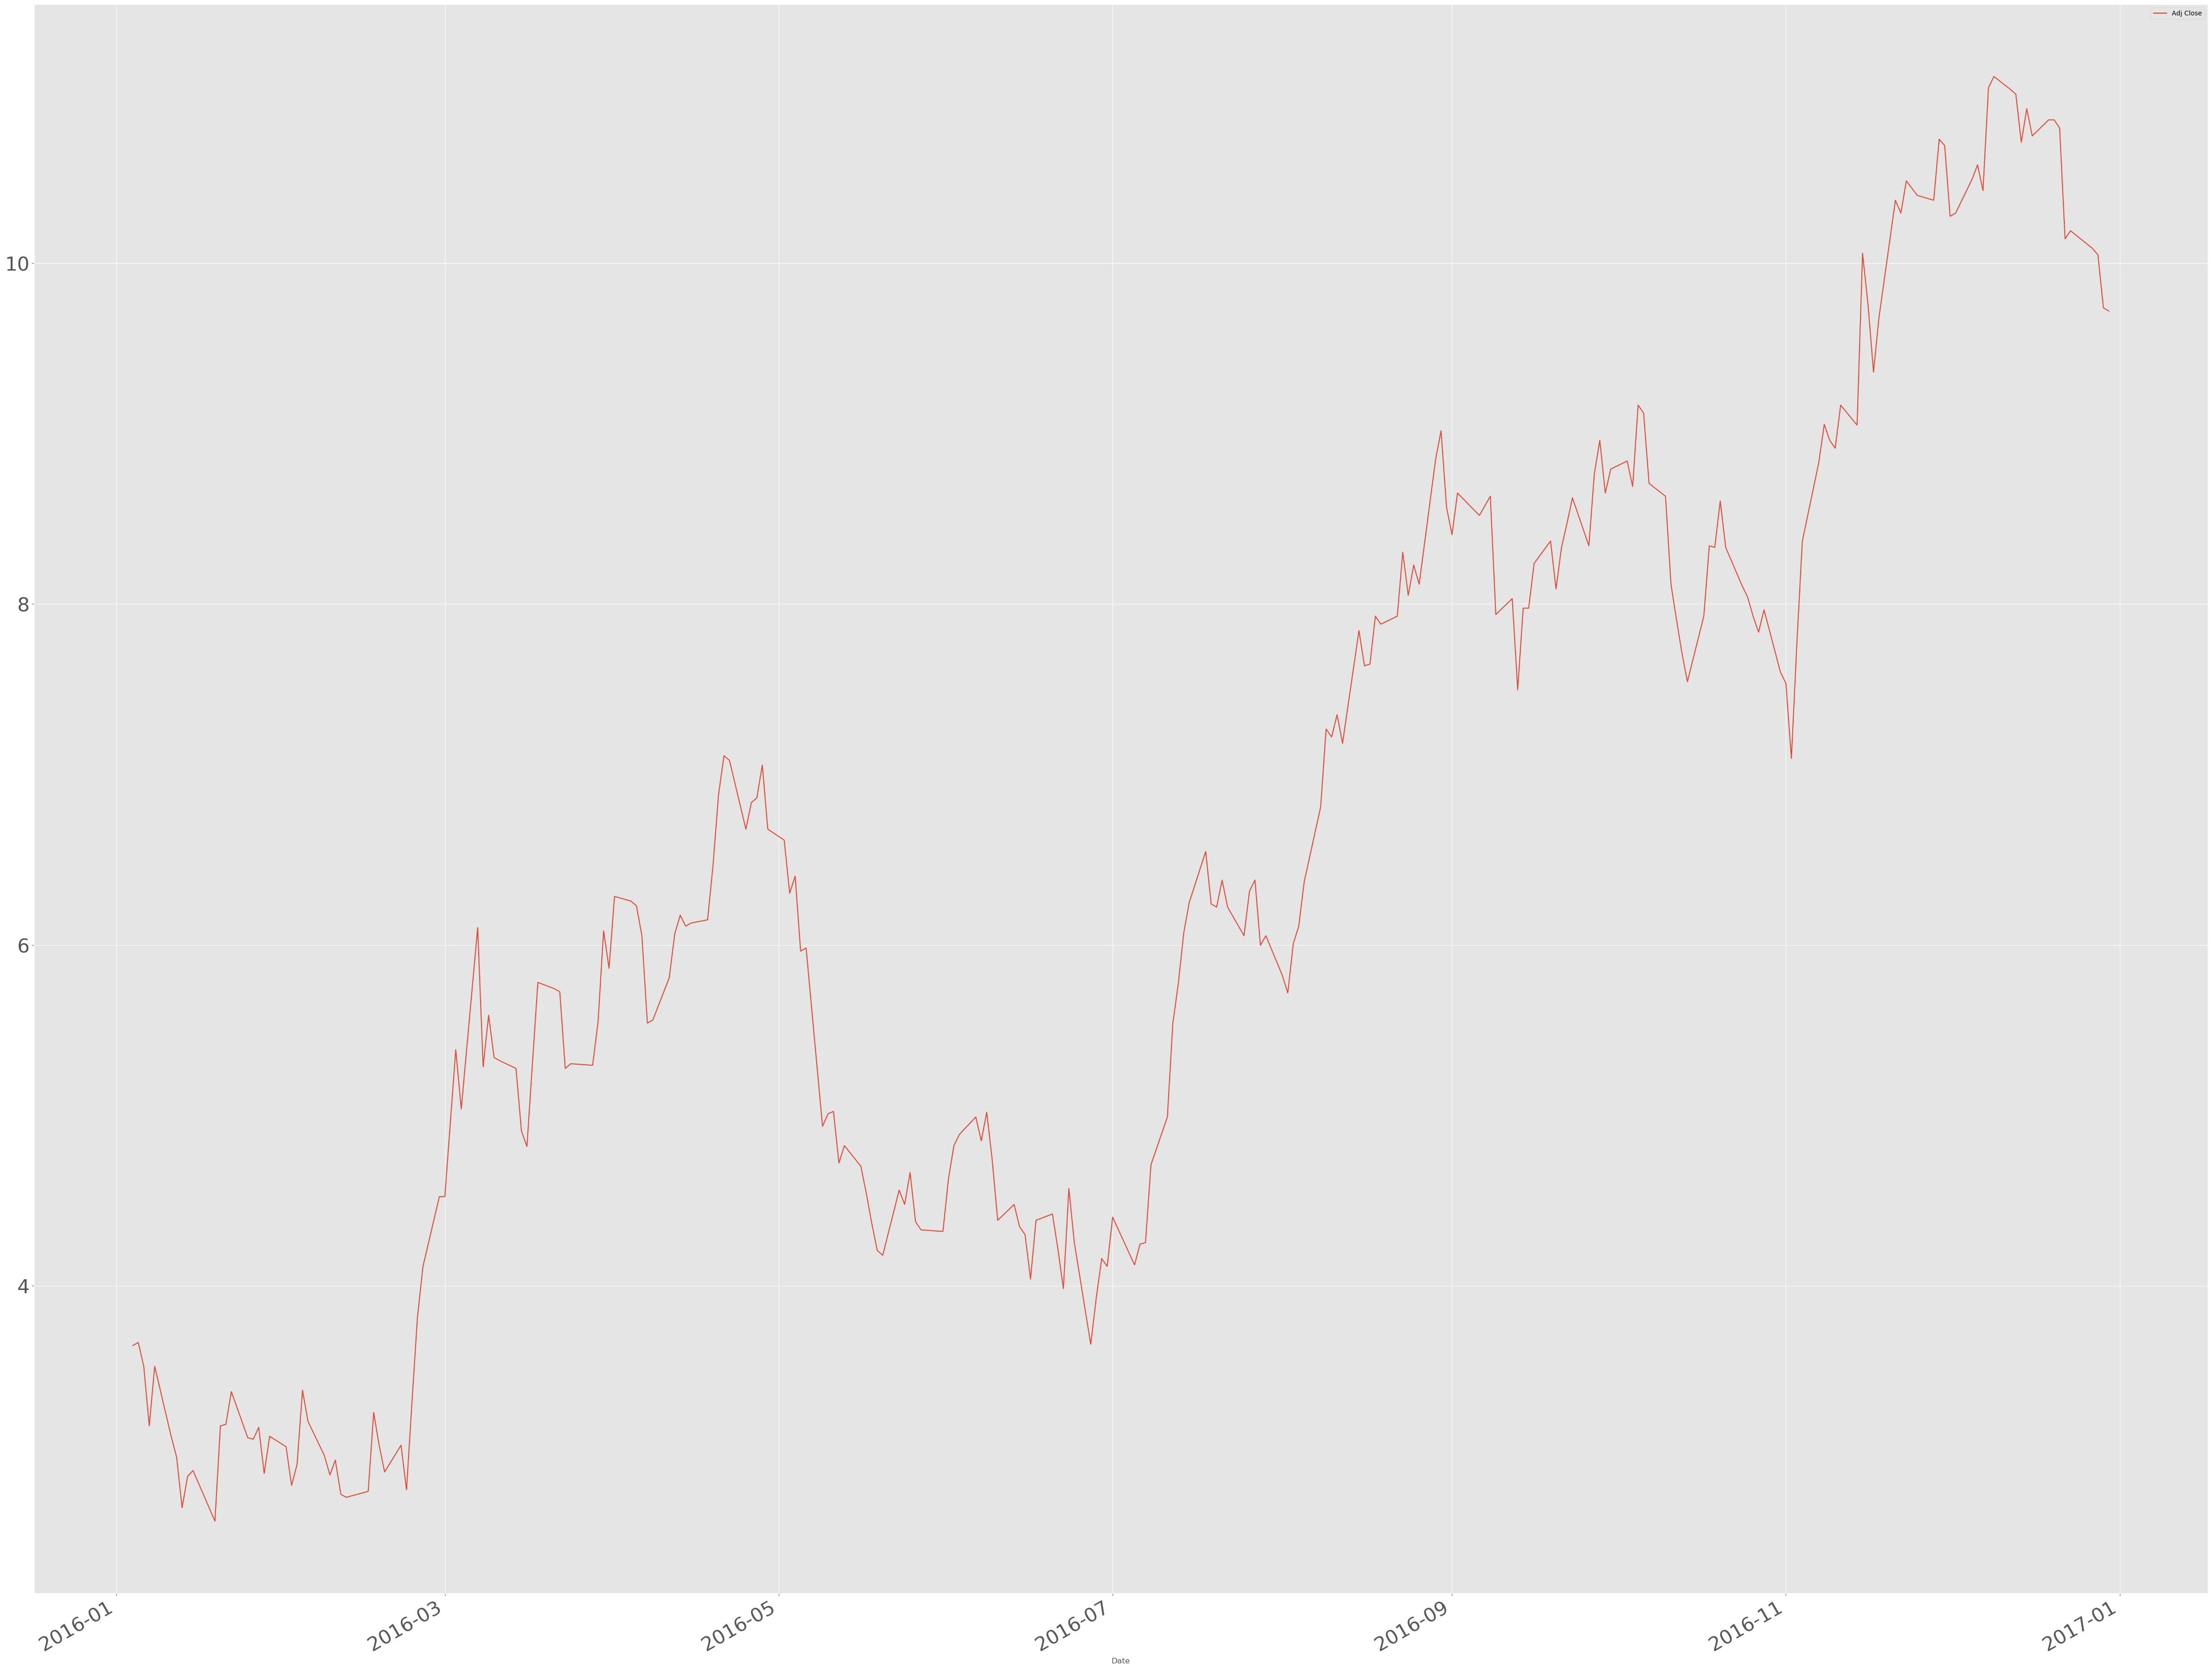

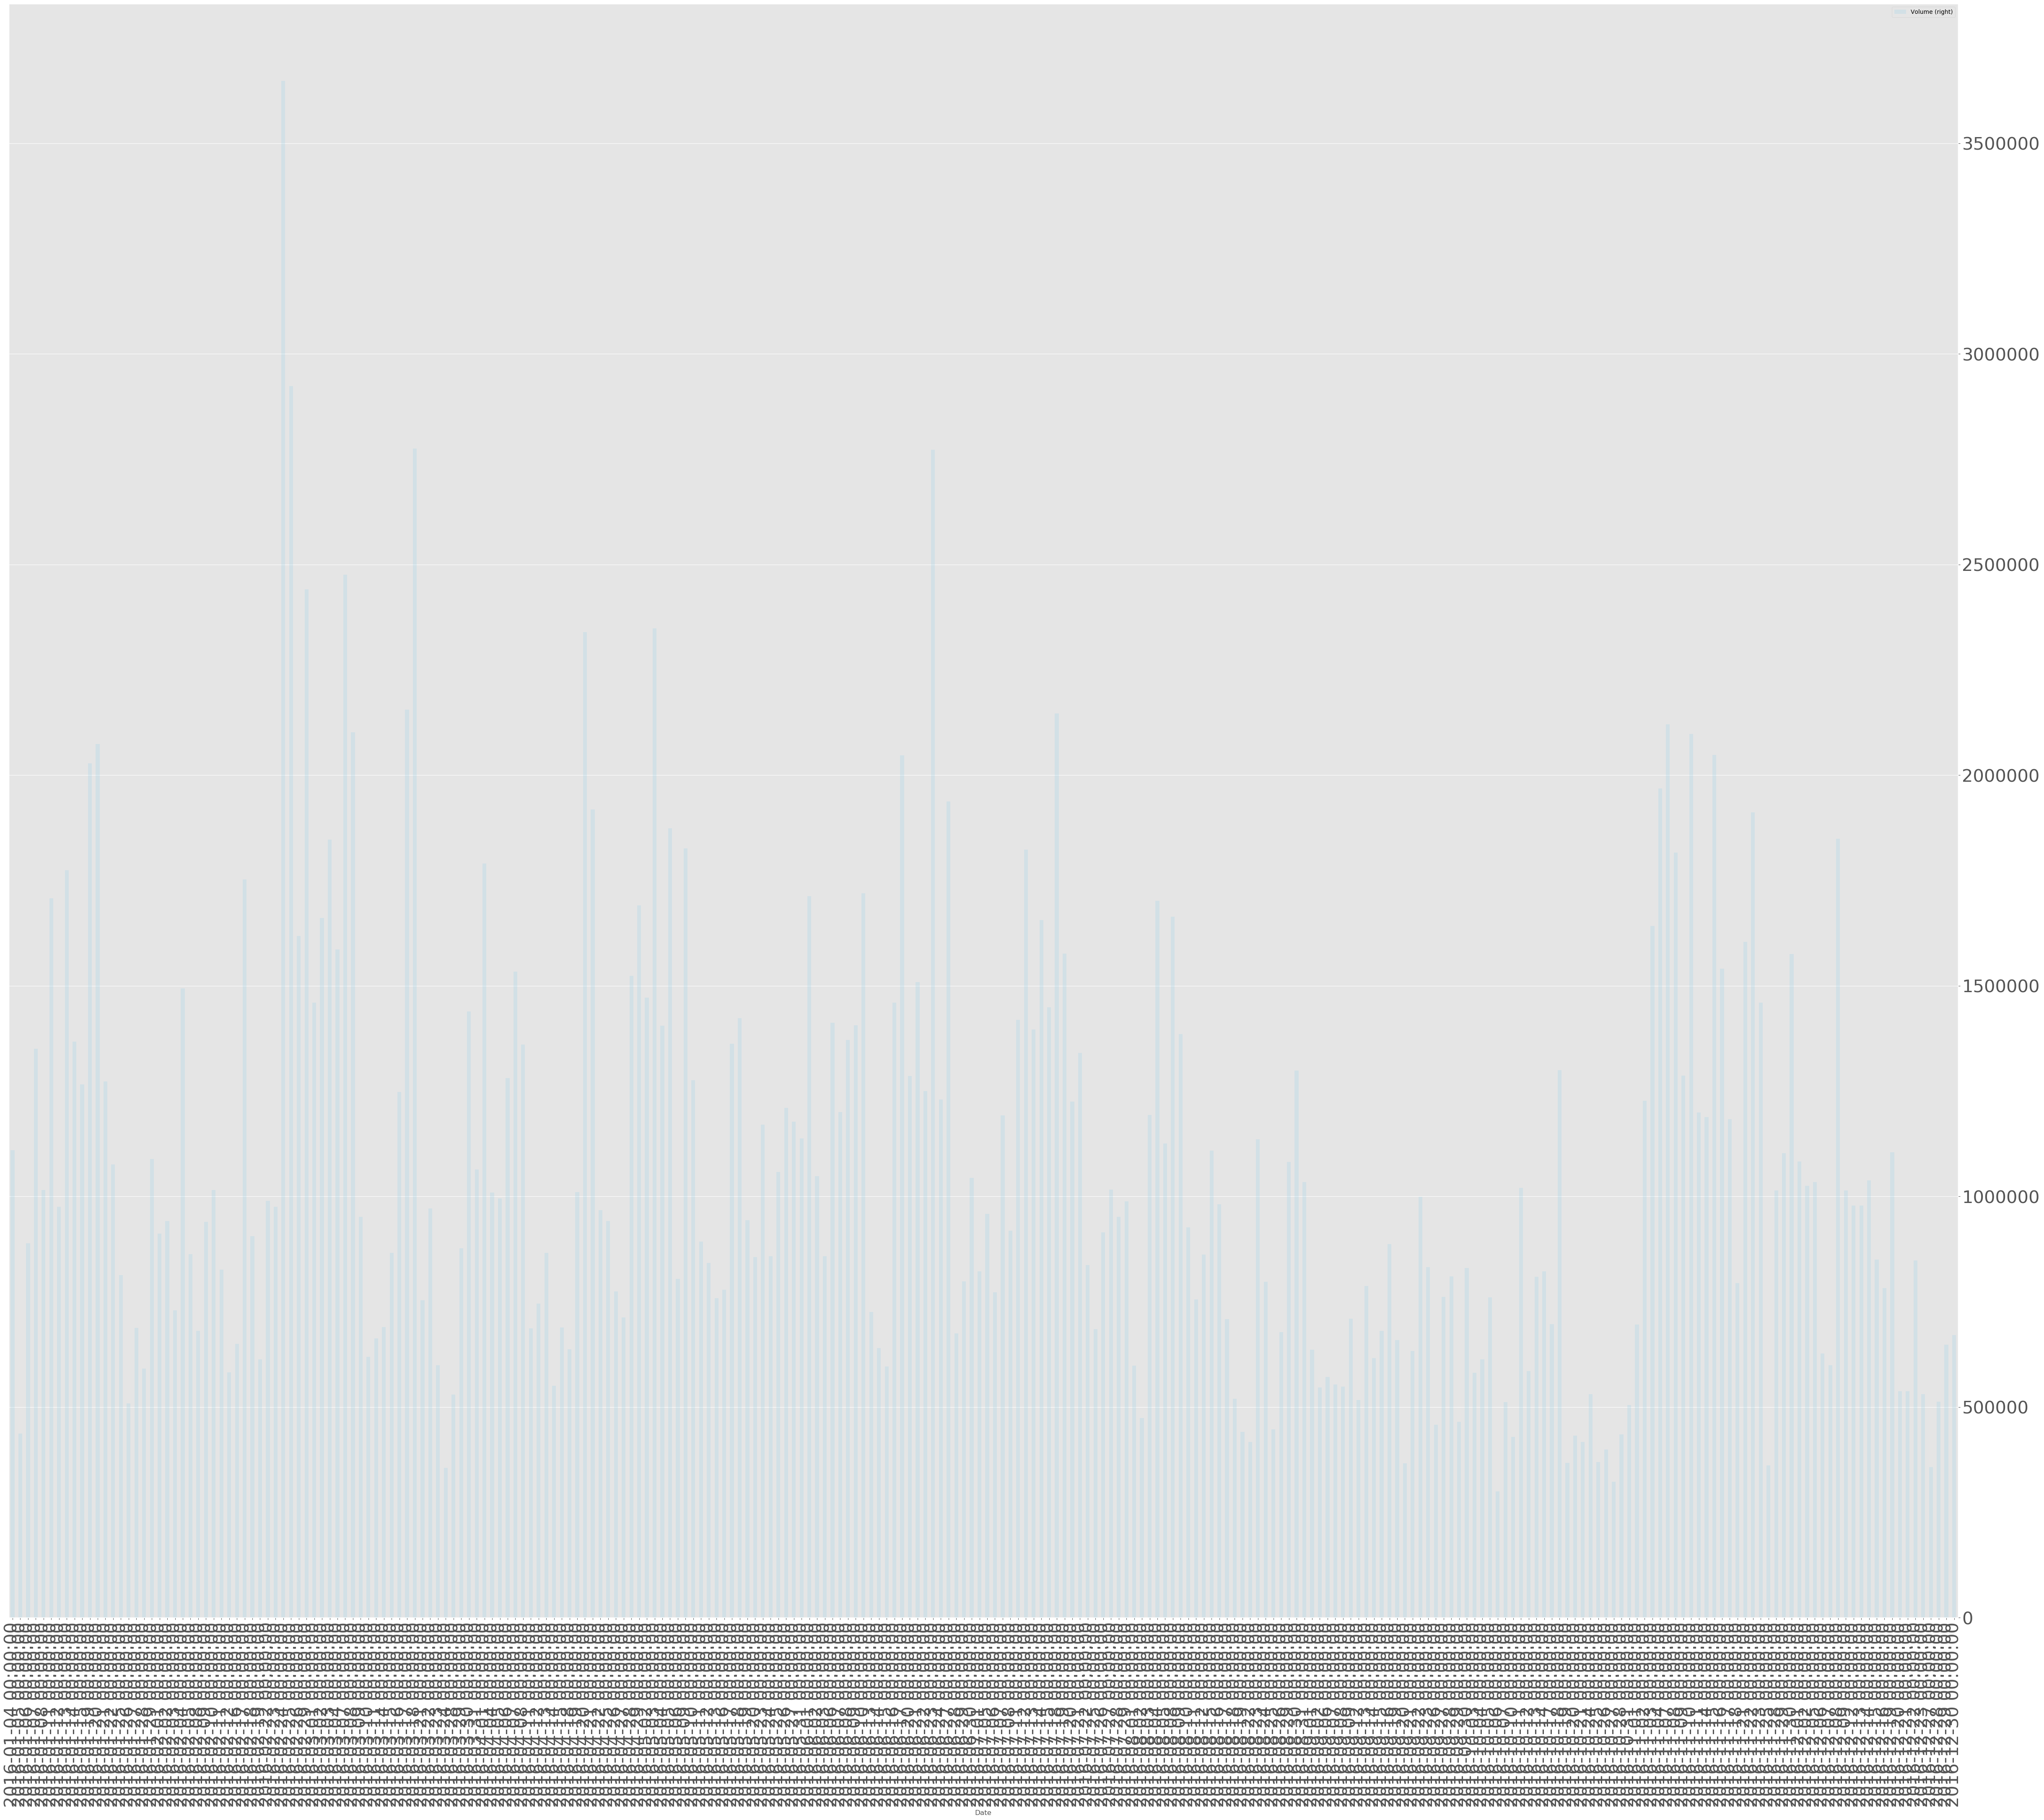

In [207]:
TROX_2016.plot(y= 'Adj Close',
               figsize= [60, 50],
               fontsize= 30,
              )

TROX_2016.plot.bar(y= 'Volume',
                             color= 'skyblue', 
                             figsize= [60, 50],
                             fontsize= 30,
                             secondary_y= True,
                             alpha= 0.2
                            )

plt.show()

In [271]:
TROX_2016['Volume'].median()

973150.0

In [272]:
TROX

Open       High    Low      Close  Adj Close   Volume
Date                                                                  
2014-01-02  22.959999  23.320000  22.24  22.920000  17.344423   641900
2014-01-03  22.879999  23.120001  22.75  22.910000  17.336851   205300
2014-01-06  23.000000  23.170000  22.92  23.049999  17.442795   277500
2014-01-07  23.040001  23.270000  22.84  23.209999  17.563877   699600
2014-01-08  23.200001  23.639999  23.15  23.510000  17.790897   907100
...               ...        ...    ...        ...        ...      ...
2020-07-01   7.170000   7.290000   6.69   6.850000   6.850000  1393000
2020-07-02   7.100000   7.510000   6.99   7.330000   7.330000   966600
2020-07-06   7.500000   7.630000   7.31   7.570000   7.570000  1266100
2020-07-07   7.410000   7.550000   7.36   7.500000   7.500000  1414900
2020-07-08   7.510000   7.570000   7.25   7.420000   7.420000  1336300

[1640 rows x 6 columns]

In [273]:
TROX_2016.head()

Open  High   Low  Close  Adj Close   Volume
Date                                                   
2016-01-04  3.86  4.21  3.75   4.18   3.649740  1109800
2016-01-05  4.18  4.29  4.00   4.20   3.667202   437100
2016-01-06  4.08  4.09  3.92   4.04   3.527500   889000
2016-01-07  3.91  3.92  3.62   3.64   3.178243  1350400
2016-01-08  3.71  4.04  3.66   4.04   3.527500  1014800

## EDA - Autres facteurs

À partir de https://www.businesswire.com/news/home/20160503005778/en/Technavio-Announces-Top-Vendors-Global-Titanium-Ore,
j'ai décider d'explorer l'influence d'autres facteurs.

### Chemours

In [333]:
CC = pd.read_csv('_Input/CC.csv', parse_dates= True)
CC.index = pd.to_datetime(CC.Date)
CC = CC.drop(columns= ['Date'])
CC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1271 entries, 2015-06-19 to 2020-07-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1271 non-null   float64
 1   High       1271 non-null   float64
 2   Low        1271 non-null   float64
 3   Close      1271 non-null   float64
 4   Adj Close  1271 non-null   float64
 5   Volume     1271 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.5 KB


In [335]:
CC_2016 = CC.loc['2016']

# Tranform to stationary returns with seasonal of 5
CC_2016_rtn5 = CC_2016['Adj Close'].pct_change(5)*100
CC_2016_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
CC_2016_rtn5_stdev, df_ravg_temp = tfrm_to_MinusMean(CC_2016_rtn5)

# Get temporary df of rolling averages
df_ravg_temp = CC_2016_rtn5.rolling(12).mean()
df_roll_temp= rolwin_ARIMA(CC_2016_rtn5_stdev, ARIMA_order= (1, 0, 5), window_size= 118)

# Stiching all together
CC_2016_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_temp.loc['2016-07-15': :], CC_2016_rtn5.loc['2016-07-15': :]], axis= 1)
CC_2016_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']

# Selon système d'équation résolut sur papier
CC_2016_rtn5_stdev['Pred_rtn5'] = CC_2016_rtn5_stdev['rtn5'] - CC_2016_rtn5_stdev['Erreur']

CC_2016_rtn5_stdev.dropna(inplace = True)
CC_2016_rtn5_stdev.shape

(118, 6)

### Hypothèse: 
Les retour de Tronox sont correlé avec les retours Chemours

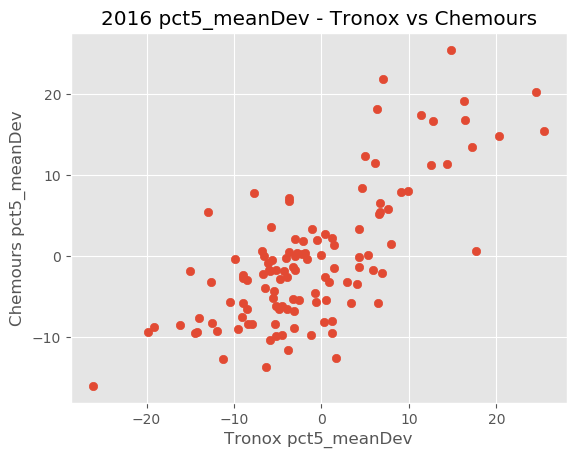

In [336]:
plt.scatter(TROX_2016_rtn5_stdev['rtn5_var'], CC_2016_rtn5_stdev['rtn5_var'])
plt.title('2016 rtn5_stdev - Tronox vs Chemours')
plt.xlabel('Tronox rtn5_stdev')
plt.ylabel('Chemours rtn5_stdev')
plt.show()

In [63]:
# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_rtn5_stdev['rtn5_var'], CC_2016_rtn5_stdev['rtn5_var'])
print('Pearson corr coef: {:0.2f}'.format(r))

NameError: name 'CC_2016_rtn5_stdev' is not defined

In [338]:
m, b = np.polyfit(TROX_2016_rtn5_stdev['rtn5_var'], CC_2016_rtn5_stdev['rtn5_var'] , 1)
print('La pente est de {:0.2f}'.format(m))
print('Intercept est à {:0.2f}'.format(b))

La pente est de 0.67
Intercept est à 0.36


### Conclusion
Les deux retours sont fortement correlés.

## S&P 500

### Data wrangling

In [325]:
GSPC = pd.read_csv('_Input/^GSPC_0114-0720.csv', parse_dates= True)
GSPC.index = pd.to_datetime(GSPC.Date)
GSPC = GSPC.drop(columns= ['Date'])
GSPC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1640 entries, 2014-01-02 to 2020-07-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1640 non-null   float64
 1   High       1640 non-null   float64
 2   Low        1640 non-null   float64
 3   Close      1640 non-null   float64
 4   Adj Close  1640 non-null   float64
 5   Volume     1640 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 89.7 KB


In [327]:
GSPC_2016 = GSPC.loc['2016']

# Tranform to stationary returns with seasonal of 5
GSPC_2016_rtn5 = GSPC_2016['Adj Close'].pct_change(5)*100
GSPC_2016_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
GSPC_2016_rtn5_stdev, df_ravg_temp = tfrm_to_MinusMean(GSPC_2016_rtn5)

# Get temporary df of rolling averages
df_ravg_temp = GSPC_2016_rtn5.rolling(12).mean()
df_roll_temp= rolwin_ARIMA(GSPC_2016_rtn5_stdev, ARIMA_order= (1, 0, 5), window_size= 118)

# Stiching all together
GSPC_2016_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_temp.loc['2016-07-15': :], GSPC_2016_rtn5.loc['2016-07-15': :]], axis= 1)
GSPC_2016_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']

# Selon système d'équation résolut sur papier
GSPC_2016_rtn5_stdev['Pred_rtn5'] = GSPC_2016_rtn5_stdev['rtn5'] - GSPC_2016_rtn5_stdev['Erreur']

GSPC_2016_rtn5_stdev.dropna(inplace = True)
GSPC_2016_rtn5_stdev.shape

(118, 6)

### Hypothèse: 
Les retour de Tronox sont correlé avec les retours du S&P 500

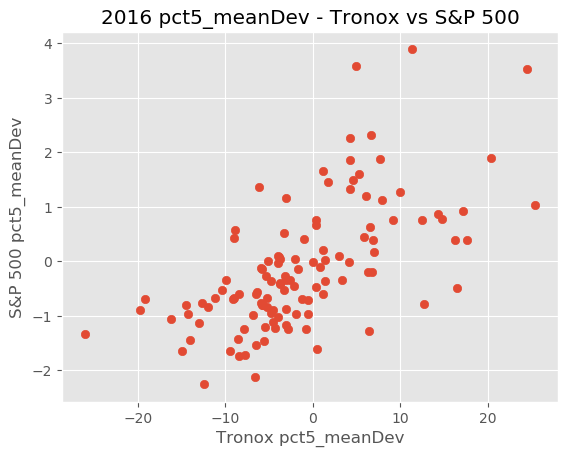

In [329]:
plt.scatter(TROX_2016_rtn5_stdev['rtn5_var'], GSPC_2016_rtn5_stdev['rtn5_var'])
plt.title('2016 rtn5_stdev - Tronox vs S&P 500')
plt.xlabel('Tronox rtn5_stdev')
plt.ylabel('S&P 500 rtn5_stdev')
plt.show()

In [330]:
# Compute Pearson correlation coefficient
r = pearson_r(TROX_2016_rtn5_stdev['rtn5_var'], GSPC_2016_rtn5_stdev['rtn5_var'])
print('Pearson corr coef: {:0.2f}'.format(r))

Pearson corr coef: 0.63


In [331]:
m, b = np.polyfit(TROX_2016_rtn5_stdev['rtn5_var'], GSPC_2016_rtn5_stdev['rtn5_var'] , 1)
print('La pente est de {:0.2f}'.format(m))
print('Intercept est à {:0.2f}'.format(b))

La pente est de 0.08
Intercept est à -0.02


### Conclusion
Les deux retours sont fortement correlés.

In [23]:
ILU_2016_pred = pd.read_pickle('./_Output/ILU_2016_pred.pickle')

In [57]:
ILU_TROX_2016_rtn5_stdev = pd.merge(ILU_2016_pred['rtn5_stdev'].iloc[49::], 
                                    TROX_2016_rtn5_stdev['rtn5_var'].iloc[:-1], 
                                    left_index= True, 
                                    right_index= True, 
                                    how='outer')
ILU_TROX_2016_rtn5_stdev.dropna(inplace= True)

In [67]:
ILU_TROX_2016_rtn5_stdev['trox_shift1'] = ILU_TROX_2016_rtn5_stdev['rtn5_var'].shift(1)
ILU_TROX_2016_rtn5_stdev.dropna(inplace= True)
ILU_TROX_2016_rtn5_stdev

rtn5_stdev   rtn5_var  trox_shift1
Date                                          
2016-07-18   -6.674632  12.754422    16.443146
2016-07-19   -7.689743  -7.719775    12.754422
2016-07-20   -8.432199 -12.945401    -7.719775
2016-07-21   -8.908460 -14.990230   -12.945401
2016-07-22   -3.973101 -19.796774   -14.990230
...                ...        ...          ...
2016-12-21   -1.395561  -0.578881    -2.775828
2016-12-22    0.364465  -7.905745    -0.578881
2016-12-27    2.371084  -6.444579    -7.905745
2016-12-28    5.236616  -5.535044    -6.444579
2016-12-29    1.206745  -6.777946    -5.535044

[104 rows x 3 columns]

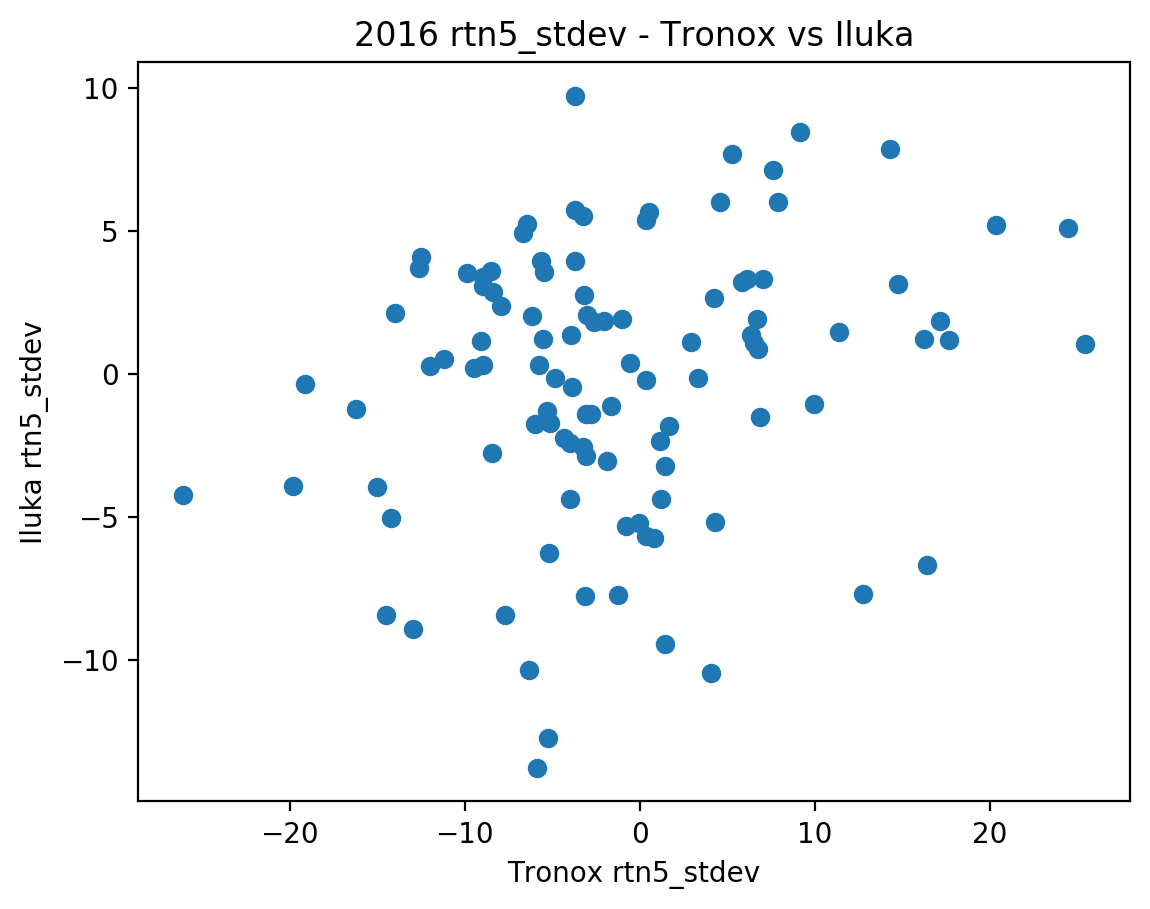

Pearson corr coef: 0.22


In [68]:
_= plt.scatter(ILU_TROX_2016_rtn5_stdev['trox_shift1'], ILU_TROX_2016_rtn5_stdev['rtn5_stdev'])
_= plt.title('2016 rtn5_stdev - Tronox vs Iluka')
_= plt.xlabel('Tronox rtn5_stdev')
_= plt.ylabel('Iluka rtn5_stdev')
plt.show()

# Compute Pearson correlation coefficient
r = pearson_r(ILU_TROX_2016_rtn5_stdev['trox_shift1'], ILU_TROX_2016_rtn5_stdev['rtn5_stdev'])
print('Pearson corr coef: {:0.2f}'.format(r))

In [71]:
ILU_TROX_2016_rtn5 = pd.merge(ILU_2016_pred['rtn5_stdev'].iloc[49::], 
                              TROX_2016_rtn5.iloc[:-1], 
                              left_index= True, 
                              right_index= True, 
                              how='outer')

ILU_TROX_2016_rtn5.dropna(inplace= True)

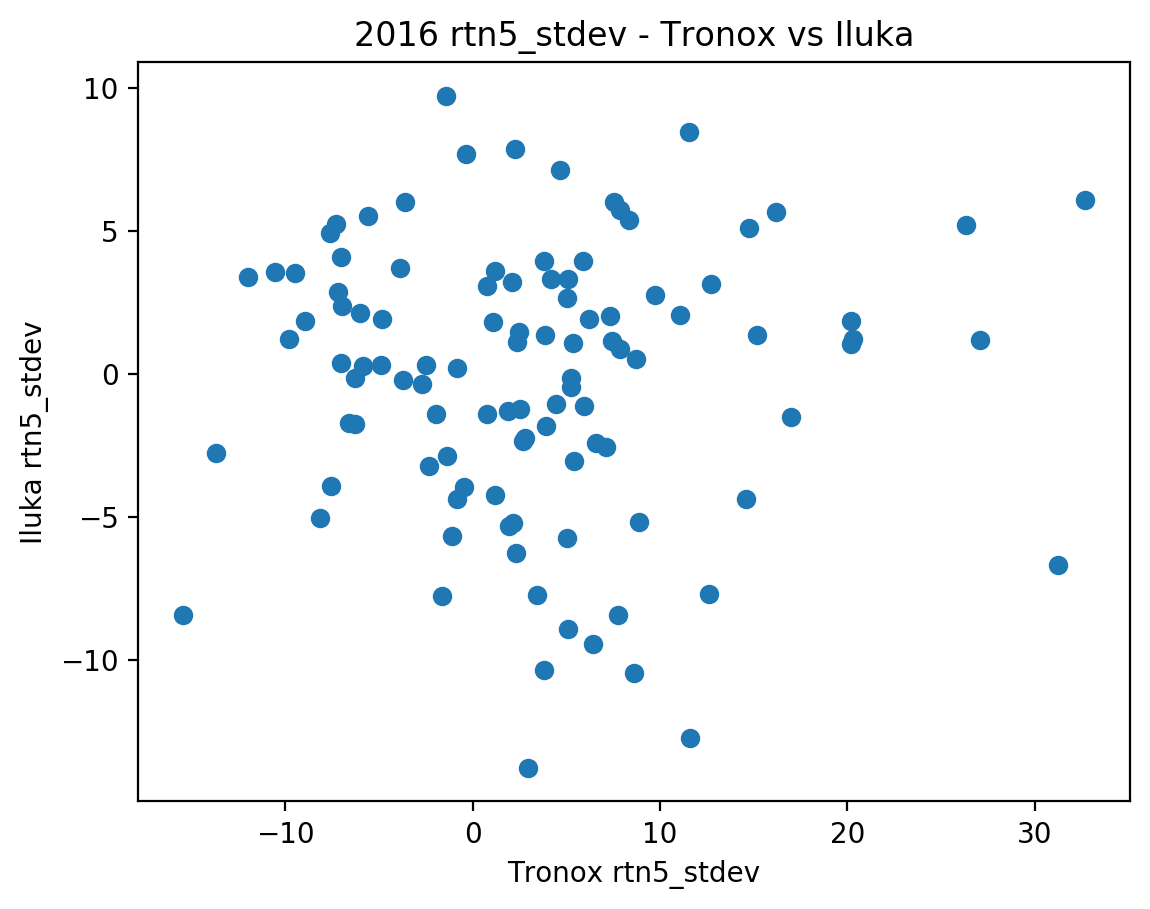

Pearson corr coef: 0.01


In [73]:
_= plt.scatter(ILU_TROX_2016_rtn5['Adj Close'], ILU_TROX_2016_rtn5['rtn5_stdev'])
_= plt.title('2016 rtn5_stdev - Tronox vs Iluka')
_= plt.xlabel('Tronox rtn5_stdev')
_= plt.ylabel('Iluka rtn5_stdev')
plt.show()

# Compute Pearson correlation coefficient
r = pearson_r(ILU_TROX_2016_rtn5['Adj Close'], ILU_TROX_2016_rtn5['rtn5_stdev'])
print('Pearson corr coef: {:0.2f}'.format(r))

In [401]:
ilu_key_stats = {'ILU.AX': {'annualHoldingsTurnover': None,
  'enterpriseToRevenue': 2.949,
  'beta3Year': None,
  'profitMargins': -0.21198,
  'enterpriseToEbitda': 4.928,
  '52WeekChange': -0.0032327175,
  'morningStarRiskRating': None,
  'forwardEps': 0.99,
  'revenueQuarterlyGrowth': None,
  'sharesOutstanding': 422584992,
  'fundInceptionDate': '-',
  'annualReportExpenseRatio': None,
  'totalAssets': None,
  'bookValue': 1.681,
  'sharesShort': None,
  'sharesPercentSharesOut': None,
  'fundFamily': None,
  'lastFiscalYearEnd': 1577750400,
  'heldPercentInstitutions': 0.52563,
  'netIncomeToCommon': -279900000,
  'trailingEps': -0.663,
  'lastDividendValue': None,
  'SandP52WeekChange': 0.06933558,
  'priceToBook': 5.472933,
  'heldPercentInsiders': 0.00427,
  'nextFiscalYearEnd': 1640908800,
  'yield': None,
  'mostRecentQuarter': 1577750400,
  'shortRatio': None,
  'sharesShortPreviousMonthDate': '-',
  'floatShares': 419062435,
  'beta': 1.301162,
  'enterpriseValue': 3893257472,
  'priceHint': 2,
  'threeYearAverageReturn': None,
  'lastSplitDate': '2008-03-19',
  'lastSplitFactor': '1:1',
  'legalType': None,
  'morningStarOverallRating': None,
  'earningsQuarterlyGrowth': None,
  'priceToSalesTrailing12Months': None,
  'dateShortInterest': None,
  'pegRatio': None,
  'ytdReturn': None,
  'forwardPE': None,
  'maxAge': 1,
  'lastCapGain': None,
  'shortPercentOfFloat': None,
  'sharesShortPriorMonth': None,
  'category': None,
  'fiveYearAverageReturn': None}}

## Stratégie d'investissement 1
test

In [1]:
import pandas as pd
# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat

In [152]:
# Importation du dataset annoté à la main dans spreadsheet.
Trox_2017_strat1 = pd.read_csv('_Input/TROX_2017_ARIMA(3,0,6)110 - to_Strat1.csv', 
                               parse_dates= ['Date'],
                               index_col= 'Date',
                               decimal= ',')

# Seul les 'Buy' et 'Sell' ont été inscrit. Remplir les NaN avec 'Hold'
Trox_2017_strat1.fillna('Hold', inplace= True)
Trox_2017_strat1['Position 1'] = Trox_2017_strat1['Position 1'].astype('category')

Trox_2017_strat1 = InvestStrat.add_returns(Trox_2017_strat1)

# Rendement prédit
#Trox_2017_strat1['pred_rtn'] =  (Trox_2017_strat1['Pred_AC_j+5'] - Trox_2017_strat1['Adj Close']) / Trox_2017_strat1['Pred_AC_j+5']
# Rendement actuel sur intervale d'une journée
#Trox_2017_strat1['actual_rtn'] = Trox_2017_strat1['Adj Close'].pct_change()

# Remplace le NaN par une valeur dummy (selon les données en main, le titre est en croissance avant cette date,
# il serait donc normal qu'on détienne déjà des actions.)
Trox_2017_strat1['actual_rtn'].iloc[0] = -.05
Trox_2017_strat1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2017-07-14 to 2017-12-21
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Adj Close    113 non-null    float64 
 1   Pred_AC_j+5  113 non-null    float64 
 2   Position 1   113 non-null    category
 3   pred_rtn     113 non-null    float64 
 4   actual_rtn   113 non-null    float64 
dtypes: category(1), float64(4)
memory usage: 4.6 KB


In [112]:
Trox_2017_strat1 = InvestStrat.AutoLabel(Trox_2017_strat1)
Trox_2017_strat1

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn  \
Date                                                                  
2017-07-14  16.539907    17.500000        Buy  0.054862   -0.050000   
2017-07-17  16.861990    18.545408       Hold  0.090773    0.019473   
2017-07-18  16.833570    18.995763       Hold  0.113825   -0.001685   
2017-07-19  17.392481    19.039892       Hold  0.086524    0.033202   
2017-07-20  17.544054    18.323534       Hold  0.042540    0.008715   
...               ...          ...        ...       ...         ...   
2017-12-15  19.041979    18.955183       Hold -0.004579   -0.023891   
2017-12-18  19.355856    19.135591       Hold -0.011511    0.016483   
2017-12-19  18.623474    19.055703       Hold  0.022682   -0.037838   
2017-12-20  19.194162    18.857538       Hold -0.017851    0.030643   
2017-12-21  19.022955    20.050949       Hold  0.051269   -0.008920   

           Position_label  
Date                       
2017-07-14            Buy  
2017-07-17           Hold  
2017-07-18           Hold  
2017-07-19           Hold  
2017-07-20           Hold  
...                   ...  
2017-12-15           Hold  
2017-12-18           Hold  
2017-12-19            Buy  
2017-12-20           Hold  
2017-12-21           Hold  

[113 rows x 6 columns]

In [12]:
# Voir les fois où on a acheté
Trox_2017_strat1[Trox_2017_strat1['Position 1'] == 'Buy']

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn  \
Date                                                                  
2017-07-14  16.539907    17.500000        Buy  0.054862   -0.050000   
2017-07-27  18.292418    18.567665        Buy  0.014824   -0.011265   
2017-08-08  18.737652    18.856620        Buy  0.006309   -0.010010   
2017-08-18  17.603725    19.154775        Buy  0.080975    0.004878   
2017-09-27  20.414242    21.409404        Buy  0.046482   -0.019608   
2017-10-18  25.237700    26.148926        Buy  0.034848   -0.007098   
2017-11-01  24.563557    24.855235        Buy  0.011735   -0.022667   
2017-12-07  18.975399    19.502613        Buy  0.027033    0.070854   

           Position 1b  
Date                    
2017-07-14         Buy  
2017-07-27        Hold  
2017-08-08         Buy  
2017-08-18        Hold  
2017-09-27         Buy  
2017-10-18         Buy  
2017-11-01         Buy  
2017-12-07        Hold

### Évaluation de la stratégie de placement

In [133]:
def AutoLabel_3(df, close_enough_to_sell= .01, return_actual_col= 'actual_rtn', return_predict_col= 'pred_rtn', 
                prediction_col= 'Pred_AC_j+5', actual_col= 'adjclose', hold_count_max = 4):
    """
    Apply investment stratery logic to a DataFrame with predicted stock values + returns,
    to return this DataFrame with position label column.
    
    Parameters:
        df (pd.DataFrame): DataFrame to apply logic to.
        close_enough_to_sell (float): How close the actual value should be from the best prediction 
            to sell the position at that value instead of waiting a few more days (hold_count_max)
        return_actual_col (str): Name of column containing actual return values
        return_predict_col (str): Name of column containing predicted return values
        prediction_col (str): Name of column containing predicted stock price values
        actual_col (str): Name of column containing actual stock price values of the day
        hold_count_max (positive int): Max delay in days to hold position before selling 
            or appearing of a better prediction to reset the hold count.
            
    Return:
        df with ['Position_label'] added
    """
    
    hold_count = 1 # nb de jours depuis la dernière best_predictioniction
    hold_count_max = hold_count_max
    
    return_actual = df[return_actual_col]    
    return_predict = df[return_predict_col]
    actual = df[actual_col]
    
    i = 0
    position = 'Hold'
    ls_position = []
    buy_count = 0
    ls_buy_count = []
    
    prediction = df[prediction_col]
    best_prediction = 0
    actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
    is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
    
    while i <= len(df)-1:
        if position == 'Sell' or position == 'Hold':
            # Si la prévision j+5 est positive et le titre a baissé depuis hier
            if return_predict[i] > 0 and return_actual[i] < 0: 
                position = 'Buy' # change la position
                best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                ls_position.append(position)
                buy_count += 1
                ls_buy_count.append(buy_count)
                i+=1
                # Fin du dataset. Sortir de la 2e while loop.
                if i == len(df):
                    continue
                else:
                    actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                    is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                    continue
            else:
                position = 'Hold'
                ls_position.append(position)
                ls_buy_count.append(buy_count)
                i+=1
                continue
                
        elif position == 'Buy':
            while hold_count <= hold_count_max:                
                # Sortir de la loop quand y'a plus de valeurs
                if i > len(df)-1:
                    break                
                # Si la valeur atteint la meilleur prédiction plus tôt, on vend plus tôt.
                elif actual[i] > best_prediction or is_close_enough == True:
                    position = 'Sell'
                    hold_count = 1 # réinit le hold_count
                    ls_position.append(position)
                    buy_count = 0
                    ls_buy_count.append(buy_count)
                    i+=1
                    break
                # Si la meilleure prediction des 5 derniers jours < que la pred d'aujourd'hui
                elif best_prediction < prediction[i]:
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    position = 'Buy' # maintien de la position
                    hold_count = 1 # réinit le hold_count
                    buy_count += 1
                    ls_buy_count.append(buy_count)
                    ls_position.append(position)
                    i+=1
                    continue
                elif hold_count == hold_count_max:
                    position = 'Sell' # limite atteinte, on vend
                    hold_count = 1 # réinit le hold_count
                    ls_position.append(position)
                    buy_count = 0
                    ls_buy_count.append(buy_count)
                    i+=1
                    break
                # Si la meilleure pred > que la pred d'aujourd'hui
                # et que le hold_count < 5
                # garde la pred
                else:
                    hold_count += 1 # incrément le hold_count
                    position = 'Hold' # maintien de la position
                    ls_position.append(position)
                    ls_buy_count.append(buy_count)
                    i+=1
                    continue
    
    # Add position labels results to df
    df['Position_label'] = ls_position
    df['buy_count'] = ls_buy_count
    
    return df

In [134]:
def TradeTest_3(df, fond= 100, close_value_col= 'Adj Close', position_col= 'Position_label'):
    """
    Test a trade strategy by taking a DataFrame of labeled investment positions and 
    stock prices per instance for a given investment period.
    The fund starts a default 100$ and function return the total of the fund at the end of investing period.

    Parameters:
        df (pd.DataFrame): DataFrame to test trade strategy on.
        fond (int): Initial value of the investment fund.
        close_value_col (str): Name of column containing actual values.
        position_col (str): Name of column containing positions labels.
            
    Return:
        fond (float): Total of the fond at the end of investing period.

    Note:
        If 'buy' was the last position, the total must be adjusted to reflect total assest value (fond +  placement)
    """

    fond = 100
    placement = 0
    valeur_fermeture = df[close_value_col]
    position = df[position_col]
    buy_count = df['buy_count']
    
    for i in range(len(df)):
        if position[i] == 'Buy':
            # Achat d'une action
            placement = valeur_fermeture[i] 
            # Retrait du coût d'achat du fond
            fond = fond - placement 
        
        elif position[i] == 'Sell': 
            # Vente de l'action
            # (Ajustement de la valeur au moment de la vente seulement)
            placement = valeur_fermeture[i] * buy_count[i-1]
            # Dépôt de la vente au fond
            fond = fond + placement 
    
    return fond

In [185]:
def AutoLabel_4(df, close_enough_to_sell= .01, return_actual_col= 'actual_rtn', return_predict_col= 'pred_rtn', 
                prediction_col= 'Pred_AC_j+5', actual_col= 'adjclose', hold_count_max = 4):
    """
    Apply investment stratery logic to a DataFrame with predicted stock values + returns,
    to return this DataFrame with position label column.
    
    Parameters:
        df (pd.DataFrame): DataFrame to apply logic to.
        close_enough_to_sell (float): How close the actual value should be from the best prediction 
            to sell the position at that value instead of waiting a few more days (hold_count_max)
        return_actual_col (str): Name of column containing actual return values
        return_predict_col (str): Name of column containing predicted return values
        prediction_col (str): Name of column containing predicted stock price values
        actual_col (str): Name of column containing actual stock price values of the day
        hold_count_max (positive int): Max delay in days to hold position before selling 
            or appearing of a better prediction to reset the hold count.
            
    Return:
        df with ['Position_label'] added
    """
    
    hold_count = 1 # nb de jours depuis la dernière best_predictioniction
    hold_count_max = hold_count_max
    
    return_actual = df[return_actual_col]    
    return_predict = df[return_predict_col]
    actual = df[actual_col]
    
    i = 0
    position = 'Hold'
    ls_position = []
    buy_count = 0
    ls_buy_count = []
    
    prediction = df[prediction_col]
    best_prediction = 0
    actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
    is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
    
    while i <= len(df)-1:
        if position == 'Sell' or position == 'Hold':
            # Si la prévision j+5 est positive et le titre a baissé depuis hier
            if return_predict[i] > 0 and return_actual[i] < 0:
                if return_predict[i] > .15:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 10
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                elif return_predict[i] > .10:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 10
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                elif return_predict[i] > .05:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 5
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                else:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 1
                    ls_buy_count.append(buy_count)
                    i+=1
                    continue
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
            else:
                position = 'Hold'
                ls_position.append(position)
                ls_buy_count.append(buy_count)
                i+=1
                continue
                
        elif position == 'Buy':
            while hold_count <= hold_count_max:                
                # Sortir de la loop quand y'a plus de valeurs
                if i > len(df)-1:
                    break
                if return_predict[i] > .15:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 10
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                elif return_predict[i] > .10:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 10
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                elif return_predict[i] > .05:
                    position = 'Buy' # change la position
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    ls_position.append(position)
                    buy_count += 5
                    ls_buy_count.append(buy_count)
                    i+=1
                    if i == len(df):
                        continue
                    else:
                        actual_deviation_from_best_prediction = (best_prediction - actual[i]) / best_prediction
                        is_close_enough = bool(actual_deviation_from_best_prediction < close_enough_to_sell)
                        continue
                # Si la valeur atteint la meilleur prédiction plus tôt, on vend plus tôt.
                elif actual[i] > best_prediction or is_close_enough == True:
                    position = 'Sell'
                    hold_count = 1 # réinit le hold_count
                    ls_position.append(position)
                    buy_count = 0
                    ls_buy_count.append(buy_count)
                    i+=1
                    break
                # Si la meilleure prediction des 5 derniers jours < que la pred d'aujourd'hui
                elif best_prediction < prediction[i]:
                    best_prediction = prediction[i] # la pred d'aujourd'hui devient la meilleur pred
                    position = 'Buy' # maintien de la position
                    hold_count = 1 # réinit le hold_count
                    buy_count += 1
                    ls_buy_count.append(buy_count)
                    ls_position.append(position)
                    i+=1
                    continue
                elif hold_count == hold_count_max:
                    position = 'Sell' # limite atteinte, on vend
                    hold_count = 1 # réinit le hold_count
                    ls_position.append(position)
                    buy_count = 0
                    ls_buy_count.append(buy_count)
                    i+=1
                    break
                # Si la meilleure pred > que la pred d'aujourd'hui
                # et que le hold_count < 5
                # garde la pred
                else:
                    hold_count += 1 # incrément le hold_count
                    position = 'Hold' # maintien de la position
                    ls_position.append(position)
                    ls_buy_count.append(buy_count)
                    i+=1
                    continue
    
    # Add position labels results to df
    df['Position_label'] = ls_position
    df['buy_count'] = ls_buy_count
    
    return df

In [171]:
fond = 500
total = InvestStrat.TradeTest(Trox_2017_strat1, fond= fond)
actif = total + Trox_2017_strat1['Adj Close'][-2]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: -406.17$
Le rendement est de -181.23%


In [154]:
Trox_2017_strat1.head(15)

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn
Date                                                               
2017-07-14  16.539907    17.500000        Buy  0.054862   -0.050000
2017-07-17  16.861990    18.545408       Hold  0.090773    0.019473
2017-07-18  16.833570    18.995763       Hold  0.113825   -0.001685
2017-07-19  17.392481    19.039892       Hold  0.086524    0.033202
2017-07-20  17.544054    18.323534       Hold  0.042540    0.008715
2017-07-21  18.074539    18.414757       Hold  0.018475    0.030237
2017-07-24  18.690281    18.766311       Hold  0.004051    0.034067
2017-07-25  19.097626    18.435357       Sell -0.035924    0.021794
2017-07-26  18.500826    18.664932       Hold  0.008792   -0.031250
2017-07-27  18.292418    18.567665        Buy  0.014824   -0.011265
2017-07-28  18.396618    18.522627       Hold  0.006803    0.005696
2017-07-31  18.358728    19.237141       Hold  0.045662   -0.002060
2017-08-01  18.633448    19.090369       Hold  0.023935    0.014964
2017-08-02  18.538717    18.431055       Hold -0.005841   -0.005084
2017-08-03  18.472406    18.408156       Hold -0.003490   -0.003577

In [110]:
Trox_2017_strat1b.head(15)

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn  \
Date                                                                  
2017-07-14  16.539907    17.500000        Buy  0.054862   -0.050000   
2017-07-17  16.861990    18.545408       Hold  0.090773    0.019473   
2017-07-18  16.833570    18.995763       Hold  0.113825   -0.001685   
2017-07-19  17.392481    19.039892       Hold  0.086524    0.033202   
2017-07-20  17.544054    18.323534       Hold  0.042540    0.008715   
2017-07-21  18.074539    18.414757       Hold  0.018475    0.030237   
2017-07-24  18.690281    18.766311       Hold  0.004051    0.034067   
2017-07-25  19.097626    18.435357       Sell -0.035924    0.021794   
2017-07-26  18.500826    18.664932       Hold  0.008792   -0.031250   
2017-07-27  18.292418    18.567665        Buy  0.014824   -0.011265   
2017-07-28  18.396618    18.522627       Hold  0.006803    0.005696   
2017-07-31  18.358728    19.237141       Hold  0.045662   -0.002060   
2017-08-01  18.633448    19.090369       Hold  0.023935    0.014964   
2017-08-02  18.538717    18.431055       Hold -0.005841   -0.005084   
2017-08-03  18.472406    18.408156       Hold -0.003490   -0.003577   

           Position_label  
Date                       
2017-07-14            Buy  
2017-07-17           Hold  
2017-07-18           Hold  
2017-07-19           Hold  
2017-07-20           Hold  
2017-07-21           Hold  
2017-07-24           Hold  
2017-07-25           Sell  
2017-07-26            Buy  
2017-07-27           Hold  
2017-07-28           Hold  
2017-07-31           Hold  
2017-08-01           Hold  
2017-08-02           Hold  
2017-08-03           Hold

In [47]:
Trox_2017_strat1[Trox_2017_strat1['actual_rtn'] > 0].loc[:,'actual_rtn'].sum()

1.2963237493006887

In [98]:
# Essaie avec AutoLabel_2 qui évalue la possibilité d'acheter la valeur actuel AVANT
# d'avoir atteint le hold_count_max
#del Trox_2017_strat1['Position_label']
Trox_2017_strat1b = AutoLabel_2(Trox_2017_strat1, 
                                    close_enough_to_sell= .005, 
                                    actual_col= 'Adj Close', 
                                    hold_count_max=4
                                   )

In [99]:
Trox_2017_strat1b.tail()

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn  \
Date                                                                  
2017-12-15  19.041979    18.955183       Hold -0.004579   -0.023891   
2017-12-18  19.355856    19.135591       Hold -0.011511    0.016483   
2017-12-19  18.623474    19.055703       Hold  0.022682   -0.037838   
2017-12-20  19.194162    18.857538       Hold -0.017851    0.030643   
2017-12-21  19.022955    20.050949       Hold  0.051269   -0.008920   

           Position_label  
Date                       
2017-12-15           Hold  
2017-12-18           Hold  
2017-12-19            Buy  
2017-12-20           Sell  
2017-12-21            Buy

In [106]:
fond = 100
total = InvestStrat.TradeTest(Trox_2017_strat1b, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2017_strat1b['Adj Close'][-2]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 116.99$
Le rendement est de 16.99%


In [141]:
# Essaie avec AutoLabel_2 qui évalue la possibilité d'acheter la valeur actuel AVANT
# d'avoir atteint le hold_count_max
del Trox_2017_strat1b['Position_label']
Trox_2017_strat1c = AutoLabel_3(Trox_2017_strat1b, 
                                    close_enough_to_sell= .005, 
                                    actual_col= 'Adj Close', 
                                    hold_count_max=4
                                   )

In [142]:
fond = 100
total = TradeTest_3(Trox_2017_strat1c, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2017_strat1c['Adj Close'][-3]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 178.13$
Le rendement est de 78.13%


In [153]:
#Trox_2017_strat1c['∆_Pred5vsActual'] = (Trox_2017_strat1c['Pred_AC_j+5'] / Trox_2017_strat1c['Adj Close']) -1
#del Trox_2017_strat1c['∆_Pred5vsActual']
#del Trox_2017_strat1c['buy_count']
#del Trox_2017_strat1c['Position_label']
Trox_2017_strat1c.iloc[:60]

Adj Close Position 1  pred_rtn  actual_rtn  ∆_Pred5vsActual
Date                                                                   
2017-07-14  16.539907        Buy  0.054862   -0.050000         0.058047
2017-07-17  16.861990       Hold  0.090773    0.019473         0.099835
2017-07-18  16.833570       Hold  0.113825   -0.001685         0.128445
2017-07-19  17.392481       Hold  0.086524    0.033202         0.094720
2017-07-20  17.544054       Hold  0.042540    0.008715         0.044430
2017-07-21  18.074539       Hold  0.018475    0.030237         0.018823
2017-07-24  18.690281       Hold  0.004051    0.034067         0.004068
2017-07-25  19.097626       Sell -0.035924    0.021794        -0.034678
2017-07-26  18.500826       Hold  0.008792   -0.031250         0.008870
2017-07-27  18.292418        Buy  0.014824   -0.011265         0.015047
2017-07-28  18.396618       Hold  0.006803    0.005696         0.006850
2017-07-31  18.358728       Hold  0.045662   -0.002060         0.047847
2017-08-01  18.633448       Hold  0.023935    0.014964         0.024522
2017-08-02  18.538717       Hold -0.005841   -0.005084        -0.005807
2017-08-03  18.472406       Hold -0.003490   -0.003577        -0.003478
2017-08-04  18.851324       Hold -0.030273    0.020513        -0.029384
2017-08-07  18.927111       Sell  0.004264    0.004020         0.004282
2017-08-08  18.737652        Buy  0.006309   -0.010010         0.006349
2017-08-09  18.595556       Hold  0.004095   -0.007583         0.004111
2017-08-10  18.159794       Hold -0.001345   -0.023434        -0.001343
2017-08-11  18.652395       Hold -0.066548    0.027126        -0.062396
2017-08-14  18.680811       Hold -0.058505    0.001523        -0.055271
2017-08-15  18.860800       Sell -0.078455    0.009635        -0.072747
2017-08-16  18.425039       Hold -0.016739   -0.023104        -0.016463
2017-08-17  17.518269       Hold  0.047685   -0.049214         0.050073
2017-08-18  17.603725        Buy  0.080975    0.004878         0.088109
2017-08-21  17.575241       Hold  0.094383   -0.001618         0.104219
2017-08-22  18.296860       Hold  0.051332    0.041059         0.054109
2017-08-23  18.477259       Hold  0.020416    0.009860         0.020842
2017-08-24  18.819080       Hold  0.010161    0.018500         0.010265
2017-08-25  19.094437       Hold  0.042732    0.014632         0.044640
2017-08-28  19.122923       Hold  0.063819    0.001492         0.068169
2017-08-29  19.113430       Hold  0.053431   -0.000496         0.056447
2017-08-30  19.151407       Hold  0.035293    0.001987         0.036585
2017-08-31  19.645145       Hold  0.065191    0.025781         0.069737
2017-09-01  19.996462       Hold  0.079549    0.017883         0.086424
2017-09-05  19.939493       Hold  0.093558   -0.002849         0.103214
2017-09-06  19.797070       Hold  0.117934   -0.007143         0.133702
2017-09-07  20.851011       Hold  0.057570    0.053237         0.061086
2017-09-08  21.297276       Hold  0.007560    0.021403         0.007617
2017-09-11  21.696066       Hold  0.019087    0.018725         0.019458
2017-09-12  22.066372       Hold  0.025017    0.017068         0.025659
2017-09-13  22.142330       Hold -0.005140    0.003442        -0.005113
2017-09-14  21.439703       Hold -0.044061   -0.031732        -0.042201
2017-09-15  21.800510       Hold -0.024849    0.016829        -0.024247
2017-09-18  22.303743       Hold -0.072292    0.023084        -0.067418
2017-09-19  22.189806       Sell -0.064372   -0.005108        -0.060478
2017-09-20  20.813030       Hold  0.001607   -0.062045         0.001610
2017-09-21  21.211821       Hold -0.037094    0.019161        -0.035767
2017-09-22  20.841518       Hold -0.065142   -0.017457        -0.061158
2017-09-25  20.945959       Hold -0.044122    0.005011        -0.042258
2017-09-26  20.822527       Hold -0.022927   -0.005893        -0.022413
2017-09-27  20.414242        Buy  0.046482   -0.019608         0.048748
2017-09-28  19.740097       Hold  0.132382   -0.0330

In [186]:
# Essaie avec AutoLabel_2 qui évalue la possibilité d'acheter la valeur actuel AVANT
# d'avoir atteint le hold_count_max
del Trox_2017_strat1d['Position_label']
del Trox_2017_strat1d['buy_count']
Trox_2017_strat1d = AutoLabel_4(Trox_2017_strat1, 
                                    close_enough_to_sell= .005, 
                                    actual_col= 'Adj Close', 
                                    hold_count_max=4
                                   )

In [187]:
fond = 1000
total = TradeTest_3(Trox_2017_strat1d, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2017_strat1d['Adj Close'][-3]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 2997.77$
Le rendement est de 199.78%


In [189]:
Trox_2017_strat1d.iloc[:60]

Adj Close  Pred_AC_j+5 Position 1  pred_rtn  actual_rtn  \
Date                                                                  
2017-07-14  16.539907    17.500000        Buy  0.054862   -0.050000   
2017-07-17  16.861990    18.545408       Hold  0.090773    0.019473   
2017-07-18  16.833570    18.995763       Hold  0.113825   -0.001685   
2017-07-19  17.392481    19.039892       Hold  0.086524    0.033202   
2017-07-20  17.544054    18.323534       Hold  0.042540    0.008715   
2017-07-21  18.074539    18.414757       Hold  0.018475    0.030237   
2017-07-24  18.690281    18.766311       Hold  0.004051    0.034067   
2017-07-25  19.097626    18.435357       Sell -0.035924    0.021794   
2017-07-26  18.500826    18.664932       Hold  0.008792   -0.031250   
2017-07-27  18.292418    18.567665        Buy  0.014824   -0.011265   
2017-07-28  18.396618    18.522627       Hold  0.006803    0.005696   
2017-07-31  18.358728    19.237141       Hold  0.045662   -0.002060   
2017-08-01  18.633448    19.090369       Hold  0.023935    0.014964   
2017-08-02  18.538717    18.431055       Hold -0.005841   -0.005084   
2017-08-03  18.472406    18.408156       Hold -0.003490   -0.003577   
2017-08-04  18.851324    18.297404       Hold -0.030273    0.020513   
2017-08-07  18.927111    19.008166       Sell  0.004264    0.004020   
2017-08-08  18.737652    18.856620        Buy  0.006309   -0.010010   
2017-08-09  18.595556    18.672009       Hold  0.004095   -0.007583   
2017-08-10  18.159794    18.135407       Hold -0.001345   -0.023434   
2017-08-11  18.652395    17.488569       Hold -0.066548    0.027126   
2017-08-14  18.680811    17.648296       Hold -0.058505    0.001523   
2017-08-15  18.860800    17.488725       Sell -0.078455    0.009635   
2017-08-16  18.425039    18.121707       Hold -0.016739   -0.023104   
2017-08-17  17.518269    18.395456       Hold  0.047685   -0.049214   
2017-08-18  17.603725    19.154775        Buy  0.080975    0.004878   
2017-08-21  17.575241    19.406919       Hold  0.094383   -0.001618   
2017-08-22  18.296860    19.286886       Hold  0.051332    0.041059   
2017-08-23  18.477259    18.862354       Hold  0.020416    0.009860   
2017-08-24  18.819080    19.012254       Hold  0.010161    0.018500   
2017-08-25  19.094437    19.946812       Hold  0.042732    0.014632   
2017-08-28  19.122923    20.426520       Hold  0.063819    0.001492   
2017-08-29  19.113430    20.192322       Hold  0.053431   -0.000496   
2017-08-30  19.151407    19.852054       Hold  0.035293    0.001987   
2017-08-31  19.645145    21.015147       Hold  0.065191    0.025781   
2017-09-01  19.996462    21.724642       Hold  0.079549    0.017883   
2017-09-05  19.939493    21.997537       Hold  0.093558   -0.002849   
2017-09-06  19.797070    22.443988       Hold  0.117934   -0.007143   
2017-09-07  20.851011    22.124722       Hold  0.057570    0.053237   
2017-09-08  21.297276    21.459505       Hold  0.007560    0.021403   
2017-09-11  21.696066    22.118231       Hold  0.019087    0.018725   
2017-09-12  22.066372    22.632579       Hold  0.025017    0.017068   
2017-09-13  22.142330    22.029106       Hold -0.005140    0.003442   
2017-09-14  21.439703    20.534922       Hold -0.044061   -0.031732   
2017-09-15  21.800510    21.271915       Hold -0.024849    0.016829   
2017-09-18  22.303743    20.800067       Hold -0.072292    0.023084   
2017-09-19  22.189806    20.847802       Sell -0.064372   -0.005108   
2017-09-20  20.813030    20.846529       Hold  0.001607   -0.062045   
2017-09-21  21.211821    20.453128       Hold -0.037094    0.019161   
2017-09-22  20.841518    19.566898       Hold -0.065142   -0.017457   
2017-09-25  20.945959    20.060829       Hold -0.044122    0.005011   
2017-09-26  20.822527    20.355834       Hold -0.022927   -0.005893   
2017-09-27  20.414242    21.409404        Buy  0.046482   -0.019608   
2017-09-28  19.740097    22.752054       Hold  0.132382   -0.033023   
2017-09-29  20.034441    24.079737  

### Tronox 2018

In [24]:
TROX_2018 = TROX['2018']
TROX_2018_rtn5 = TROX_2018['Adj Close'].pct_change(5)*100
TROX_2018_rtn5.dropna(inplace= True)

# Transform to stationary x - rolling mean
TROX_2018_rtn5_stdev, df_ravg_temp = af.tfrm_to_MinusMean(TROX_2018_rtn5)

df_roll_temp= af.rollwin_ARIMA(TROX_2018_rtn5_stdev, ARIMA_order= (3, 0, 6), window_size= 110)

In [26]:
TROX_2018_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_temp.loc['2018-07-17': :], TROX_2018_rtn5.loc['2018-07-17': :]], axis= 1)
TROX_2018_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']
# Selon système d'équation résolut sur papier
TROX_2018_rtn5_stdev['Pred_rtn5'] = TROX_2018_rtn5_stdev['rtn5'] - TROX_2018_rtn5_stdev['Erreur']
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
TROX_2018_rtn5_stdev['Erreur_Dir'] = ((TROX_2018_rtn5_stdev['rtn5'] < 0) & (TROX_2018_rtn5_stdev['Pred_rtn5'] > 0)) | ((TROX_2018_rtn5_stdev['rtn5'] > 0) & (TROX_2018_rtn5_stdev['Pred_rtn5'] < 0))

In [29]:
TROX_2018_rtn5_stdev

rtn5_var   Pred_var    Erreur  RollAvg12_rtn5      rtn5  \
Date                                                                   
2018-07-03   4.110938   2.431373  1.679565             NaN       NaN   
2018-07-05   0.246133   2.038722 -1.792589             NaN       NaN   
2018-07-06   0.500072  -0.829565  1.329637             NaN       NaN   
2018-07-09   3.421132   1.805057  1.616076             NaN       NaN   
2018-07-10   1.982357   1.984144 -0.001787             NaN       NaN   
...               ...        ...       ...             ...       ...   
2018-12-24   8.484290   9.170927 -0.686636      -10.539083 -2.054793   
2018-12-26  11.855097   3.528496  8.326601       -7.554019  4.301078   
2018-12-27  10.587846  12.658130 -2.070284       -4.245050  6.342796   
2018-12-28   7.490502   4.256172  3.234330       -0.778180  6.712322   
2018-12-31   5.861662   4.608391  1.253270        1.745530  7.607191   

            Pred_rtn5  Erreur_Dir  
Date                               
2018-07-03        NaN       False  
2018-07-05        NaN       False  
2018-07-06        NaN       False  
2018-07-09        NaN       False  
2018-07-10        NaN       False  
...               ...         ...  
2018-12-24  -1.368156       False  
2018-12-26  -4.025523        True  
2018-12-27   8.413080       False  
2018-12-28   3.477992       False  
2018-12-31   6.353921       False  

[125 rows x 7 columns]

In [34]:
# Merge les deux DataFrames
Trox_ = TROX.copy()
Trox_ = pd.merge(Trox_, TROX_2018_rtn5_stdev, left_index= True, right_index= True, how='outer')
Trox_.index = pd.to_datetime(Trox_.index)
Trox_['Adj_Close+5'] = Trox_['Adj Close'].shift(5)
Trox_['Pred_Adj_Close'] = Trox_['Adj_Close+5'] * (1 + (Trox_['Pred_rtn5'] / 100))
Trox_['Pred_AC_j+5'] = Trox_['Pred_Adj_Close'].shift(-5)
Trox_.loc['2018-07-03':'2018-12-31'].head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2018-07-03  19.969999  20.180000  19.780001  19.870001  18.988518   800000   
2018-07-05  20.070000  20.370001  19.370001  19.570000  18.701828  1155800   
2018-07-06  19.389999  19.760000  19.240000  19.719999  18.845169   797800   
2018-07-09  19.969999  20.469999  19.870001  20.450001  19.542789  1221600   
2018-07-10  20.490000  21.040001  19.549999  20.469999  19.561901  3559800   

            rtn5_var  Pred_var    Erreur  RollAvg12_rtn5  rtn5  Pred_rtn5  \
Date                                                                        
2018-07-03  4.110938  2.431373  1.679565             NaN   NaN        NaN   
2018-07-05  0.246133  2.038722 -1.792589             NaN   NaN        NaN   
2018-07-06  0.500072 -0.829565  1.329637             NaN   NaN        NaN   
2018-07-09  3.421132  1.805057  1.616076             NaN   NaN        NaN   
2018-07-10  1.982357  1.984144 -0.001787             NaN   NaN        NaN   

           Erreur_Dir  Adj_Close+5  Pred_Adj_Close  Pred_AC_j+5  
Date                                                             
2018-07-03      False    18.252678             NaN          NaN  
2018-07-05      False    18.663603             NaN          NaN  
2018-07-06      False    18.740055             NaN          NaN  
2018-07-09      False    18.806948             NaN          NaN  
2018-07-10      False    18.978964             NaN    17.878924

In [35]:
Trox_2018_pred = Trox_.loc['2018-07-03':'2018-12-31']
print(Trox_2018_pred.shape)
Trox_2018_pred_simp = Trox_2018_pred[['Adj Close', 'Pred_AC_j+5']].dropna()
print(Trox_2018_pred_simp.shape)

(125, 16)
(116, 2)


In [36]:
Trox_2018_pred_simp = InvestStrat.add_returns(Trox_2018_pred_simp, 
                                             prediction_col= 'Pred_AC_j+5', 
                                             actual_col= 'Adj Close')
Trox_2018_pred_simp['actual_rtn'].iloc[0] = -.05

Trox_2018_pred_simp = InvestStrat.AutoLabel(Trox_2018_pred_simp, hold_count_max=4)

Adj Close  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                   
2018-07-10  19.561901    17.878924 -0.094132   -0.050000           Hold
2018-07-11  18.654047    17.951368 -0.039143   -0.046409           Hold
2018-07-12  18.720940    18.599843 -0.006511    0.003586           Hold
2018-07-13  18.443804    18.042163 -0.022261   -0.014804           Hold
2018-07-16  17.641068    18.126799  0.026796   -0.043523            Buy
...               ...          ...       ...         ...            ...
2018-12-17   7.024261     6.928158 -0.013871   -0.025367           Hold
2018-12-18   7.158972     6.870786 -0.041944    0.019178           Hold
2018-12-19   7.130105     7.729966  0.077602   -0.004032            Buy
2018-12-20   7.024261     7.268564  0.033611   -0.014845           Hold
2018-12-21   6.956904     7.398940  0.059743   -0.009589           Hold

[116 rows x 5 columns]

In [45]:
Trox_2018_pred_simp.iloc[60:]

Adj Close  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                   
2018-10-03  12.343155    10.578135 -0.166856    0.016575           Sell
2018-10-04  11.931075    10.856371 -0.098993   -0.033385           Hold
2018-10-05  11.451916    11.077987 -0.033754   -0.040161           Hold
2018-10-08  11.633996    11.452111 -0.015882    0.015900           Hold
2018-10-09  10.627763    11.055468  0.038687   -0.086491            Buy
2018-10-10  11.212337    11.760253  0.046591    0.055004           Hold
2018-10-11  11.164421    11.628052  0.039872   -0.004274           Hold
2018-10-12  11.403999    11.633114  0.019695    0.021459           Hold
2018-10-15  11.365668    11.715042  0.029823   -0.003361           Hold
2018-10-16  11.892744    11.368789 -0.046087    0.046374           Sell
2018-10-17  11.873577    11.300777 -0.050687   -0.001612           Hold
2018-10-18  11.825662    10.406172 -0.136408   -0.004035           Hold
2018-10-19  11.825662    10.712571 -0.103905    0.000000           Hold
2018-10-22  11.691498    10.830094 -0.079538   -0.011345           Hold
2018-10-23  11.442333    10.354856 -0.105021   -0.021312           Hold
2018-10-24  10.445683    10.736328  0.027071   -0.087102            Buy
2018-10-25  11.078173    10.968834 -0.009968    0.060550           Hold
2018-10-26  10.838593    11.464757  0.054616   -0.021626           Hold
2018-10-29  10.637345    11.571651  0.080741   -0.018568           Hold
2018-10-30  10.963174    11.335393  0.032837    0.030631           Hold
2018-10-31  10.972757    11.932151  0.080404    0.000874           Hold
2018-11-01  11.662746    12.507906  0.067570    0.062882           Hold
2018-11-02  11.624413    12.272647  0.052819   -0.003287           Hold
2018-11-05  11.423166    11.845669  0.035667   -0.017312           Hold
2018-11-06  12.228157    10.896187 -0.122242    0.070470           Hold
2018-11-07  12.506068    10.654471 -0.173786    0.022727           Sell
2018-11-08  12.218573    10.987025 -0.112091   -0.022988           Hold
2018-11-09  12.017325    11.127609 -0.079956   -0.016471           Hold
2018-11-12  11.097339    10.611142 -0.045819   -0.076555           Hold
2018-11-13  10.953591    10.090544 -0.085530   -0.012953           Hold
2018-11-14  11.039840    10.096151 -0.093470    0.007874           Hold
2018-11-15  11.193171    10.493829 -0.066643    0.013889           Hold
2018-11-16  10.493598    10.239496 -0.024816   -0.062500           Hold
2018-11-19  10.177351    10.441766  0.025323   -0.030137            Buy
2018-11-20  10.129436    10.272913  0.013967   -0.004708           Hold
2018-11-21  10.618178    10.337597 -0.027142    0.048250           Hold
2018-11-23  10.430545    10.301379 -0.012539   -0.017671           Hold
2018-11-26  10.507524    10.032933 -0.047303    0.007380           Sell
2018-11-27  10.343944    10.386120  0.004061   -0.015568            Buy
2018-11-28  10.180366     9.356736 -0.088025   -0.015814           Hold
2018-11-29  10.257344     7.563491 -0.356165    0.007561           Hold
2018-11-30  10.180366     6.857061 -0.484654   -0.007505           Hold
2018-12-03  10.507524     6.362194 -0.651557    0.032136           Sell
2018-12-04   9.631897     6.980291 -0.379870   -0.083333           Hold
2018-12-06   7.399529     7.223765 -0.024331   -0.231768           Hold
2018-12-07   7.024261     7.497475  0.063116   -0.050715            Buy
2018-12-10   6.783704     7.258820  0.065454   -0.034247           Hold
2018-12-11   6.841437     6.921960  0.011633    0.008511           Hold
2018-12-12   7.447640     7.377071 -0.009566    0.088608           Hold
2018-12-13   7.466885     6.681319 -0.117576    0.002584           Sell
2018-12-14   7.207083     6.834866 -0.054459   -0.034794           Hold
2018-12-17   7.024261     6.928158 -0.013871   -0.025367           Hold
2018-12-18   7.158972     6.870786 -0.041944    0.019178           Hold
2018-12-19   7.130105     7.729966  0.077602   -0.00

In [39]:
fond = 100
total = InvestStrat.TradeTest(Trox_2018_pred_simp, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2018_pred_simp['Adj Close'][-3]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 107.78$
Le rendement est de 7.78%


In [46]:
Trox_2018_pred_simp[Trox_2018_pred_simp['actual_rtn'] > 0].loc[:,'actual_rtn'].sum()

1.120081061195956

In [84]:
# Essaie avec AutoLabel_2 qui évalue la possibilité d'acheter la valeur actuel AVANT
# d'avoir atteint le hold_count_max
del Trox_2018_pred_simp['Position_label']
Trox_2018_pred_simp_2 = AutoLabel_2(Trox_2018_pred_simp, 
                                    close_enough_to_sell= .005, 
                                    actual_col= 'Adj Close', 
                                    hold_count_max=4
                                   )

In [78]:
Trox_2018_pred_simp_2.iloc[:60]

Adj Close  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                   
2018-07-10  19.561901    17.878924 -0.094132   -0.050000           Hold
2018-07-11  18.654047    17.951368 -0.039143   -0.046409           Hold
2018-07-12  18.720940    18.599843 -0.006511    0.003586           Hold
2018-07-13  18.443804    18.042163 -0.022261   -0.014804           Hold
2018-07-16  17.641068    18.126799  0.026796   -0.043523            Buy
2018-07-17  18.042437    17.822641 -0.012332    0.022752           Sell
2018-07-18  18.529808    17.504123 -0.058597    0.027012           Hold
2018-07-19  17.918205    17.739282 -0.010086   -0.033006           Hold
2018-07-20  17.918205    17.904478 -0.000767    0.000000           Hold
2018-07-23  17.736633    17.903696  0.009331   -0.010133            Buy
2018-07-24  17.449942    17.511008  0.003487   -0.016164           Hold
2018-07-25  17.555063    17.646321  0.005171    0.006024           Hold
2018-07-26  18.071106    17.823287 -0.013904    0.029396           Sell
2018-07-27  17.621956    16.297172 -0.081289   -0.024855           Hold
2018-07-30  17.335268    16.518495 -0.049446   -0.016269           Hold
2018-07-31  17.631514    15.947745 -0.105580    0.017089           Hold
2018-08-01  17.746187    16.443514 -0.079221    0.006504           Hold
2018-08-02  16.064268    15.839385 -0.014198   -0.094776           Hold
2018-08-03  16.198057    16.011241 -0.011668    0.008328           Hold
2018-08-06  16.274508    15.246681 -0.067413    0.004720           Hold
2018-08-07  16.408297    14.618816 -0.122409    0.008221           Hold
2018-08-08  16.293619    14.190625 -0.148196   -0.006989           Hold
2018-08-09  16.131161    13.069970 -0.234216   -0.009971           Hold
2018-08-10  15.261532    14.071856 -0.084543   -0.053910           Hold
2018-08-13  14.200772    14.144805 -0.003957   -0.069505           Hold
2018-08-14  14.219888    14.439053  0.015179    0.001346           Hold
2018-08-15  13.503160    14.436943  0.064680   -0.050403            Buy
2018-08-16  14.353678    14.951888  0.040009    0.062987           Sell
2018-08-17  14.630811    15.118598  0.032264    0.019307           Hold
2018-08-20  14.420570    15.025526  0.040262   -0.014370            Buy
2018-08-21  14.821939    15.751453  0.059011    0.027833           Hold
2018-08-22  14.821939    15.362372  0.035179    0.000000           Hold
2018-08-23  15.366652    16.132973  0.047500    0.036750           Hold
2018-08-24  15.256445    15.354738  0.006402   -0.007172           Hold
2018-08-27  15.812270    15.528793 -0.018255    0.036432           Hold
2018-08-28  15.668523    14.961142 -0.047281   -0.009091           Hold
2018-08-29  15.678108    15.445963 -0.015029    0.000612           Sell
2018-08-30  15.342694    15.124310 -0.014439   -0.021394           Hold
2018-08-31  15.515190    14.580770 -0.064086    0.011243           Hold
2018-09-04  14.901868    14.291537 -0.042706   -0.039530           Hold
2018-09-05  15.448110    13.761218 -0.122583    0.036656           Hold
2018-09-06  14.988116    12.731887 -0.177211   -0.029777           Hold
2018-09-07  14.576038    12.733351 -0.144713   -0.027494           Hold
2018-09-10  14.566456    12.413428 -0.173443   -0.000657           Hold
2018-09-11  13.847714    12.430511 -0.114010   -0.049342           Hold
2018-09-12  12.918145    12.544121 -0.029817   -0.067128           Hold
2018-09-13  12.841479    12.768577 -0.005709   -0.005935           Hold
2018-09-14  12.506068    13.166263  0.050143   -0.026119            Buy
2018-09-17  12.688148    12.920839  0.018009    0.014559           Hold
2018-09-18  12.621068    12.214277 -0.033305   -0.005287           Hold
2018-09-19  12.822314    11.722138 -0.093855    0.015945           Hold
2018-09-20  13.128977    11.625219 -0.129353    0.023916           Sell
2018-09-21  12.870230    11.813160 -0.089482   -0.019708           Hold
2018-09-24  12.371903    11.546144 -0.071518   -0.03

In [85]:
fond = 100
total = InvestStrat.TradeTest(Trox_2018_pred_simp_2, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2018_pred_simp_2['Adj Close'][-3]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 108.75$
Le rendement est de 8.75%


In [135]:
# Essaie avec AutoLabel_2 qui évalue la possibilité d'acheter la valeur actuel AVANT
# d'avoir atteint le hold_count_max
del Trox_2018_pred_simp['Position_label']
Trox_2018_pred_simp_3 = AutoLabel_3(Trox_2018_pred_simp, 
                                    close_enough_to_sell= .005, 
                                    actual_col= 'Adj Close', 
                                    hold_count_max=4
                                   )

In [140]:
fond = 100
total = TradeTest_3(Trox_2018_pred_simp_3, fond= fond, close_value_col= 'Adj Close')
actif = total + Trox_2018_pred_simp_2['Adj Close'][-3]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 118.18$
Le rendement est de 18.18%


### Tronox 2016-2017

In [122]:
TROX_2016_17 = TROX['2016':'2017']
TROX_2016_17['rtn5'] = TROX_2016_17['Adj Close'].pct_change(5)*100
TROX_2016_17.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
TROX_2016_17['stdev'], df_ravg_temp = af.tfrm_to_MinusMean(TROX_2016_17['rtn5'])
TROX_2016_17.dropna(inplace= True)

# Get temporary df of rolling averages
#df_roll_temp = af.rollwin_ARIMA(TROX_2016_17['stdev'], ARIMA_order= (3, 0, 6), window_size= 110)

In [132]:
df_roll_temp = af.rollwin_ARIMA(TROX_2016_17['stdev'], actual= ['stdev'], ARIMA_order= (3, 0, 6), window_size= 110)

ValueError: Wrong number of items passed 378, placement implies 1

In [124]:
TROX_2016_17.dropna(inplace= True)
TROX_2016_17

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2016-01-27   3.520000   3.830000   3.420000   3.630000   3.169511   687800   
2016-01-28   3.730000   3.770000   3.310000   3.320000   2.898837   591300   
2016-01-29   3.320000   3.600000   3.300000   3.570000   3.117122  1088800   
2016-02-01   3.500000   3.600000   3.310000   3.500000   3.056002   911900   
2016-02-02   3.410000   3.470000   3.210000   3.240000   2.828985   942000   
...               ...        ...        ...        ...        ...      ...   
2017-12-22  20.200001  20.320000  19.730000  20.059999  19.080023  1197300   
2017-12-26  20.139999  20.430000  19.799999  20.270000  19.279766   478100   
2017-12-27  20.190001  20.600000  20.190001  20.410000  19.412924   646800   
2017-12-28  20.530001  20.879999  20.209999  20.860001  19.840940   922600   
2017-12-29  20.980000  20.980000  20.379999  20.510000  19.508039  1088400   

                rtn5     stdev  
Date                            
2016-01-27 -0.274743  2.467893  
2016-01-28 -9.041084 -6.761134  
2016-01-29 -7.751965 -6.353792  
2016-02-01 -1.685406 -2.106355  
2016-02-02 -8.732409 -9.204049  
...              ...       ...  
2017-12-22  0.199790  5.750978  
2017-12-26 -0.393111  4.120501  
2017-12-27  4.239005  6.822608  
2017-12-28  3.369660  3.782622  
2017-12-29  2.549993  0.968238  

[487 rows x 8 columns]

In [128]:
df_roll_temp

Adj Close  Prediction    Erreur
Date                                       
2016-07-05   4.122866    4.455072 -0.332206
2016-07-06   4.244126    4.376758 -0.132632
2016-07-07   4.253452    4.122334  0.131118
2016-07-08   4.710513    4.248319  0.462194
2016-07-11   4.990345    4.752924  0.237421
...               ...         ...       ...
2017-12-22  19.080023   19.300245 -0.220222
2017-12-26  19.279766   19.164260  0.115506
2017-12-27  19.412924   19.391670  0.021254
2017-12-28  19.840940   19.389844  0.451096
2017-12-29  19.508039   19.762382 -0.254343

[377 rows x 3 columns]

In [130]:
TROX_2016_17.loc['2016-07-05'::]

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2016-07-05   4.580000   4.650000   4.170000   4.420000   4.122866   958300   
2016-07-06   4.400000   4.590000   4.250000   4.550000   4.244126   772000   
2016-07-07   4.570000   4.670000   4.340000   4.560000   4.253452  1192600   
2016-07-08   4.650000   5.060000   4.640000   5.050000   4.710513   918200   
2016-07-11   5.080000   5.370000   4.980000   5.350000   4.990345  1419400   
...               ...        ...        ...        ...        ...      ...   
2017-12-22  20.200001  20.320000  19.730000  20.059999  19.080023  1197300   
2017-12-26  20.139999  20.430000  19.799999  20.270000  19.279766   478100   
2017-12-27  20.190001  20.600000  20.190001  20.410000  19.412924   646800   
2017-12-28  20.530001  20.879999  20.209999  20.860001  19.840940   922600   
2017-12-29  20.980000  20.980000  20.379999  20.510000  19.508039  1088400   

                 rtn5      stdev  
Date                              
2016-07-05  12.755147  13.995876  
2016-07-06   8.076024   8.643751  
2016-07-07   2.242141   2.518856  
2016-07-08  14.512474  13.329460  
2016-07-11  13.347455  10.437547  
...               ...        ...  
2017-12-22   0.199790   5.750978  
2017-12-26  -0.393111   4.120501  
2017-12-27   4.239005   6.822608  
2017-12-28   3.369660   3.782622  
2017-12-29   2.549993   0.968238  

[377 rows x 8 columns]

In [113]:
# Stiching all together
TROX_2017_rtn5_stdev= pd.concat([df_roll_temp, df_ravg_t.loc['2017-07-17': :], TROX_2017_rtn5.loc['2017-07-17': :]], axis= 1)
TROX_2017_rtn5_stdev.columns = ['rtn5_var', 'Pred_var', 'Erreur', 'RollAvg12_rtn5', 'rtn5']
# Selon système d'équation résolut sur papier
TROX_2017_rtn5_stdev['Pred_rtn5'] = TROX_2017_rtn5_stdev['rtn5'] - TROX_2017_rtn5_stdev['Erreur']

In [119]:
TROX_2016_17

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2016-01-04   3.860000   4.210000   3.750000   4.180000   3.649740  1109800
2016-01-05   4.180000   4.290000   4.000000   4.200000   3.667202   437100
2016-01-06   4.080000   4.090000   3.920000   4.040000   3.527500   889000
2016-01-07   3.910000   3.920000   3.620000   3.640000   3.178243  1350400
2016-01-08   3.710000   4.040000   3.660000   4.040000   3.527500  1014800
...               ...        ...        ...        ...        ...      ...
2017-12-22  20.200001  20.320000  19.730000  20.059999  19.080023  1197300
2017-12-26  20.139999  20.430000  19.799999  20.270000  19.279766   478100
2017-12-27  20.190001  20.600000  20.190001  20.410000  19.412924   646800
2017-12-28  20.530001  20.879999  20.209999  20.860001  19.840940   922600
2017-12-29  20.980000  20.980000  20.379999  20.510000  19.508039  1088400

[503 rows x 6 columns]

### Pythom Magic tests

In [426]:
#%%script false 
# To skip a cell from running
%pdb 
# Python Debugger to investigate a problem
data[ticker]['eventsData']['dividends']

Automatic pdb calling has been turned ON


{'2016-09-08': {'amount': 0.03,
  'date': 1473292800,
  'formatted_date': '2016-09-08'},
 '2019-03-06': {'amount': 0.19,
  'date': 1551913200,
  'formatted_date': '2019-03-06'},
 '2015-08-31': {'amount': 0.06,
  'date': 1440979200,
  'formatted_date': '2015-08-31'},
 '2014-09-03': {'amount': 0.06,
  'date': 1409702400,
  'formatted_date': '2014-09-03'},
 '2017-08-30': {'amount': 0.06,
  'date': 1504051200,
  'formatted_date': '2017-08-30'},
 '2015-03-04': {'amount': 0.13,
  'date': 1425510000,
  'formatted_date': '2015-03-04'},
 '2018-08-30': {'amount': 0.1,
  'date': 1535587200,
  'formatted_date': '2018-08-30'},
 '2018-03-26': {'amount': 0.25,
  'date': 1522105200,
  'formatted_date': '2018-03-26'},
 '2019-09-04': {'amount': 0.05,
  'date': 1567555200,
  'formatted_date': '2019-09-04'},
 '2014-02-27': {'amount': 0.04,
  'date': 1393542000,
  'formatted_date': '2014-02-27'},
 '2016-03-08': {'amount': 0.19,
  'date': 1457478000,
  'formatted_date': '2016-03-08'}}

In [346]:
data

{'ILU.AX': {'eventsData': {'dividends': {'2016-09-08': {'amount': 0.03,
     'date': 1473292800,
     'formatted_date': '2016-09-08'},
    '2019-03-06': {'amount': 0.19,
     'date': 1551913200,
     'formatted_date': '2019-03-06'},
    '2015-08-31': {'amount': 0.06,
     'date': 1440979200,
     'formatted_date': '2015-08-31'},
    '2014-09-03': {'amount': 0.06,
     'date': 1409702400,
     'formatted_date': '2014-09-03'},
    '2017-08-30': {'amount': 0.06,
     'date': 1504051200,
     'formatted_date': '2017-08-30'},
    '2015-03-04': {'amount': 0.13,
     'date': 1425510000,
     'formatted_date': '2015-03-04'},
    '2018-08-30': {'amount': 0.1,
     'date': 1535587200,
     'formatted_date': '2018-08-30'},
    '2018-03-26': {'amount': 0.25,
     'date': 1522105200,
     'formatted_date': '2018-03-26'},
    '2019-09-04': {'amount': 0.05,
     'date': 1567555200,
     'formatted_date': '2019-09-04'},
    '2014-02-27': {'amount': 0.04,
     'date': 1393542000,
     'formatted_date':

In [413]:
lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [421]:
pycat PROG/DataCamp_scraping.py

Error: no such file, variable, URL, history range or macro


pycat DataCamp_scraping.py

$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$

In [422]:
env

{'TERM_PROGRAM': 'Apple_Terminal',
 'SHELL': '/bin/bash',
 'TERM': 'xterm-color',
 'TMPDIR': '/var/folders/v8/gy4sq29519nbyqrbvbywfyym0000gp/T/',
 'CONDA_SHLVL': '2',
 'Apple_PubSub_Socket_Render': '/private/tmp/com.apple.launchd.JBguQfhHKi/Render',
 'CONDA_PROMPT_MODIFIER': '(FinBoys) ',
 'TERM_PROGRAM_VERSION': '421.2',
 'TERM_SESSION_ID': 'C11D430C-E815-4A91-820F-DF963308282E',
 'USER': 'jonathanbeaulieu',
 'CONDA_EXE': '/anaconda3/bin/conda',
 'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.cWiIk5qTyx/Listeners',
 '_CE_CONDA': '',
 'CONDA_PREFIX_1': '/anaconda3',
 'PATH': '/anaconda3/envs/FinBoys/bin:/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin',
 'CONDA_PREFIX': '/anaconda3/envs/FinBoys',
 'PWD': '/Users/jonathanbeaulieu',
 'LANG': 'fr_CA.UTF-8',
 'XPC_FLAGS': '0x0',
 '_CE_M': '',
 'XPC_SERVICE_NAME': '0',
 'SHLVL': '1',
 'HOME': '/Users/jonathanbeaulieu',
 'CONDA_PYTHON_EXE': '/anaconda3/bin/python',
 'LOGNAME': 'jonathanbeaulieu',
 'CONDA_DEFAULT_ENV': 'FinB

In [427]:
!jupyter nbextensions_configurator enable --user

Enabling: jupyter_nbextensions_configurator
- Writing config: /Users/jonathanbeaulieu/.jupyter
    - Validating...
      jupyter_nbextensions_configurator 0.4.1 OK
Enabling notebook nbextension nbextensions_configurator/config_menu/main...
Enabling tree nbextension nbextensions_configurator/tree_tab/main...


In [5]:
who function

adfuller	 plot_acf	 plot_pacf	 


In [7]:
?read_csv()

Object `read_csv()` not found.
